In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Data preparation

In [2]:
customers = pd.read_csv("personio_customers.csv")
events = pd.read_csv("personio_events.csv")

In [3]:
customers["PURCHASE_DATE"] = pd.to_datetime(customers["PURCHASE_DATE"])
customers["PURCHASE_MONTH"] = customers["PURCHASE_DATE"].dt.to_period("M")
customers["COUNTRY_GROUP"] = customers["COUNTRY"].apply(
    lambda x: "DACH" if x in ["Germany", "Austria", "Switzerland"] else x
)
events["EVENT_DATE"] = pd.to_datetime(events["EVENT_DATE"])
events["EVENT_MONTH"] = events["EVENT_DATE"].dt.to_period("M")


In [4]:
customers.head()

,CUSTOMER_ID,COUNTRY,NO_EMPLOYEES,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,INDUSTRY_CLUSTER,PURCHASE_DATE,PURCHASE_MONTH,COUNTRY_GROUP
0,019acc43b90db17385b4cc5e201635e4,UK,50.0,True,True,Deskless dominant,2023-01-01,2023-01,UK
1,0b50a0ea27a1076ea139fe271673d5a1,UK,100.0,True,True,Technical operators,2023-01-01,2023-01,UK
2,172f92934eae8bf32b31f4ad2609dc34,UK,50.0,True,True,Technical operators,2023-01-01,2023-01,UK
3,1e1430c902e49b2378830d0754303d4c,Austria,250.0,True,True,Digital desks,2023-01-01,2023-01,DACH
4,21a8ea62ecc6da2937e8c840e338c71d,UK,400.0,True,True,Technical operators,2023-01-01,2023-01,UK


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   CUSTOMER_ID                1608 non-null   object        
 1   COUNTRY                    1608 non-null   object        
 2   NO_EMPLOYEES               1603 non-null   float64       
 3   IS_STILL_CUSTOMER          1608 non-null   bool          
 4   PURCHASED_AS_NEW_CUSTOMER  1608 non-null   bool          
 5   INDUSTRY_CLUSTER           1447 non-null   object        
 6   PURCHASE_DATE              1608 non-null   datetime64[ns]
 7   PURCHASE_MONTH             1608 non-null   period[M]     
 8   COUNTRY_GROUP              1608 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), object(4), period[M](1)
memory usage: 91.2+ KB


In [6]:
events.head()

,CUSTOMER_ID,EVENT,EVENT_DATE,EVENT_MONTH
0,19422b436106a1cbc45bbe12bc59d11a,FIRST_JOB_CREATION_COMPLETED_AT,2023-01-02,2023-01
1,19422b436106a1cbc45bbe12bc59d11a,FIRST_JOB_CREATION_STARTED_AT,2023-01-02,2023-01
2,1cd7eb965cc452673f979e173540d25a,FIRST_JOB_CREATION_STARTED_AT,2023-01-03,2023-01
3,1e1430c902e49b2378830d0754303d4c,FIRST_JOB_CREATION_STARTED_AT,2023-01-03,2023-01
4,4b70b8e8906ca1f818c6a8a87fcddb45,FIRST_JOB_CREATION_STARTED_AT,2023-01-04,2023-01


In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CUSTOMER_ID  1794 non-null   object        
 1   EVENT        1794 non-null   object        
 2   EVENT_DATE   1794 non-null   datetime64[ns]
 3   EVENT_MONTH  1794 non-null   period[M]     
dtypes: datetime64[ns](1), object(2), period[M](1)
memory usage: 56.2+ KB


# Customers EDA

In [8]:
# check for duplicates
customers["CUSTOMER_ID"].nunique() == len(customers)

True

In [9]:
customers.head()

,CUSTOMER_ID,COUNTRY,NO_EMPLOYEES,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,INDUSTRY_CLUSTER,PURCHASE_DATE,PURCHASE_MONTH,COUNTRY_GROUP
0,019acc43b90db17385b4cc5e201635e4,UK,50.0,True,True,Deskless dominant,2023-01-01,2023-01,UK
1,0b50a0ea27a1076ea139fe271673d5a1,UK,100.0,True,True,Technical operators,2023-01-01,2023-01,UK
2,172f92934eae8bf32b31f4ad2609dc34,UK,50.0,True,True,Technical operators,2023-01-01,2023-01,UK
3,1e1430c902e49b2378830d0754303d4c,Austria,250.0,True,True,Digital desks,2023-01-01,2023-01,DACH
4,21a8ea62ecc6da2937e8c840e338c71d,UK,400.0,True,True,Technical operators,2023-01-01,2023-01,UK


In [13]:
cust_country = customers["COUNTRY"].value_counts(normalize=False).reset_index()

cust_country_active_prop = (
    customers[["COUNTRY", "IS_STILL_CUSTOMER"]]
    .groupby(["COUNTRY"])
    .value_counts(normalize=True)
).reset_index()

cust_country_active = pd.merge(
    cust_country_active_prop[cust_country_active_prop.IS_STILL_CUSTOMER == True][
        ["COUNTRY", "proportion"]
    ],
    cust_country,
    on="COUNTRY",
    how="outer",
)
cust_country_active["proportion"] = round(
    100 * cust_country_active["proportion"].fillna(0), 2
)
cust_country_active["count"] = cust_country_active["count"].fillna(0)
cust_country_active = cust_country_active.rename(
    columns={"proportion": "proportion_active", "count": "count_total"}
)

cust_country_active.sort_values(by="count_total", ascending=True, inplace=True)

cust_country_active

,COUNTRY,proportion_active,count_total
14,Kosovo,100.00,1
11,India,100.00,1
18,North Macedonia,100.00,1
2,Canada,100.00,2
10,Hungary,100.00,2
15,Lithuania,100.00,2
7,Finland,100.00,2
4,Croatia,100.00,2
20,Portugal,100.00,2
19,Poland,100.00,2


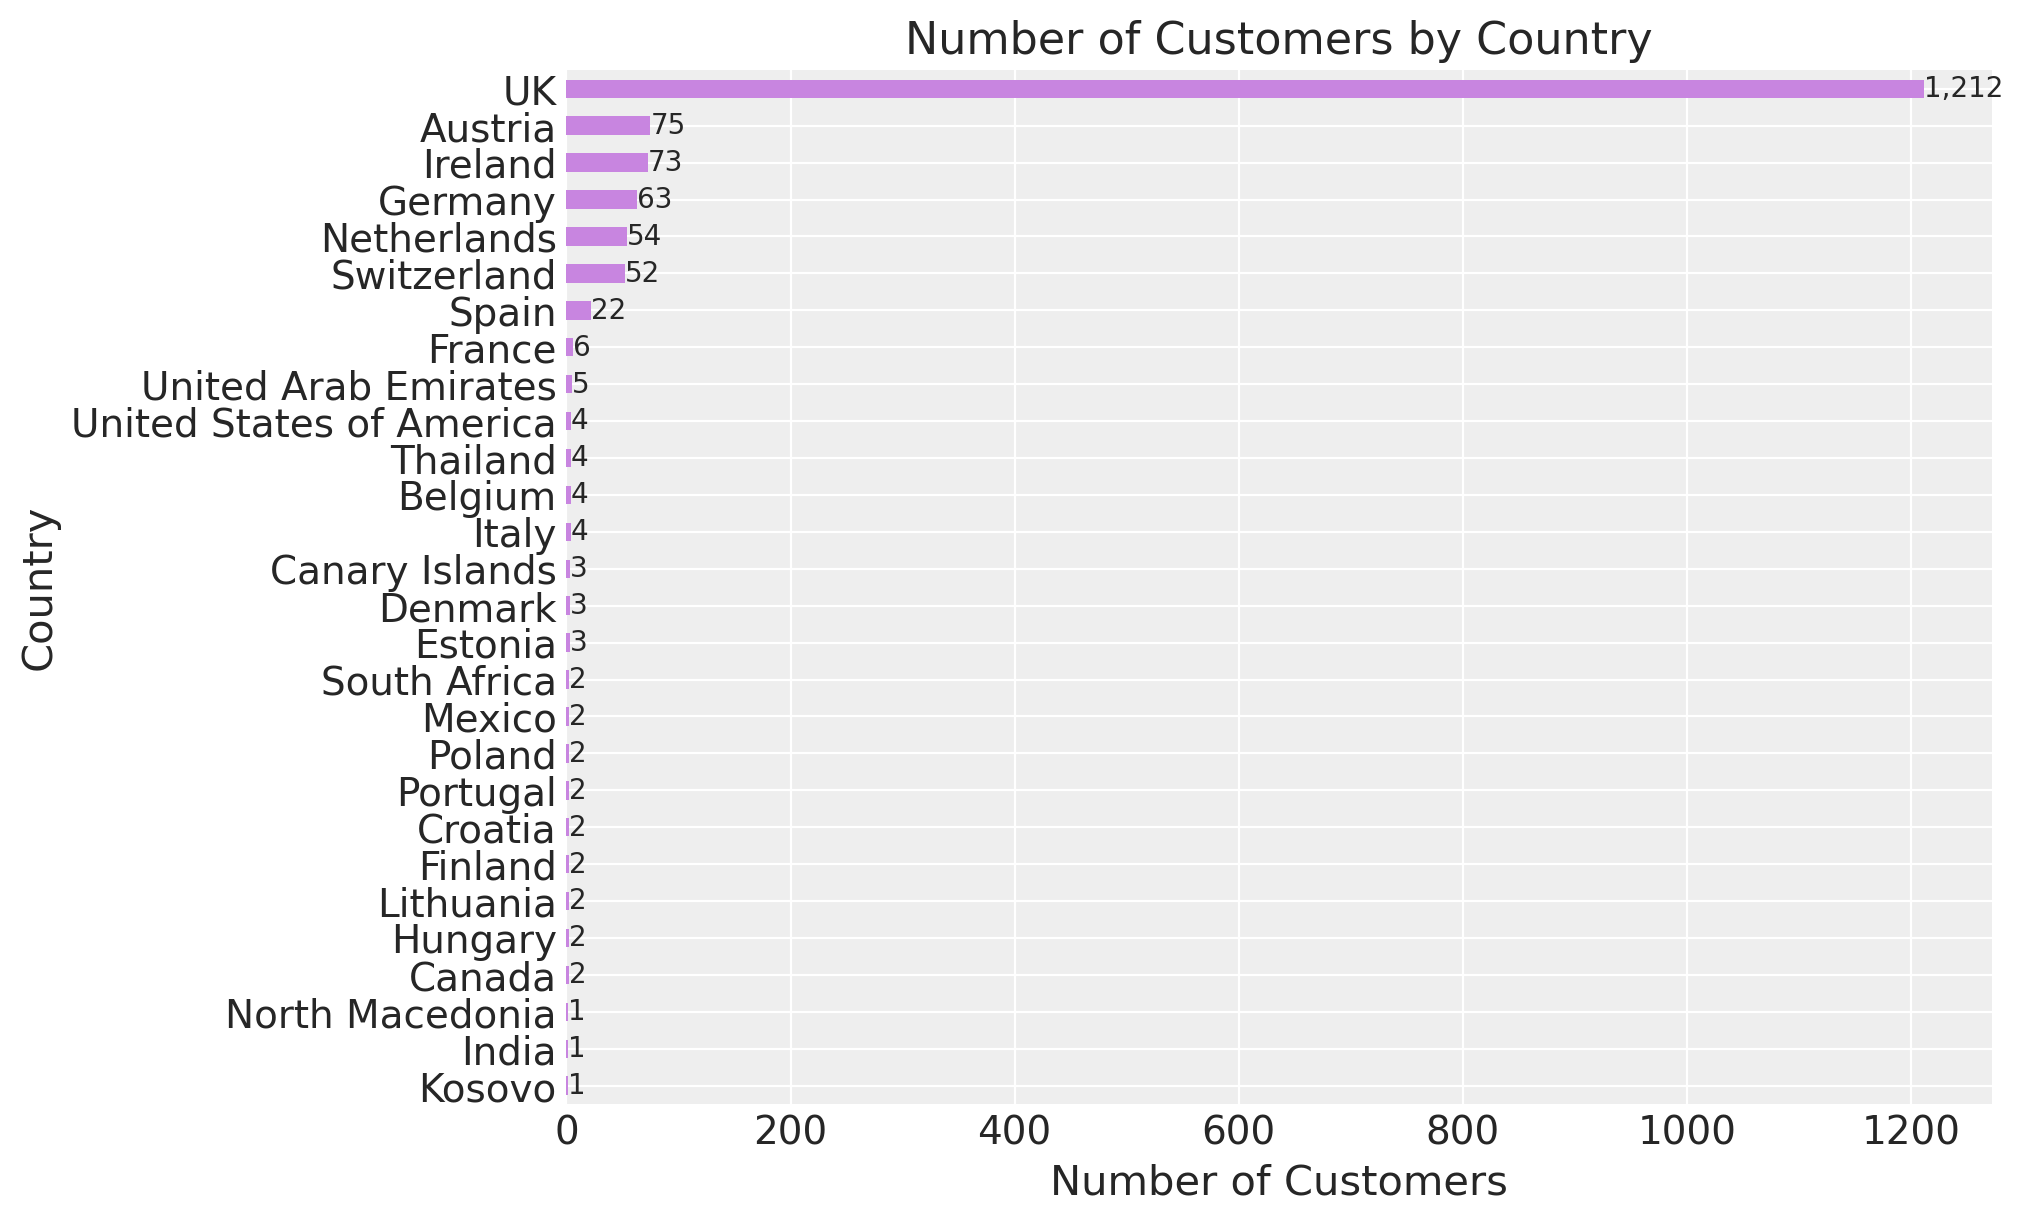

In [137]:
# Set COUNTRY as index for proper horizontal bar plotting
plot_data = cust_country_active.set_index("COUNTRY")

# Create the plot
ax_cc = (plot_data["count_total"]).plot.barh(color="#C885E0")
ax_cc.bar_label(ax_cc.containers[0], label_type="edge", fmt="{:,.0f}")
ax_cc.set_title("Number of Customers by Country")
ax_cc.set_xlabel("Number of Customers")
ax_cc.set_ylabel("Country")
plt.show()

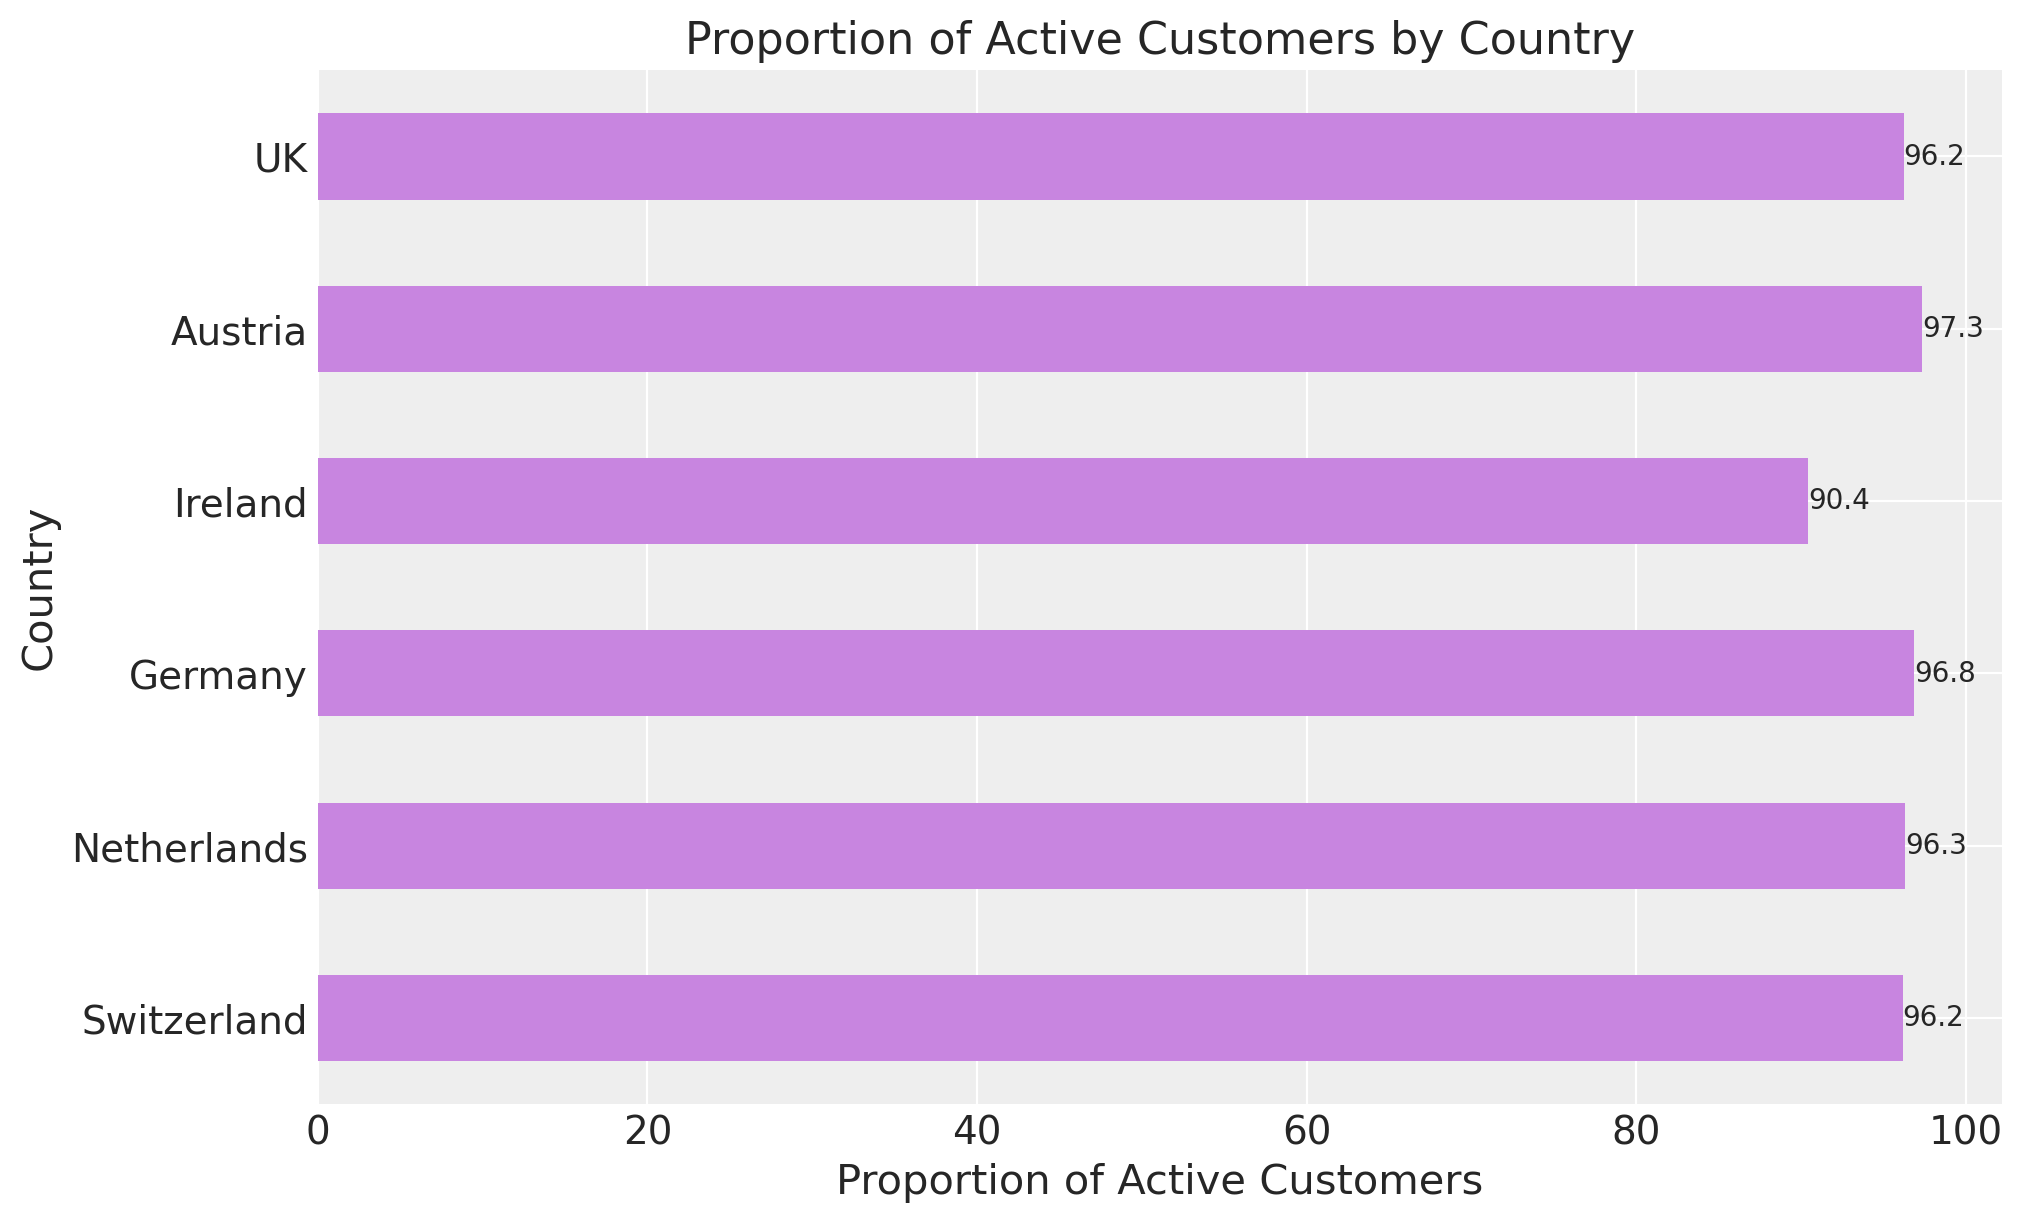

In [156]:
country_order = [
    "Switzerland",
    "Netherlands",
    "Germany",
    "Ireland",
    "Austria",
    "UK",
    "Total",
]
# Filter plot_data to only include countries in country_order
plot_data_filtered = plot_data[plot_data.index.isin(country_order)]

# Create the plot
ax_cc = plot_data_filtered["proportion_active"].plot.barh(color="#C885E0")


ax_cc.bar_label(ax_cc.containers[0], label_type="edge", fmt="{:,.1f}")
ax_cc.set_title("Proportion of Active Customers by Country")
ax_cc.set_xlabel("Proportion of Active Customers")
ax_cc.set_ylabel("Country")
plt.show()

In [16]:
customers[["COUNTRY", "IS_STILL_CUSTOMER"]].groupby(["COUNTRY"]).value_counts(
    normalize=False
).reset_index()

,COUNTRY,IS_STILL_CUSTOMER,count
0,Austria,True,73
1,Austria,False,2
2,Belgium,True,4
3,Canada,True,2
4,Canary Islands,True,3
5,Croatia,True,2
6,Denmark,True,3
7,Estonia,True,3
8,Finland,True,2
9,France,True,4


In [17]:
# personal check: are most of the missed customers new customers?
missed_cust_check = (
    customers[["COUNTRY", "IS_STILL_CUSTOMER", "PURCHASED_AS_NEW_CUSTOMER"]]
    .groupby(["COUNTRY"])
    .value_counts(normalize=False)
    .reset_index()
)
missed_cust_check[missed_cust_check.IS_STILL_CUSTOMER == False]

,COUNTRY,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,count
2,Austria,False,True,2
12,France,False,True,2
15,Germany,False,True,2
20,Ireland,False,True,7
25,Mexico,False,False,2
28,Netherlands,False,True,2
32,South Africa,False,True,2
37,Switzerland,False,True,2
42,UK,False,True,39
43,UK,False,False,7


In [28]:
countries_to_include = [
    "UK",
    "Austria",
    "Ireland",
    "Germany",
    "Netherlands",
    "Switzerland",
]
customers_filtered = customers[customers["COUNTRY"].isin(countries_to_include)]

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/51603907.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_country, labels=countries, patch_artist=True)
/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/51603907.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


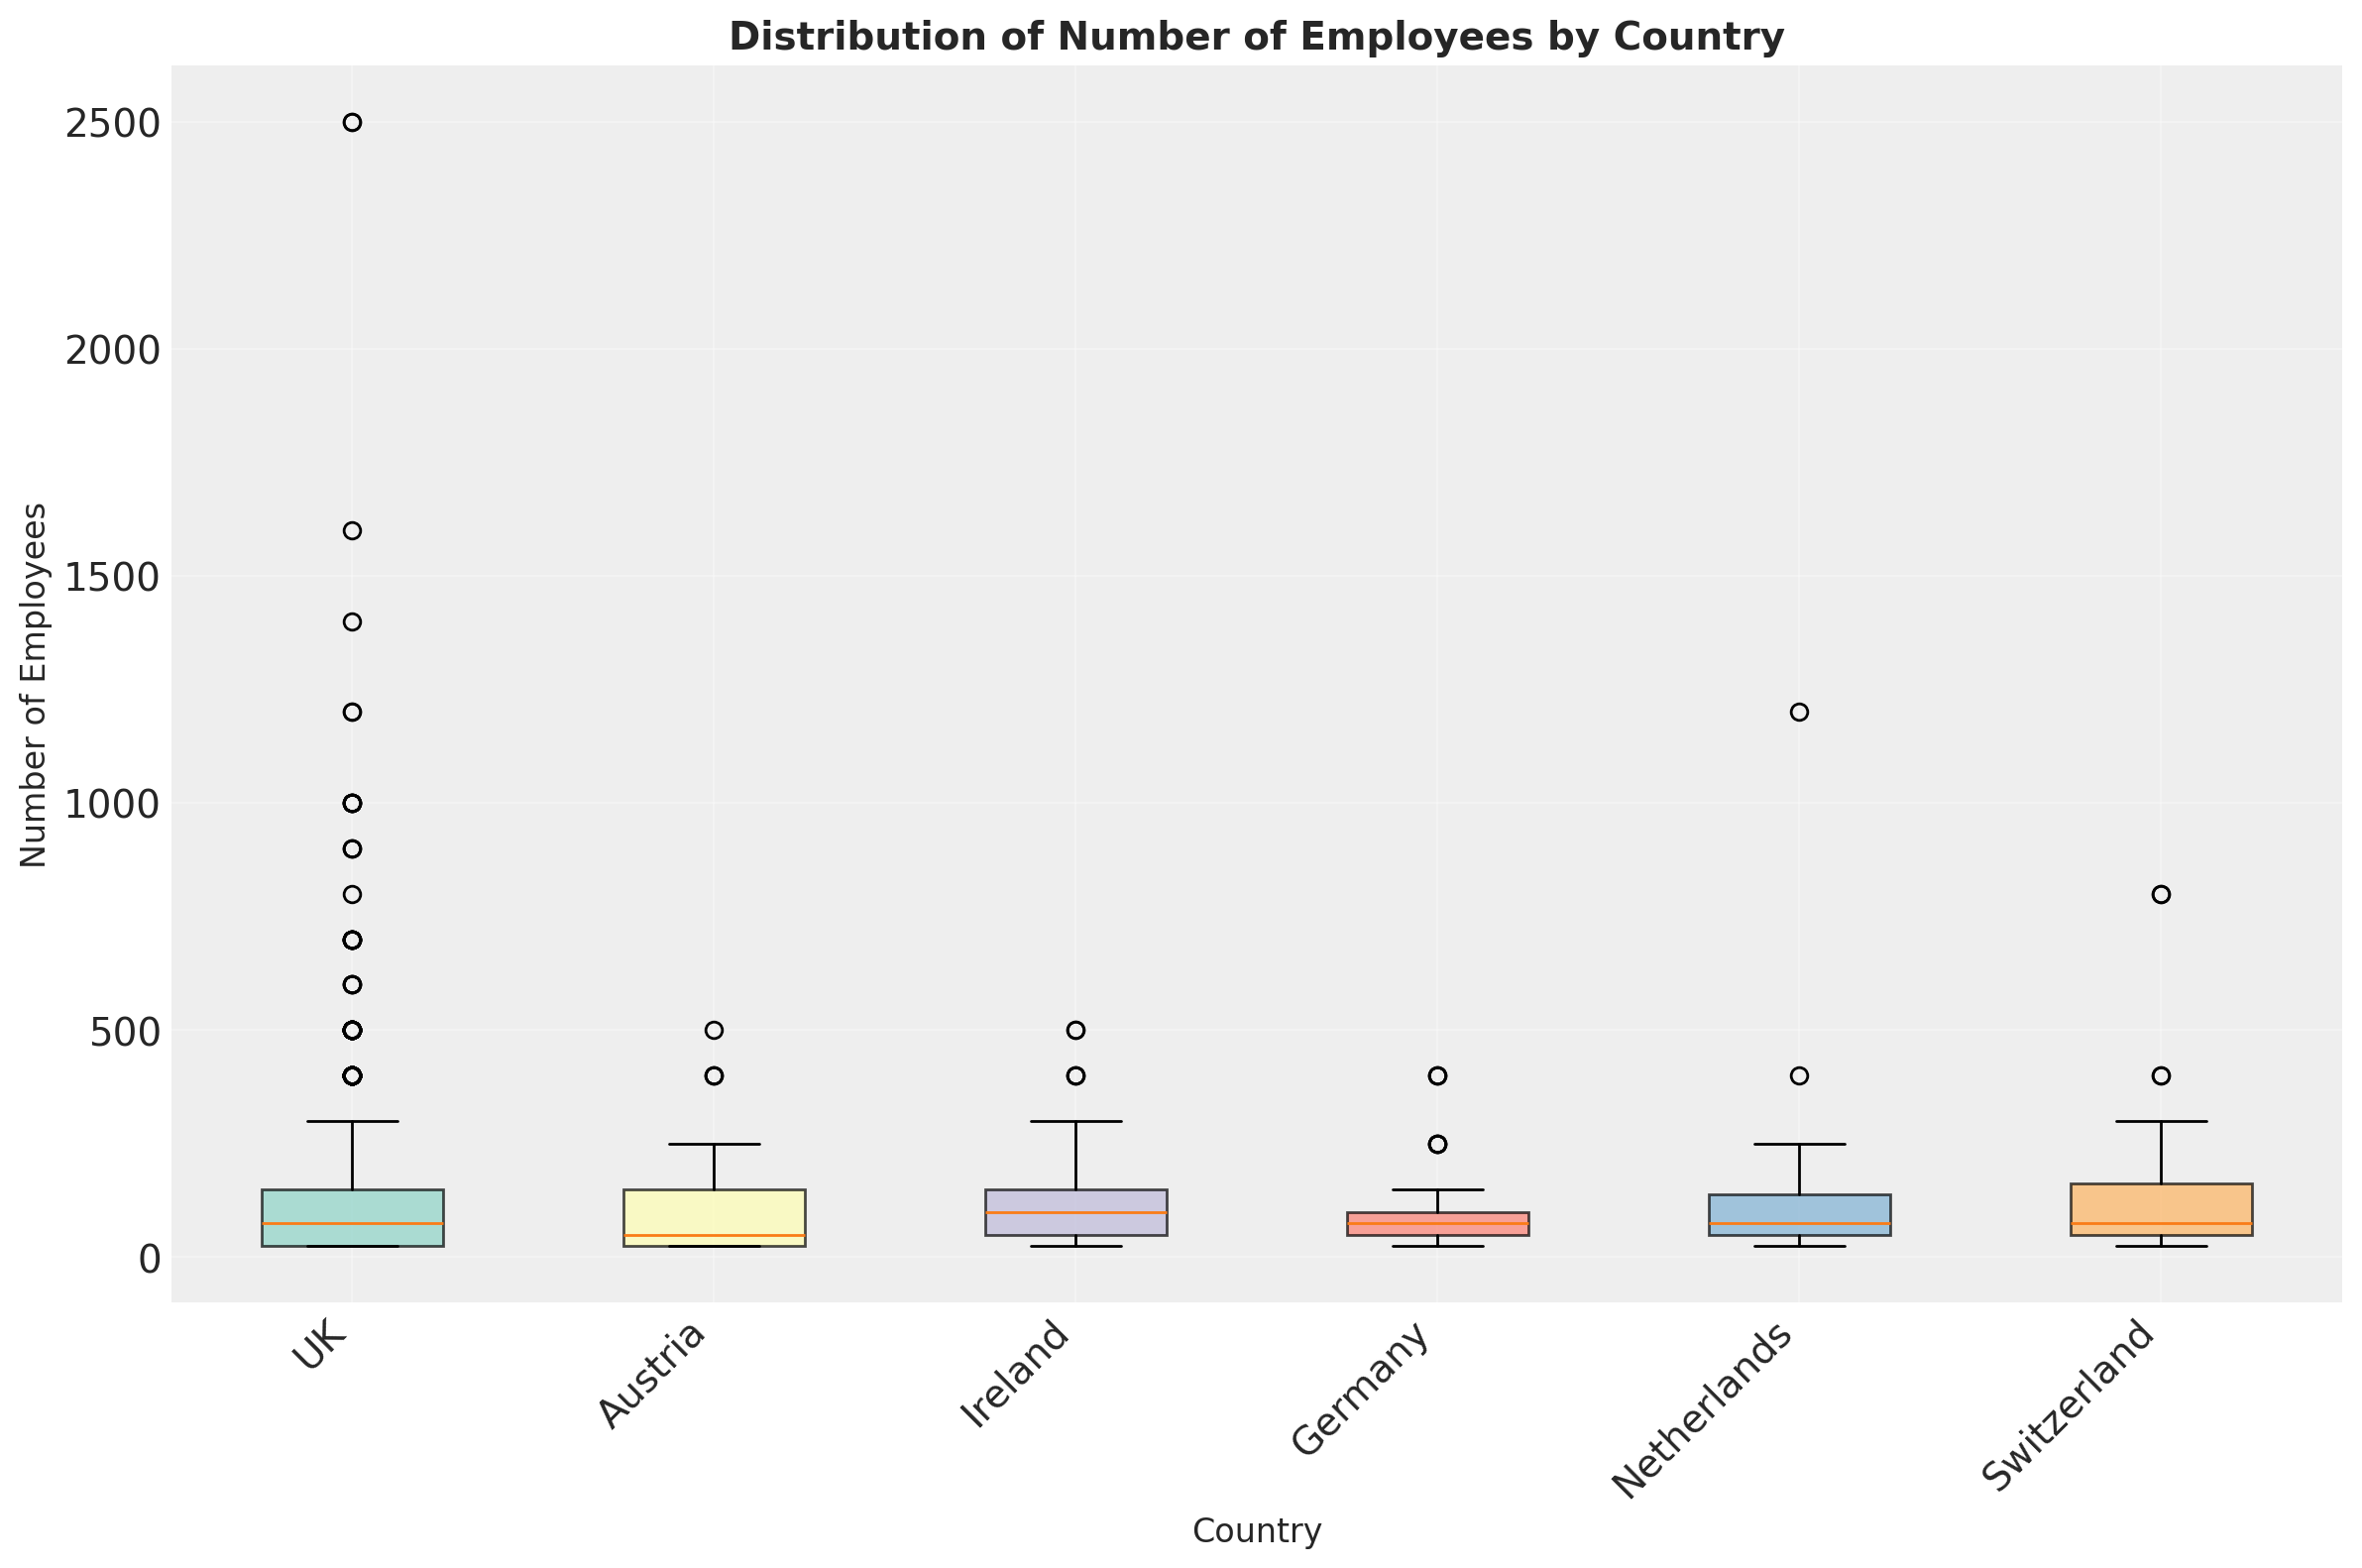

In [29]:
# Boxplot of NO_EMPLOYEES by COUNTRY
plt.figure(figsize=(12, 8))

# Get unique countries and prepare data for boxplot
# countries = cust_country["COUNTRY"].unique()
countries = countries_to_include
data_by_country = []

for country in countries:
    country_data = customers_filtered[customers_filtered["COUNTRY"] == country][
        "NO_EMPLOYEES"
    ].dropna()
    data_by_country.append(country_data)

# Create the boxplot
box_plot = plt.boxplot(data_by_country, labels=countries, patch_artist=True)

# Customize the plot
plt.title(
    "Distribution of Number of Employees by Country", fontsize=14, fontweight="bold"
)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add some color to the boxes
colors = plt.cm.Set3(range(len(countries)))
for patch, color in zip(box_plot["boxes"], colors, strict=False):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/4192790281.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


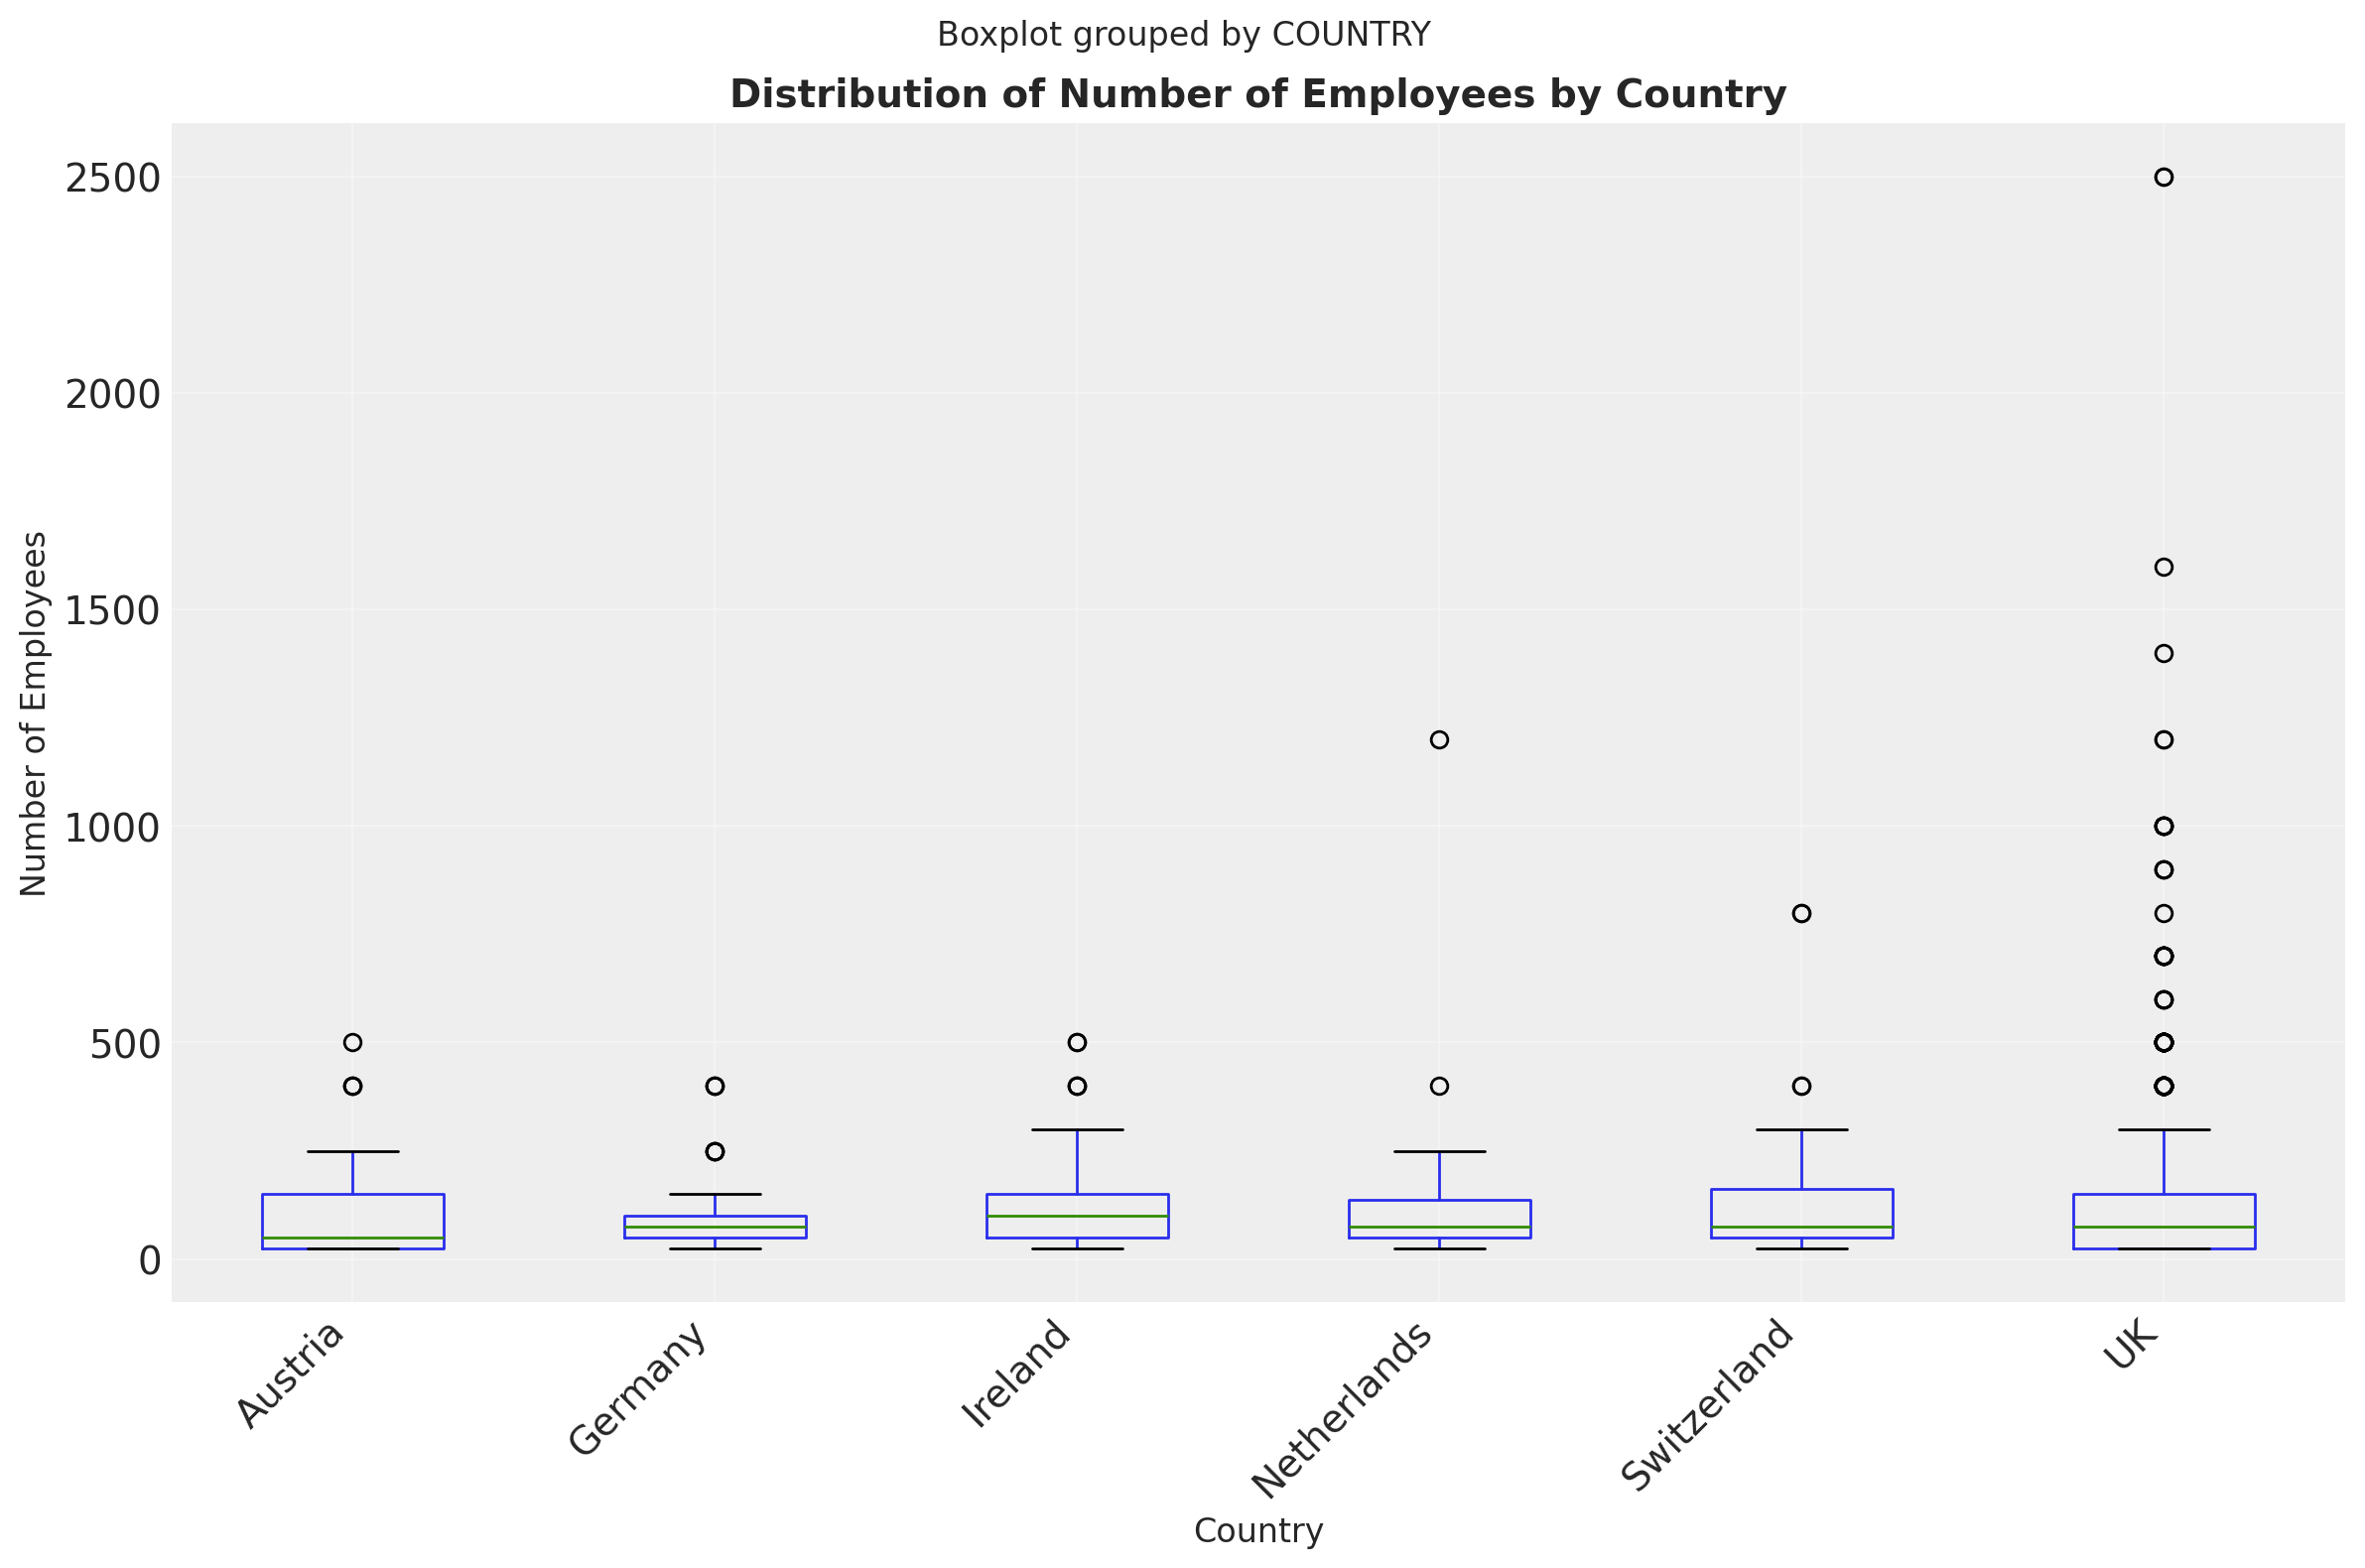

In [30]:
# Alternative approach using pandas boxplot (simpler)
plt.figure(figsize=(12, 8))
customers_filtered.boxplot(column="NO_EMPLOYEES", by="COUNTRY", ax=plt.gca())
plt.title(
    "Distribution of Number of Employees by Country", fontsize=14, fontweight="bold"
)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
# Summary statistics
print("Summary Statistics for NO_EMPLOYEES:")
print("=" * 40)
print(f"Count: {customers_filtered['NO_EMPLOYEES'].count()}")
print(f"Mean: {customers_filtered['NO_EMPLOYEES'].mean():.2f}")
print(f"Median: {customers_filtered['NO_EMPLOYEES'].median():.2f}")
print(f"Std: {customers_filtered['NO_EMPLOYEES'].std():.2f}")
print(f"Min: {customers_filtered['NO_EMPLOYEES'].min():.2f}")
print(f"Max: {customers_filtered['NO_EMPLOYEES'].max():.2f}")
print(f"25th percentile: {customers_filtered['NO_EMPLOYEES'].quantile(0.25):.2f}")
print(f"75th percentile: {customers_filtered['NO_EMPLOYEES'].quantile(0.75):.2f}")

# Additional insights
print("\nAdditional Insights:")
print("=" * 40)
print(
    f"Companies with < 10 employees: {(customers_filtered['NO_EMPLOYEES'] < 10).sum()} ({(customers_filtered['NO_EMPLOYEES'] < 10).mean() * 100:.1f}%)"
)
print(
    f"Companies with 10-50 employees: {((customers_filtered['NO_EMPLOYEES'] >= 10) & (customers_filtered['NO_EMPLOYEES'] < 50)).sum()} ({((customers_filtered['NO_EMPLOYEES'] >= 10) & (customers_filtered['NO_EMPLOYEES'] < 50)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 50-200 employees: {((customers_filtered['NO_EMPLOYEES'] >= 50) & (customers_filtered['NO_EMPLOYEES'] < 200)).sum()} ({((customers_filtered['NO_EMPLOYEES'] >= 50) & (customers_filtered['NO_EMPLOYEES'] < 200)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 200-500 employees: {((customers_filtered['NO_EMPLOYEES'] >= 200) & (customers_filtered['NO_EMPLOYEES'] < 500)).sum()} ({((customers_filtered['NO_EMPLOYEES'] >= 200) & (customers_filtered['NO_EMPLOYEES'] < 500)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 500+ employees: {(customers_filtered['NO_EMPLOYEES'] >= 500).sum()} ({(customers_filtered['NO_EMPLOYEES'] >= 500).mean() * 100:.1f}%)"
)


Summary Statistics for NO_EMPLOYEES:
Count: 1526
Mean: 122.97
Median: 75.00
Std: 174.93
Min: 25.00
Max: 2500.00
25th percentile: 25.00
75th percentile: 150.00

Additional Insights:
Companies with < 10 employees: 0 (0.0%)
Companies with 10-50 employees: 417 (27.3%)
Companies with 50-200 employees: 814 (53.2%)
Companies with 200-500 employees: 238 (15.6%)
Companies with 500+ employees: 57 (3.7%)


In [22]:
# Summary statistics
# (check if the distributions agree with the filtered dataset)
print("Summary Statistics for NO_EMPLOYEES:")
print("=" * 40)
print(f"Count: {customers['NO_EMPLOYEES'].count()}")
print(f"Mean: {customers['NO_EMPLOYEES'].mean():.2f}")
print(f"Median: {customers['NO_EMPLOYEES'].median():.2f}")
print(f"Std: {customers['NO_EMPLOYEES'].std():.2f}")
print(f"Min: {customers['NO_EMPLOYEES'].min():.2f}")
print(f"Max: {customers['NO_EMPLOYEES'].max():.2f}")
print(f"25th percentile: {customers['NO_EMPLOYEES'].quantile(0.25):.2f}")
print(f"75th percentile: {customers['NO_EMPLOYEES'].quantile(0.75):.2f}")

# Additional insights
print("\nAdditional Insights:")
print("=" * 40)
print(
    f"Companies with < 10 employees: {(customers['NO_EMPLOYEES'] < 10).sum()} ({(customers['NO_EMPLOYEES'] < 10).mean() * 100:.1f}%)"
)
print(
    f"Companies with 10-50 employees: {((customers['NO_EMPLOYEES'] >= 10) & (customers['NO_EMPLOYEES'] < 50)).sum()} ({((customers['NO_EMPLOYEES'] >= 10) & (customers['NO_EMPLOYEES'] < 50)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 50-200 employees: {((customers['NO_EMPLOYEES'] >= 50) & (customers['NO_EMPLOYEES'] < 200)).sum()} ({((customers['NO_EMPLOYEES'] >= 50) & (customers['NO_EMPLOYEES'] < 200)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 200-500 employees: {((customers['NO_EMPLOYEES'] >= 200) & (customers['NO_EMPLOYEES'] < 500)).sum()} ({((customers['NO_EMPLOYEES'] >= 200) & (customers['NO_EMPLOYEES'] < 500)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 500+ employees: {(customers['NO_EMPLOYEES'] >= 500).sum()} ({(customers['NO_EMPLOYEES'] >= 500).mean() * 100:.1f}%)"
)


Summary Statistics for NO_EMPLOYEES:
Count: 1603
Mean: 122.45
Median: 75.00
Std: 174.13
Min: 25.00
Max: 2500.00
25th percentile: 25.00
75th percentile: 150.00

Additional Insights:
Companies with < 10 employees: 0 (0.0%)
Companies with 10-50 employees: 432 (26.9%)
Companies with 50-200 employees: 868 (54.0%)
Companies with 200-500 employees: 244 (15.2%)
Companies with 500+ employees: 59 (3.7%)


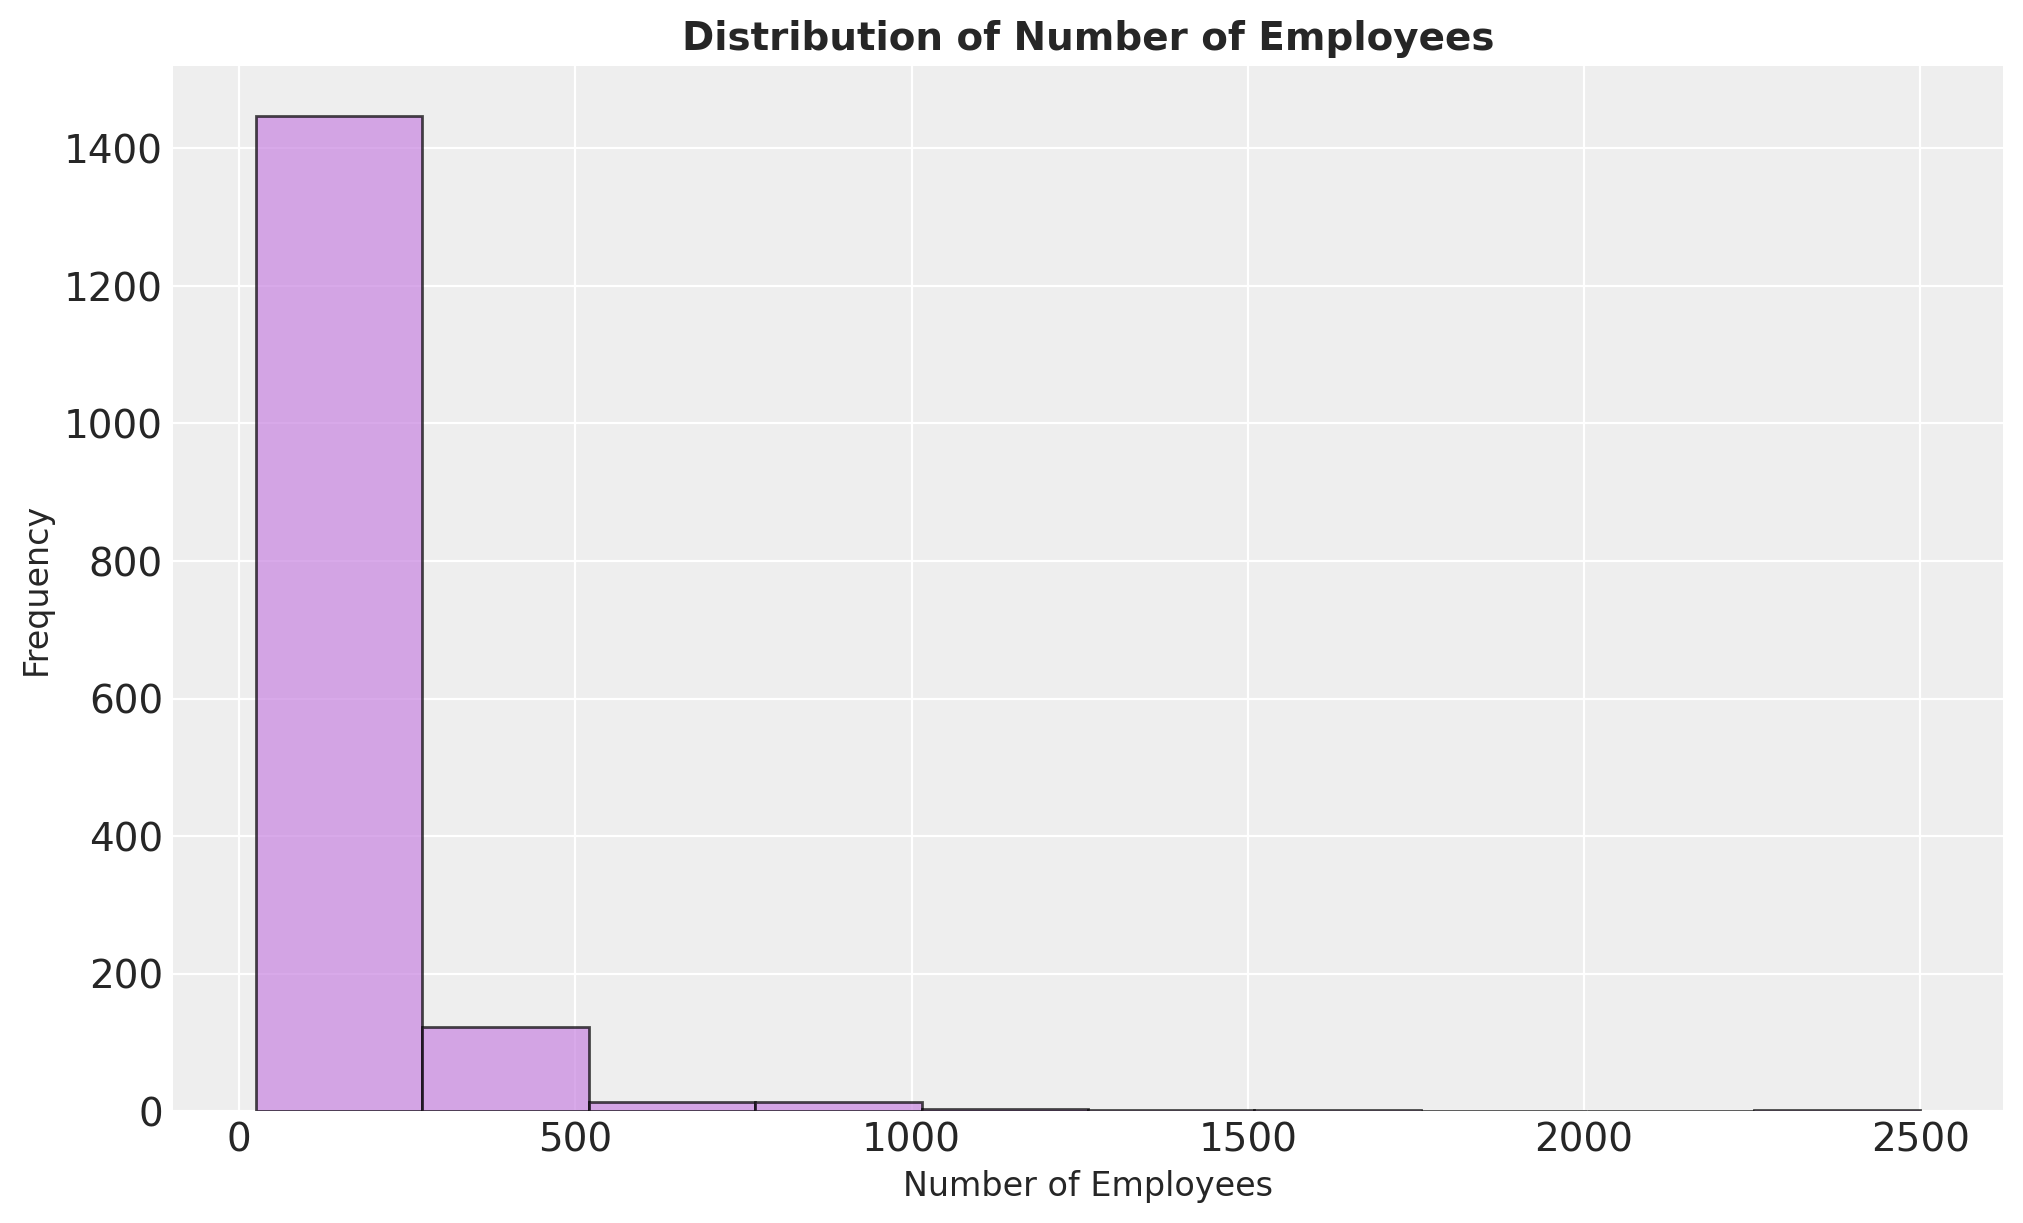

In [132]:
customers.loc[customers["NO_EMPLOYEES"] < 3000, "NO_EMPLOYEES"].hist(
    bins=10, alpha=0.7, color="#C885E0", edgecolor="black"
)
plt.title("Distribution of Number of Employees", fontsize=14, fontweight="bold")
plt.xlabel("Number of Employees", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/4182759456.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


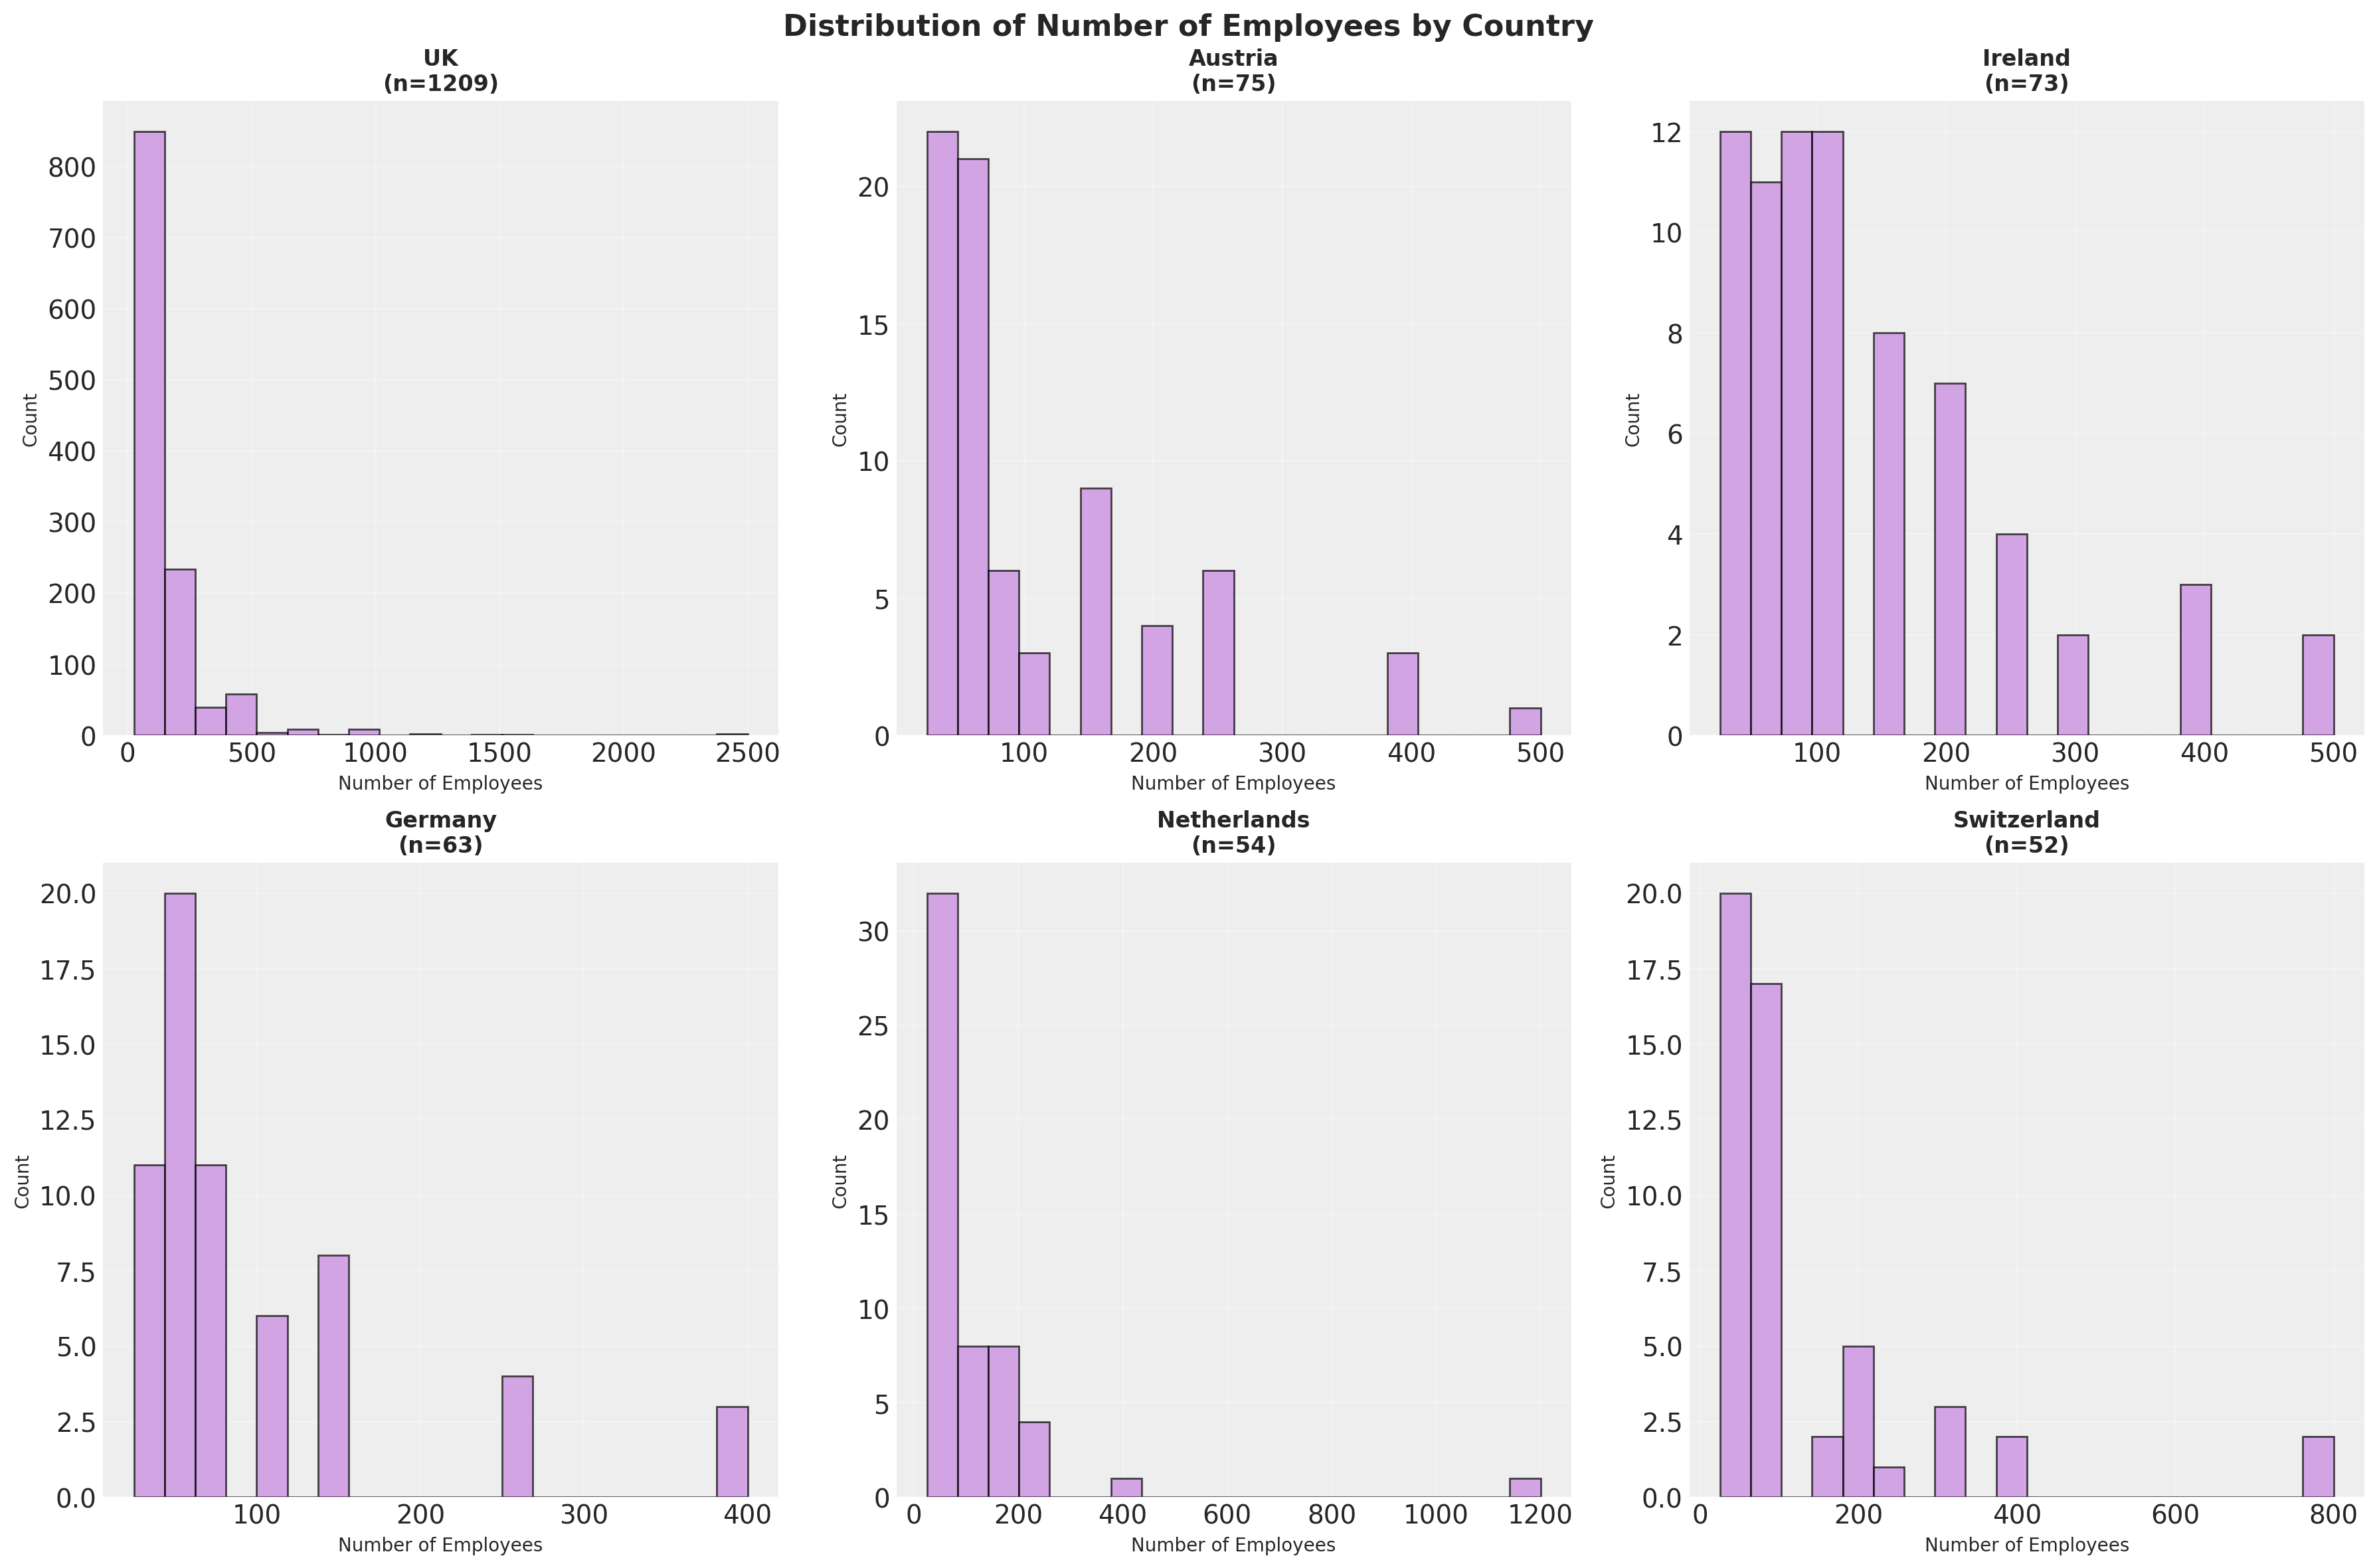

Summary Statistics by Country:

UK (n=1209):
  Mean: 125.0
  Median: 75.0
  Min: 25.0
  Max: 2500.0
  25th percentile: 25.00
  75th percentile: 150.00

Austria (n=75):
  Mean: 102.7
  Median: 50.0
  Min: 25.0
  Max: 500.0
  25th percentile: 25.00
  75th percentile: 150.00

Ireland (n=73):
  Mean: 128.1
  Median: 100.0
  Min: 25.0
  Max: 500.0
  25th percentile: 50.00
  75th percentile: 150.00

Germany (n=63):
  Mean: 96.8
  Median: 75.0
  Min: 25.0
  Max: 400.0
  25th percentile: 50.00
  75th percentile: 100.00

Netherlands (n=54):
  Mean: 118.5
  Median: 75.0
  Min: 25.0
  Max: 1200.0
  25th percentile: 50.00
  75th percentile: 137.50

Switzerland (n=52):
  Mean: 135.1
  Median: 75.0
  Min: 25.0
  Max: 800.0
  25th percentile: 50.00
  75th percentile: 162.50


In [133]:
# Distribution of NO_EMPLOYEES by Country
# countries = customers["COUNTRY"].unique()
countries = countries_to_include

n_countries = len(countries)

# Calculate subplot layout
n_cols = 3
n_rows = (n_countries + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
fig.suptitle(
    "Distribution of Number of Employees by Country", fontsize=16, fontweight="bold"
)

# Flatten axes array for easier indexing
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

for i, country in enumerate(countries):
    ax = axes_flat[i]

    # Get data for this country
    country_data = customers[customers["COUNTRY"] == country]["NO_EMPLOYEES"].dropna()

    # Create histogram
    country_data.hist(bins=20, ax=ax, alpha=0.7, color="#C885E0", edgecolor="black")

    # Customize subplot
    ax.set_title(f"{country}\n(n={len(country_data)})", fontsize=12, fontweight="bold")
    ax.set_xlabel("Number of Employees", fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_countries, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics by country
print("Summary Statistics by Country:")
print("=" * 50)
for country in countries:
    country_data = customers[customers["COUNTRY"] == country]["NO_EMPLOYEES"].dropna()
    print(f"\n{country} (n={len(country_data)}):")
    print(f"  Mean: {country_data.mean():.1f}")
    print(f"  Median: {country_data.median():.1f}")
    print(f"  Min: {country_data.min():.1f}")
    print(f"  Max: {country_data.max():.1f}")
    print(f"  25th percentile: {country_data.quantile(0.25):.2f}")
    print(f"  75th percentile: {country_data.quantile(0.75):.2f}")


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/2169969373.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1400x1000 with 0 Axes>

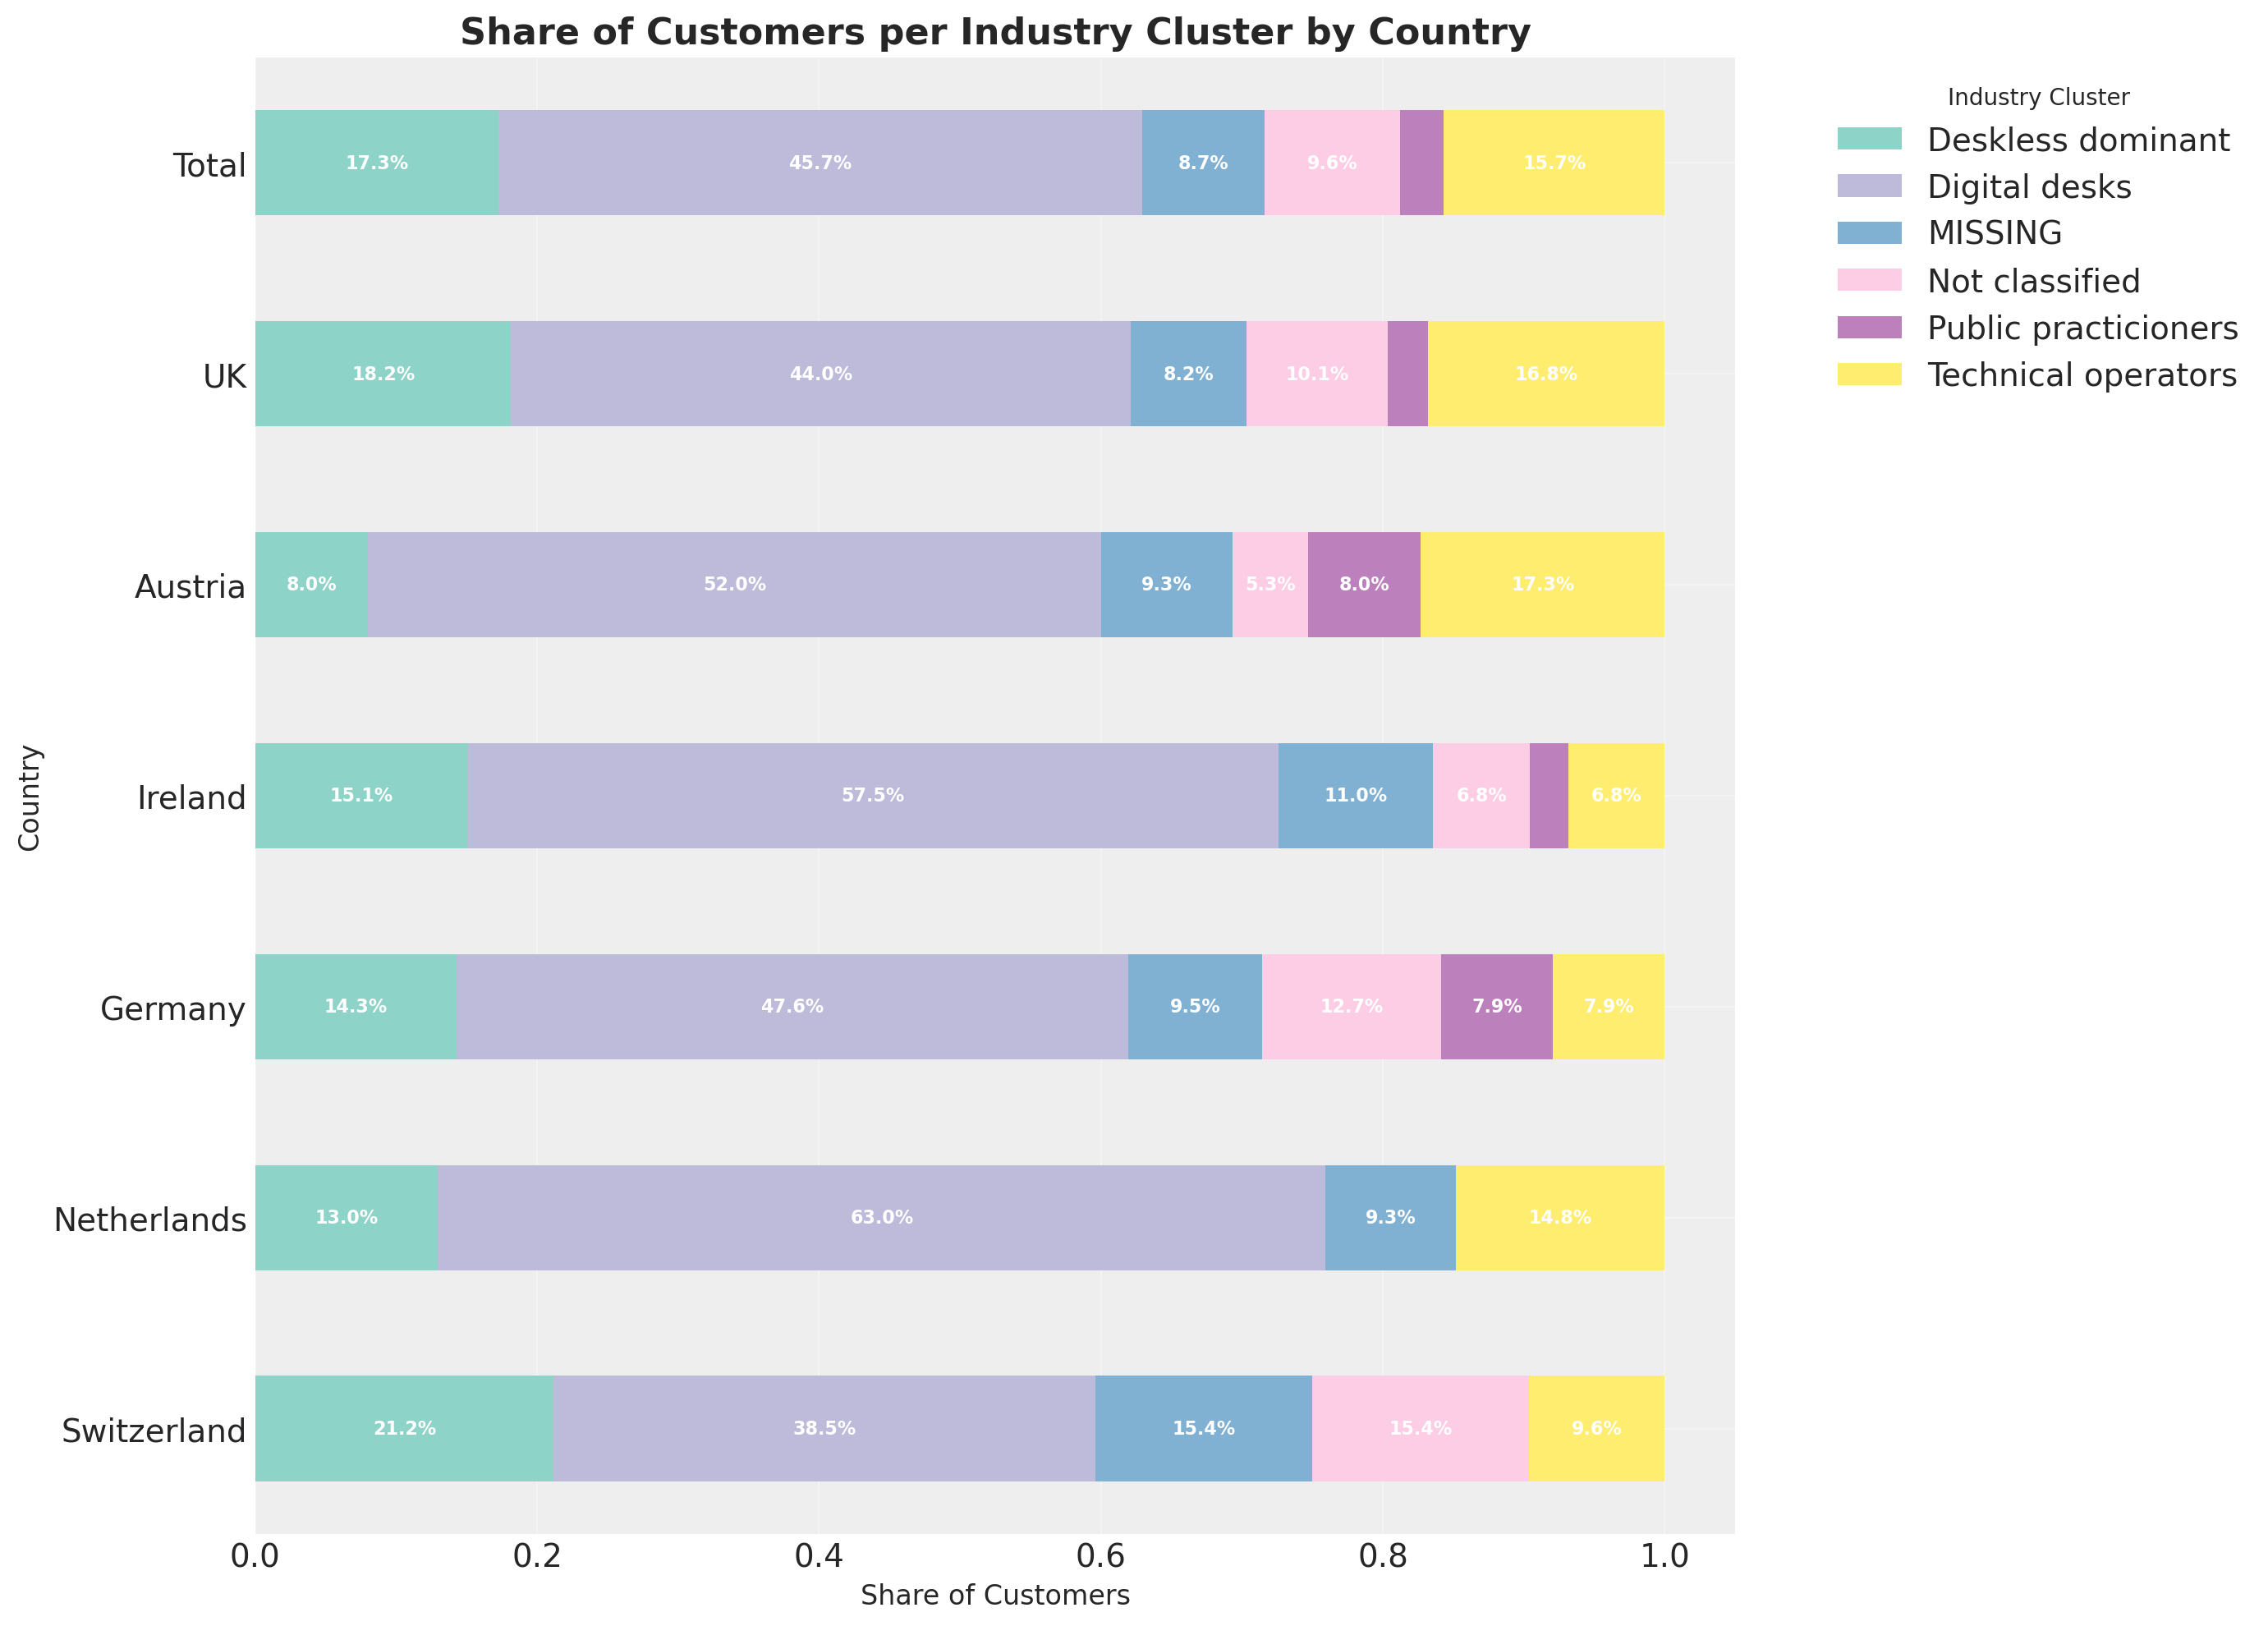

In [150]:
# Calculate the share of customers per INDUSTRY_CLUSTER grouped by COUNTRY
customers_subset = customers_filtered[["COUNTRY", "INDUSTRY_CLUSTER"]].fillna("MISSING")

industry_share = (
    customers_subset.groupby("COUNTRY")["INDUSTRY_CLUSTER"]
    .value_counts(normalize=True)
    .reset_index()
)
industry_share.columns = ["COUNTRY", "INDUSTRY_CLUSTER", "SHARE"]

# Calculate the total distribution from the full customers dataset
total_distribution = (
    customers_subset["INDUSTRY_CLUSTER"].value_counts(normalize=True).reset_index()
)
total_distribution.columns = ["INDUSTRY_CLUSTER", "SHARE"]
total_distribution["COUNTRY"] = "Total"

# Combine the country-specific and total distributions
combined_share = pd.concat([industry_share, total_distribution], ignore_index=True)

# Create a pivot table with countries as index and industry clusters as columns
industry_pivot = combined_share.pivot(
    index="COUNTRY", columns="INDUSTRY_CLUSTER", values="SHARE"
).fillna(0)

# Set the order for the y-axis (countries)
country_order = [
    "Switzerland",
    "Netherlands",
    "Germany",
    "Ireland",
    "Austria",
    "UK",
    "Total",
]

# Reindex the pivot table to match the desired order
industry_pivot = industry_pivot.reindex(country_order)

# Create a stacked bar chart showing countries on x-axis and industry clusters as colors
plt.figure(figsize=(14, 10))

industry_pivot.plot(kind="barh", stacked=True, figsize=(14, 10), colormap="Set3")

plt.title(
    "Share of Customers per Industry Cluster by Country", fontsize=16, fontweight="bold"
)
plt.xlabel("Share of Customers", fontsize=12)
plt.ylabel("Country", fontsize=12)

# Add labels to the bars showing the industry share
ax = plt.gca()
for container in ax.containers:
    # Only show labels for segments larger than 5% to avoid clutter
    labels = [f"{v:.1%}" if v > 0.05 else "" for v in container.datavalues]
    ax.bar_label(
        container,
        labels=labels,
        label_type="center",
        fontsize=8,
        color="white",
        weight="bold",
    )
plt.legend(title="Industry Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [155]:
# Display the data table
print("Share of Customers per Industry Cluster by Country:")
print("=" * 60)
industry_pivot.round(3)

Share of Customers per Industry Cluster by Country:


INDUSTRY_CLUSTER,Deskless dominant,Digital desks,MISSING,Not classified,Public practicioners,Technical operators
COUNTRY,,,,,,
Switzerland,0.212,0.385,0.154,0.154,0.000,0.096
Netherlands,0.130,0.630,0.093,0.000,0.000,0.148
Germany,0.143,0.476,0.095,0.127,0.079,0.079
Ireland,0.151,0.575,0.110,0.068,0.027,0.068
Austria,0.080,0.520,0.093,0.053,0.080,0.173
UK,0.182,0.440,0.082,0.101,0.028,0.168
Total,0.173,0.457,0.087,0.096,0.031,0.157


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/1199192864.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1400x1000 with 0 Axes>

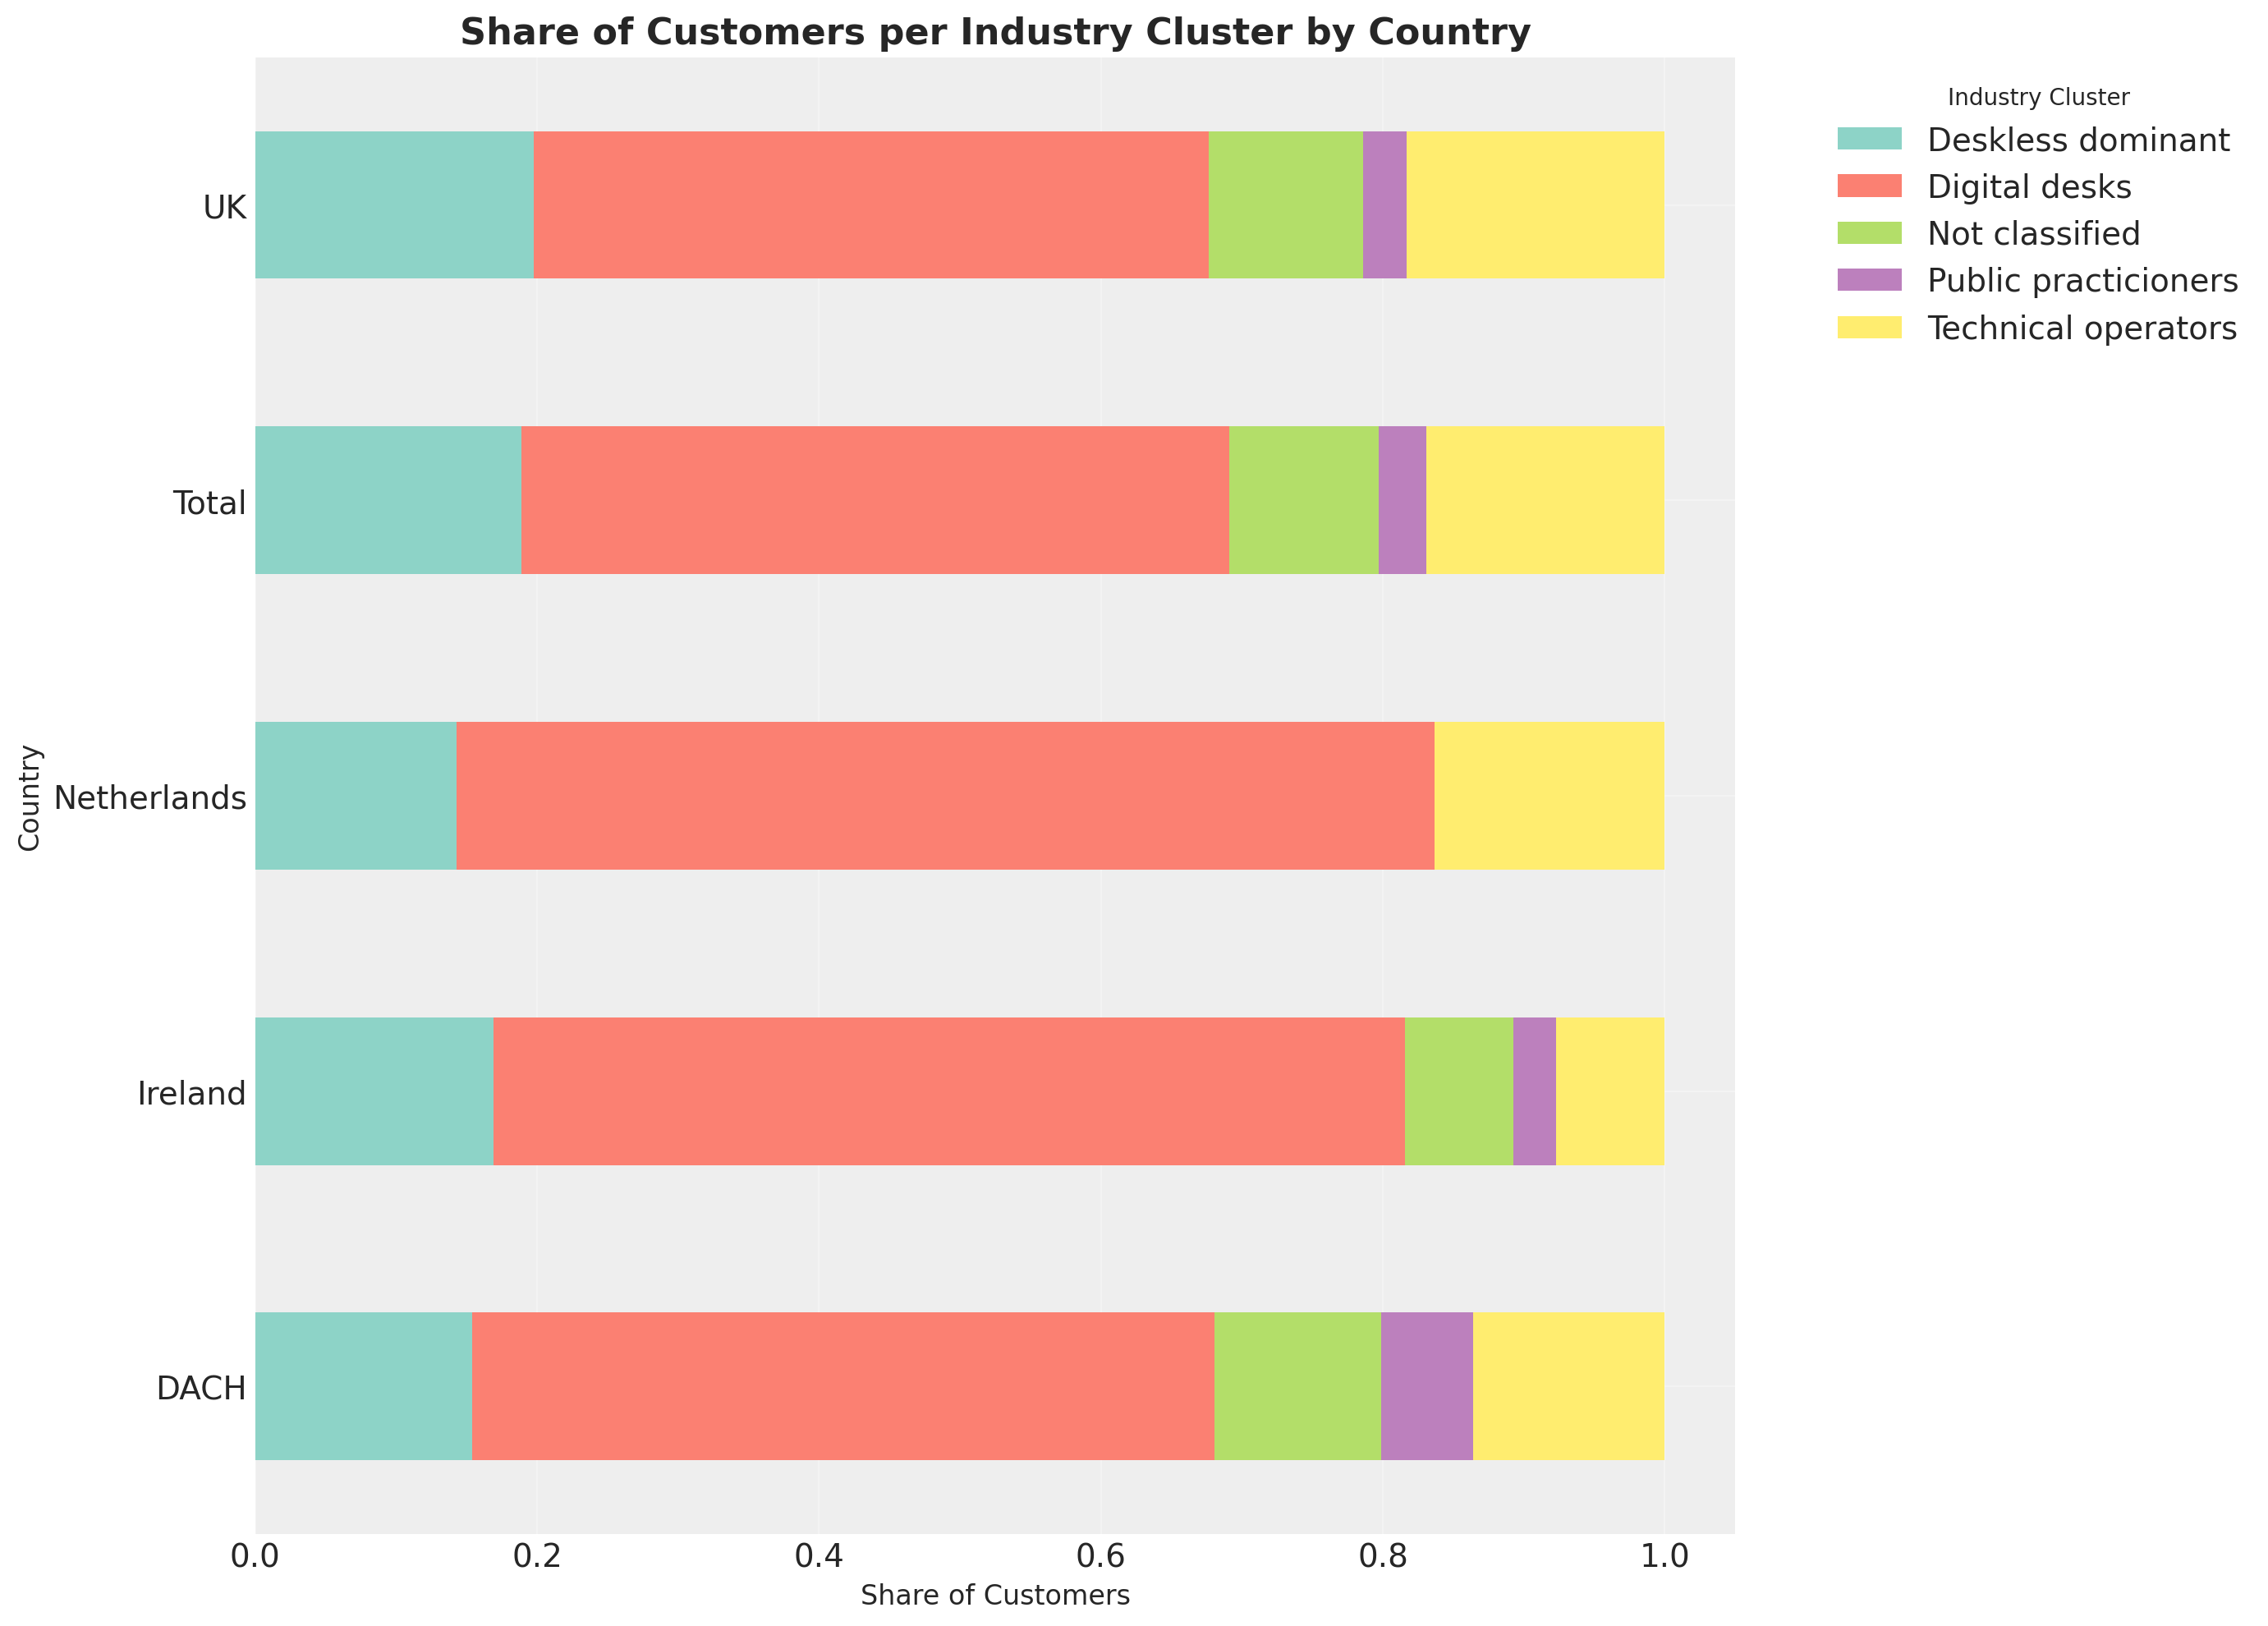

Share of Customers per Industry Cluster by Country:
INDUSTRY_CLUSTER  Deskless dominant  Digital desks  Not classified  \
COUNTRY_GROUP                                                        
DACH                          0.154          0.527           0.118   
Ireland                       0.169          0.646           0.077   
Netherlands                   0.143          0.694           0.000   
Total                         0.189          0.502           0.106   
UK                            0.198          0.479           0.110   

INDUSTRY_CLUSTER  Public practicioners  Technical operators  
COUNTRY_GROUP                                                
DACH                             0.065                0.136  
Ireland                          0.031                0.077  
Netherlands                      0.000                0.163  
Total                            0.034                0.169  
UK                               0.031                0.183  


In [26]:
# Calculate the share of customers per INDUSTRY_CLUSTER grouped by COUNTRY
industry_share = (
    customers_filtered.groupby("COUNTRY_GROUP")["INDUSTRY_CLUSTER"]
    .value_counts(normalize=True)
    .reset_index()
)
industry_share.columns = ["COUNTRY_GROUP", "INDUSTRY_CLUSTER", "SHARE"]

# Calculate the total distribution from the full customers dataset
total_distribution = (
    customers["INDUSTRY_CLUSTER"].value_counts(normalize=True).reset_index()
)
total_distribution.columns = ["INDUSTRY_CLUSTER", "SHARE"]
total_distribution["COUNTRY_GROUP"] = "Total"

# Combine the country-specific and total distributions
combined_share = pd.concat([industry_share, total_distribution], ignore_index=True)

# Create a pivot table with countries as index and industry clusters as columns
industry_pivot = combined_share.pivot(
    index="COUNTRY_GROUP", columns="INDUSTRY_CLUSTER", values="SHARE"
).fillna(0)

# Create a stacked bar chart showing countries on x-axis and industry clusters as colors
plt.figure(figsize=(14, 10))
industry_pivot.plot(kind="barh", stacked=True, figsize=(14, 10), colormap="Set3")
plt.title(
    "Share of Customers per Industry Cluster by Country", fontsize=16, fontweight="bold"
)
plt.xlabel("Share of Customers", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.legend(title="Industry Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display the data table
print("Share of Customers per Industry Cluster by Country:")
print("=" * 60)
print(industry_pivot.round(3))


In [125]:
customers["INDUSTRY_CLUSTER"].unique()

array(['Deskless dominant', 'Technical operators', 'Digital desks',
       'Not classified', nan, 'Public practicioners'], dtype=object)

#  Events EDA

In [ ]:
events["event_value"] = 1

#  data for funnel analysis
cust_events_raw = events.pivot(
    index="CUSTOMER_ID", columns="EVENT", values="event_value"
).reset_index()

cust_events = pd.merge(customers, cust_events_raw, on="CUSTOMER_ID", how="left").fillna(
    0
)

cust_events.head()

,CUSTOMER_ID,COUNTRY,NO_EMPLOYEES,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,INDUSTRY_CLUSTER,PURCHASE_DATE,PURCHASE_MONTH,COUNTRY_GROUP,FIRST_JOB_CREATION_COMPLETED_AT,FIRST_JOB_CREATION_STARTED_AT,FIRST_JOB_PUBLISHED_AT,FIRST_OFFER_CREATED_AT
0,019acc43b90db17385b4cc5e201635e4,UK,50.0,True,True,Deskless dominant,2023-01-01,2023-01,UK,0.0,1.0,0.0,0.0
1,0b50a0ea27a1076ea139fe271673d5a1,UK,100.0,True,True,Technical operators,2023-01-01,2023-01,UK,1.0,1.0,1.0,1.0
2,172f92934eae8bf32b31f4ad2609dc34,UK,50.0,True,True,Technical operators,2023-01-01,2023-01,UK,0.0,0.0,0.0,0.0
3,1e1430c902e49b2378830d0754303d4c,Austria,250.0,True,True,Digital desks,2023-01-01,2023-01,DACH,1.0,1.0,1.0,1.0
4,21a8ea62ecc6da2937e8c840e338c71d,UK,400.0,True,True,Technical operators,2023-01-01,2023-01,UK,1.0,1.0,1.0,1.0


In [128]:
cust_events["TOTAL"] = 1
cust_events["NO_EMPLOYEES_CLUSTER"] = "0-50"
cust_events.loc[cust_events["NO_EMPLOYEES"] >= 50, "NO_EMPLOYEES_CLUSTER"] = "50-200"
cust_events.loc[cust_events["NO_EMPLOYEES"] >= 200, "NO_EMPLOYEES_CLUSTER"] = "200-500"
cust_events.loc[cust_events["NO_EMPLOYEES"] >= 500, "NO_EMPLOYEES_CLUSTER"] = "500+"

cust_events.to_csv("cust_events.csv", index=False)

In [64]:
# Create funnel plot for the job creation progression
funnel_events = [
    "FIRST_JOB_CREATION_STARTED_AT",
    "FIRST_JOB_CREATION_COMPLETED_AT",
    "FIRST_JOB_PUBLISHED_AT",
    "FIRST_OFFER_CREATED_AT",
]

# Define step names (including step 0)
step_names = [
    "TOTAL CUSTOMERS",
    "JOB CREATION START",
    "JOB CREATION COMPLETED",
    "JOB PUBLISHED",
    "OFFER CREATED",
]

# Calculate the number of customers for each step in the funnel
funnel_data = []

# Step 0: Total customers from cust_events dataset
total_customers = len(cust_events)
funnel_data.append(
    {
        "event": "TOTAL_CUSTOMERS",
        "step_name": step_names[0],
        "count": total_customers,
        "percentage": 100.0,
    }
)

# Steps 1-4: Event-based steps
for i, event in enumerate(funnel_events):
    count = cust_events[event].sum()

    funnel_data.append(
        {
            "event": event,
            "step_name": step_names[i + 1],
            "count": int(count),
            "percentage": (count / total_customers) * 100,
        }
    )

funnel_df = pd.DataFrame(funnel_data)

# Display the funnel data
print("Funnel Progression Data:")
print("=" * 50)
for i, row in funnel_df.iterrows():
    print(
        f"{i}. {row['step_name']}: {row['count']:,} customers ({row['percentage']:.1f}%)"
    )

Funnel Progression Data:
0. TOTAL CUSTOMERS: 1,608 customers (100.0%)
1. JOB CREATION START: 793 customers (49.3%)
2. JOB CREATION COMPLETED: 681 customers (42.4%)
3. JOB PUBLISHED: 227 customers (14.1%)
4. OFFER CREATED: 93 customers (5.8%)


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/289575051.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


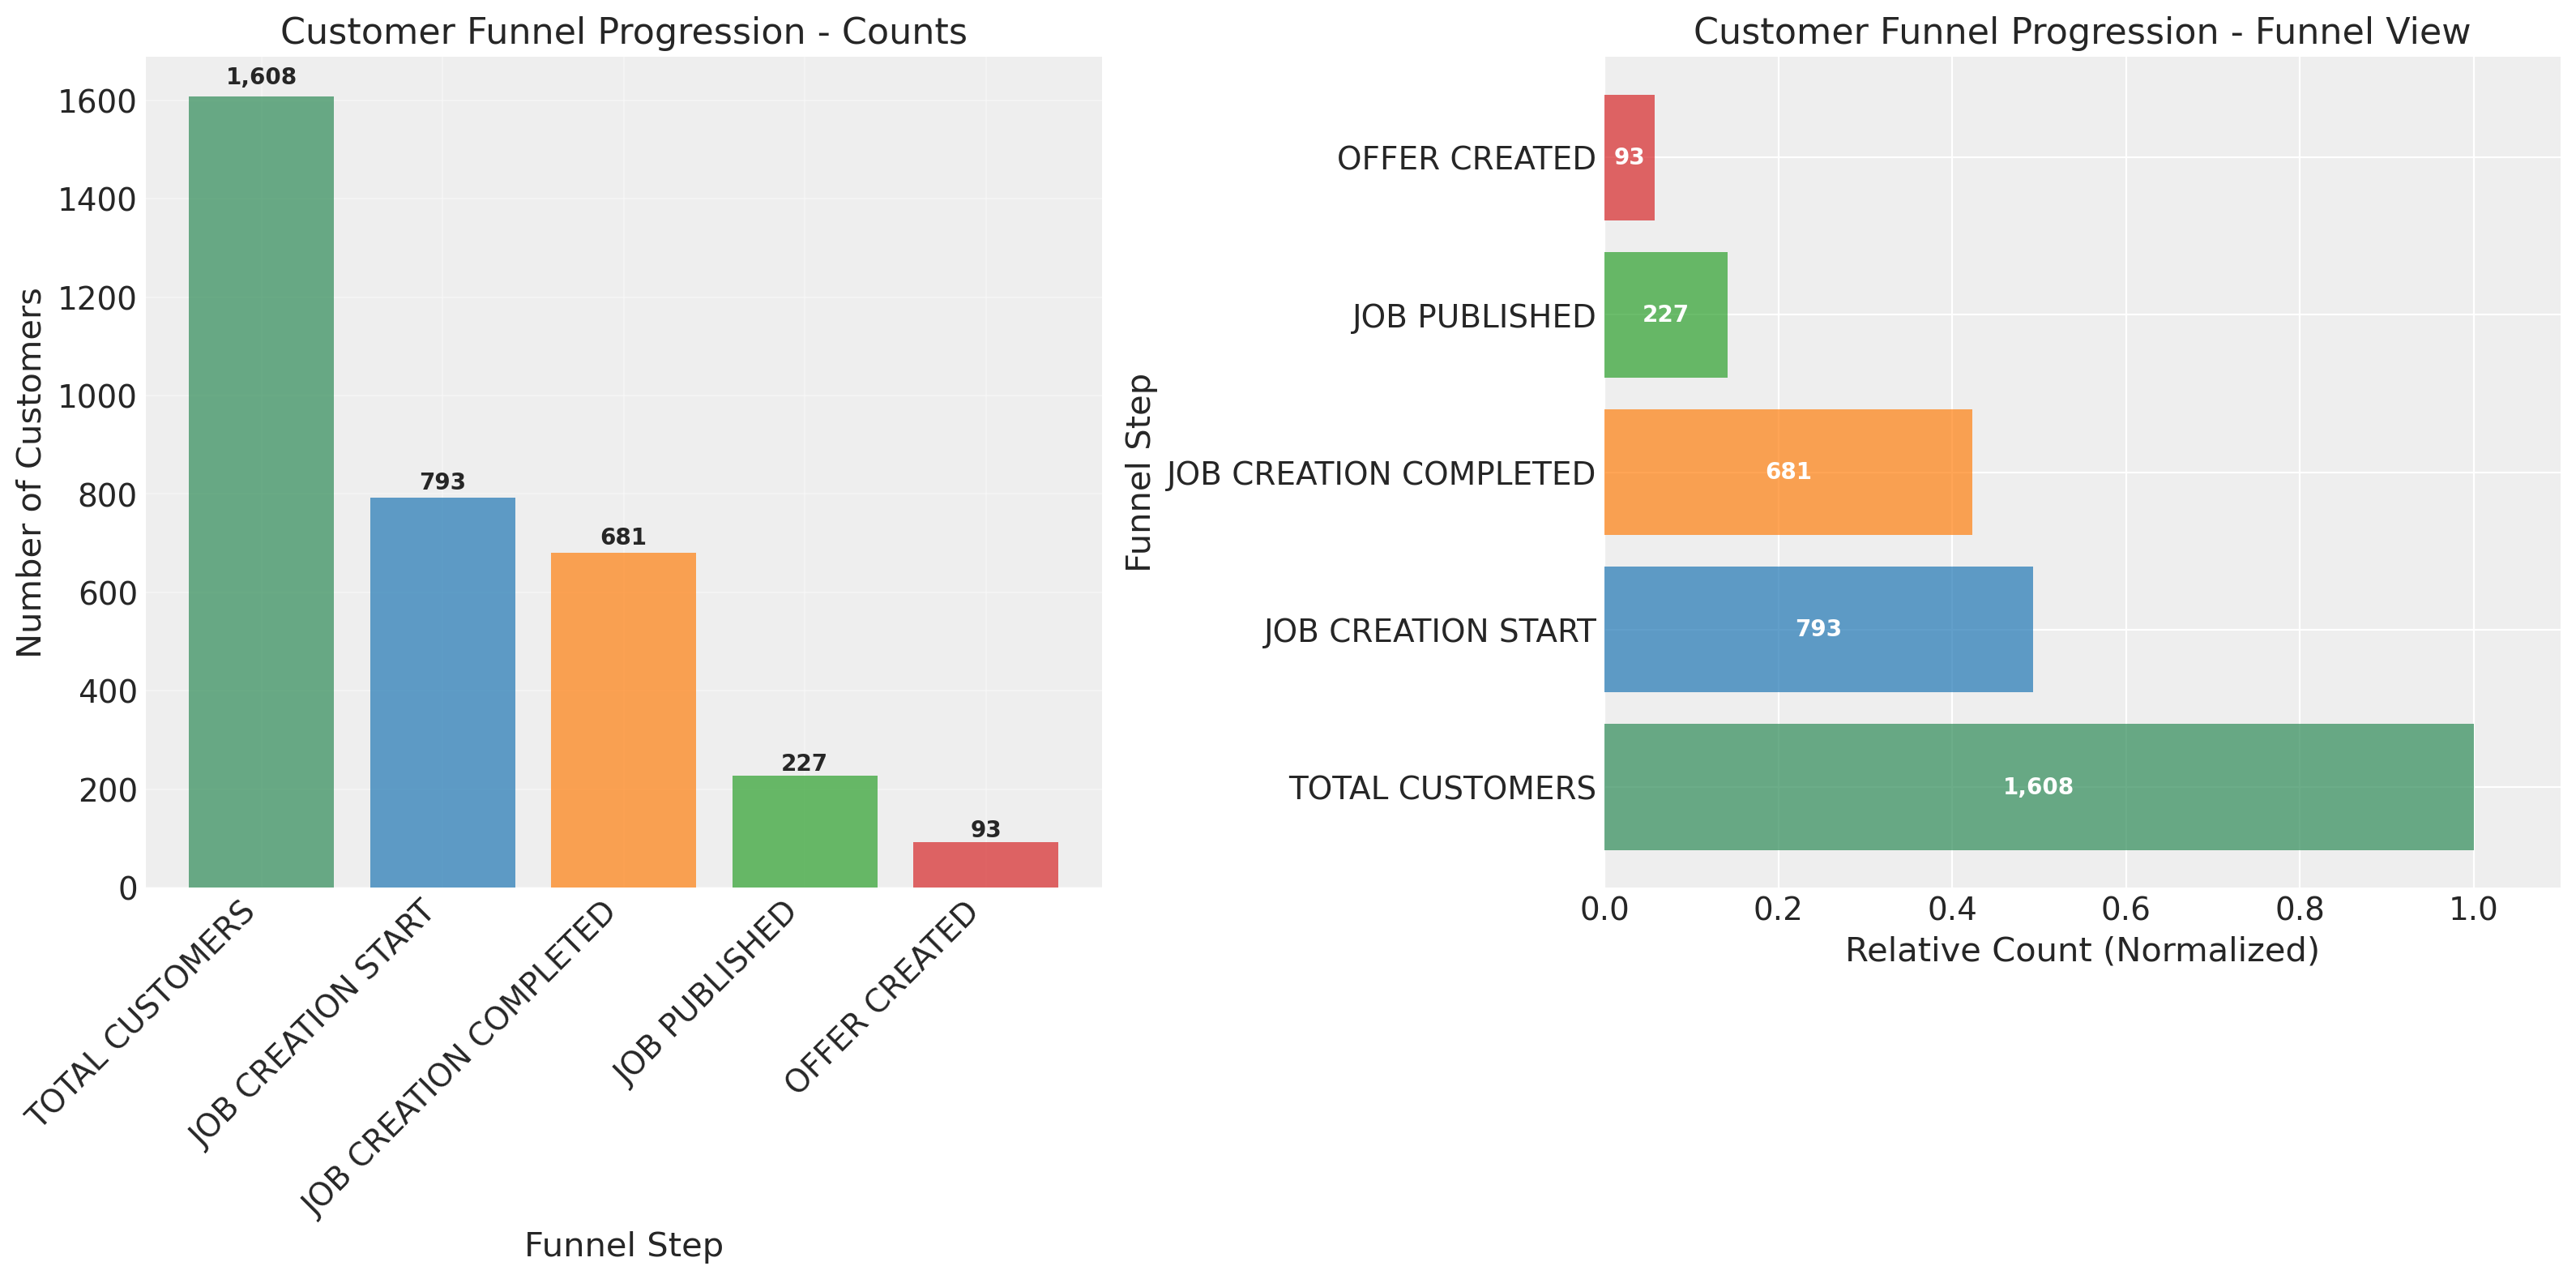

In [65]:
# Create the funnel plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Bar chart showing counts
bars = ax1.bar(
    range(len(funnel_df)),
    funnel_df["count"],
    color=[
        "#2E8B57",
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
    ],  # Added green for step 0
    alpha=0.7,
)
ax1.set_xlabel("Funnel Step")
ax1.set_ylabel("Number of Customers")
ax1.set_title("Customer Funnel Progression - Counts")
ax1.set_xticks(range(len(funnel_df)))
ax1.set_xticklabels(funnel_df["step_name"], rotation=45, ha="right")
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + height * 0.01,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Plot 2: Funnel-style visualization
y_positions = range(len(funnel_df))
widths = funnel_df["count"] / funnel_df["count"].max()  # Normalize widths

# Create funnel bars (decreasing width)
for i, (y, width) in enumerate(zip(y_positions, widths, strict=False)):
    ax2.barh(
        y,
        width,
        height=0.8,
        color=["#2E8B57", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"][
            i
        ],  # Added green for step 0
        alpha=0.7,
    )

    # Add labels
    ax2.text(
        width / 2,
        y,
        f"{funnel_df.iloc[i]['count']:,}",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",
    )

ax2.set_xlabel("Relative Count (Normalized)")
ax2.set_ylabel("Funnel Step")
ax2.set_title("Customer Funnel Progression - Funnel View")
ax2.set_yticks(y_positions)
ax2.set_yticklabels(funnel_df["step_name"])
ax2.set_xlim(0, 1.1)

plt.tight_layout()
plt.show()

In [56]:
# Calculate conversion rates between steps
print("\nConversion Rates Between Steps:")
print("=" * 40)
for i in range(1, len(funnel_df)):
    current_count = funnel_df.iloc[i]["count"]
    previous_count = funnel_df.iloc[i - 1]["count"]
    conversion_rate = (
        (current_count / previous_count) * 100 if previous_count > 0 else 0
    )
    print(
        f"{funnel_df.iloc[i - 1]['step_name']} → {funnel_df.iloc[i]['step_name']}: {conversion_rate:.1f}% ({current_count:,}/{previous_count:,})"
    )

# Overall conversion rate
overall_conversion = (funnel_df.iloc[-1]["count"] / funnel_df.iloc[0]["count"]) * 100
print(
    f"\nOverall Conversion ({funnel_df.iloc[0]['step_name']} → {funnel_df.iloc[-1]['step_name']}): {overall_conversion:.1f}% ({funnel_df.iloc[-1]['count']:,}/{funnel_df.iloc[0]['count']:,})"
)



Conversion Rates Between Steps:
TOTAL CUSTOMERS → JOB CREATION START: 49.3% (793/1,608)
JOB CREATION START → JOB CREATION COMPLETED: 85.9% (681/793)
JOB CREATION COMPLETED → JOB PUBLISHED: 33.3% (227/681)
JOB PUBLISHED → OFFER CREATED: 41.0% (93/227)

Overall Conversion (TOTAL CUSTOMERS → OFFER CREATED): 5.8% (93/1,608)


In [67]:
100 * 681 / 1608

42.350746268656714

## job creation step deep dive

In [104]:
all_events_raw = events.pivot(
    index="CUSTOMER_ID", columns="EVENT", values="EVENT_DATE"
).reset_index()

cust_job_events = pd.merge(customers, all_events_raw, on="CUSTOMER_ID", how="left")

cust_job_events.columns


Index(['CUSTOMER_ID', 'COUNTRY', 'NO_EMPLOYEES', 'IS_STILL_CUSTOMER',
       'PURCHASED_AS_NEW_CUSTOMER', 'INDUSTRY_CLUSTER', 'PURCHASE_DATE',
       'PURCHASE_MONTH', 'COUNTRY_GROUP', 'FIRST_JOB_CREATION_COMPLETED_AT',
       'FIRST_JOB_CREATION_STARTED_AT', 'FIRST_JOB_PUBLISHED_AT',
       'FIRST_OFFER_CREATED_AT'],
      dtype='object')

FIRST_JOB_CREATION_STARTED_AT
count                           793
mean     29 days 14:53:25.044136191
std      36 days 14:41:15.939188561
min             -105 days +00:00:00
25%                 5 days 00:00:00
50%                20 days 00:00:00
75%                44 days 00:00:00
max               199 days 00:00:00
Name: AGE_IN_DAYS, dtype: object
Percentage of customers who fired the event within 3*30 days:
93.19041614123581


Percentage of customers who fired the event within 4*30 days:
97.09962168978562




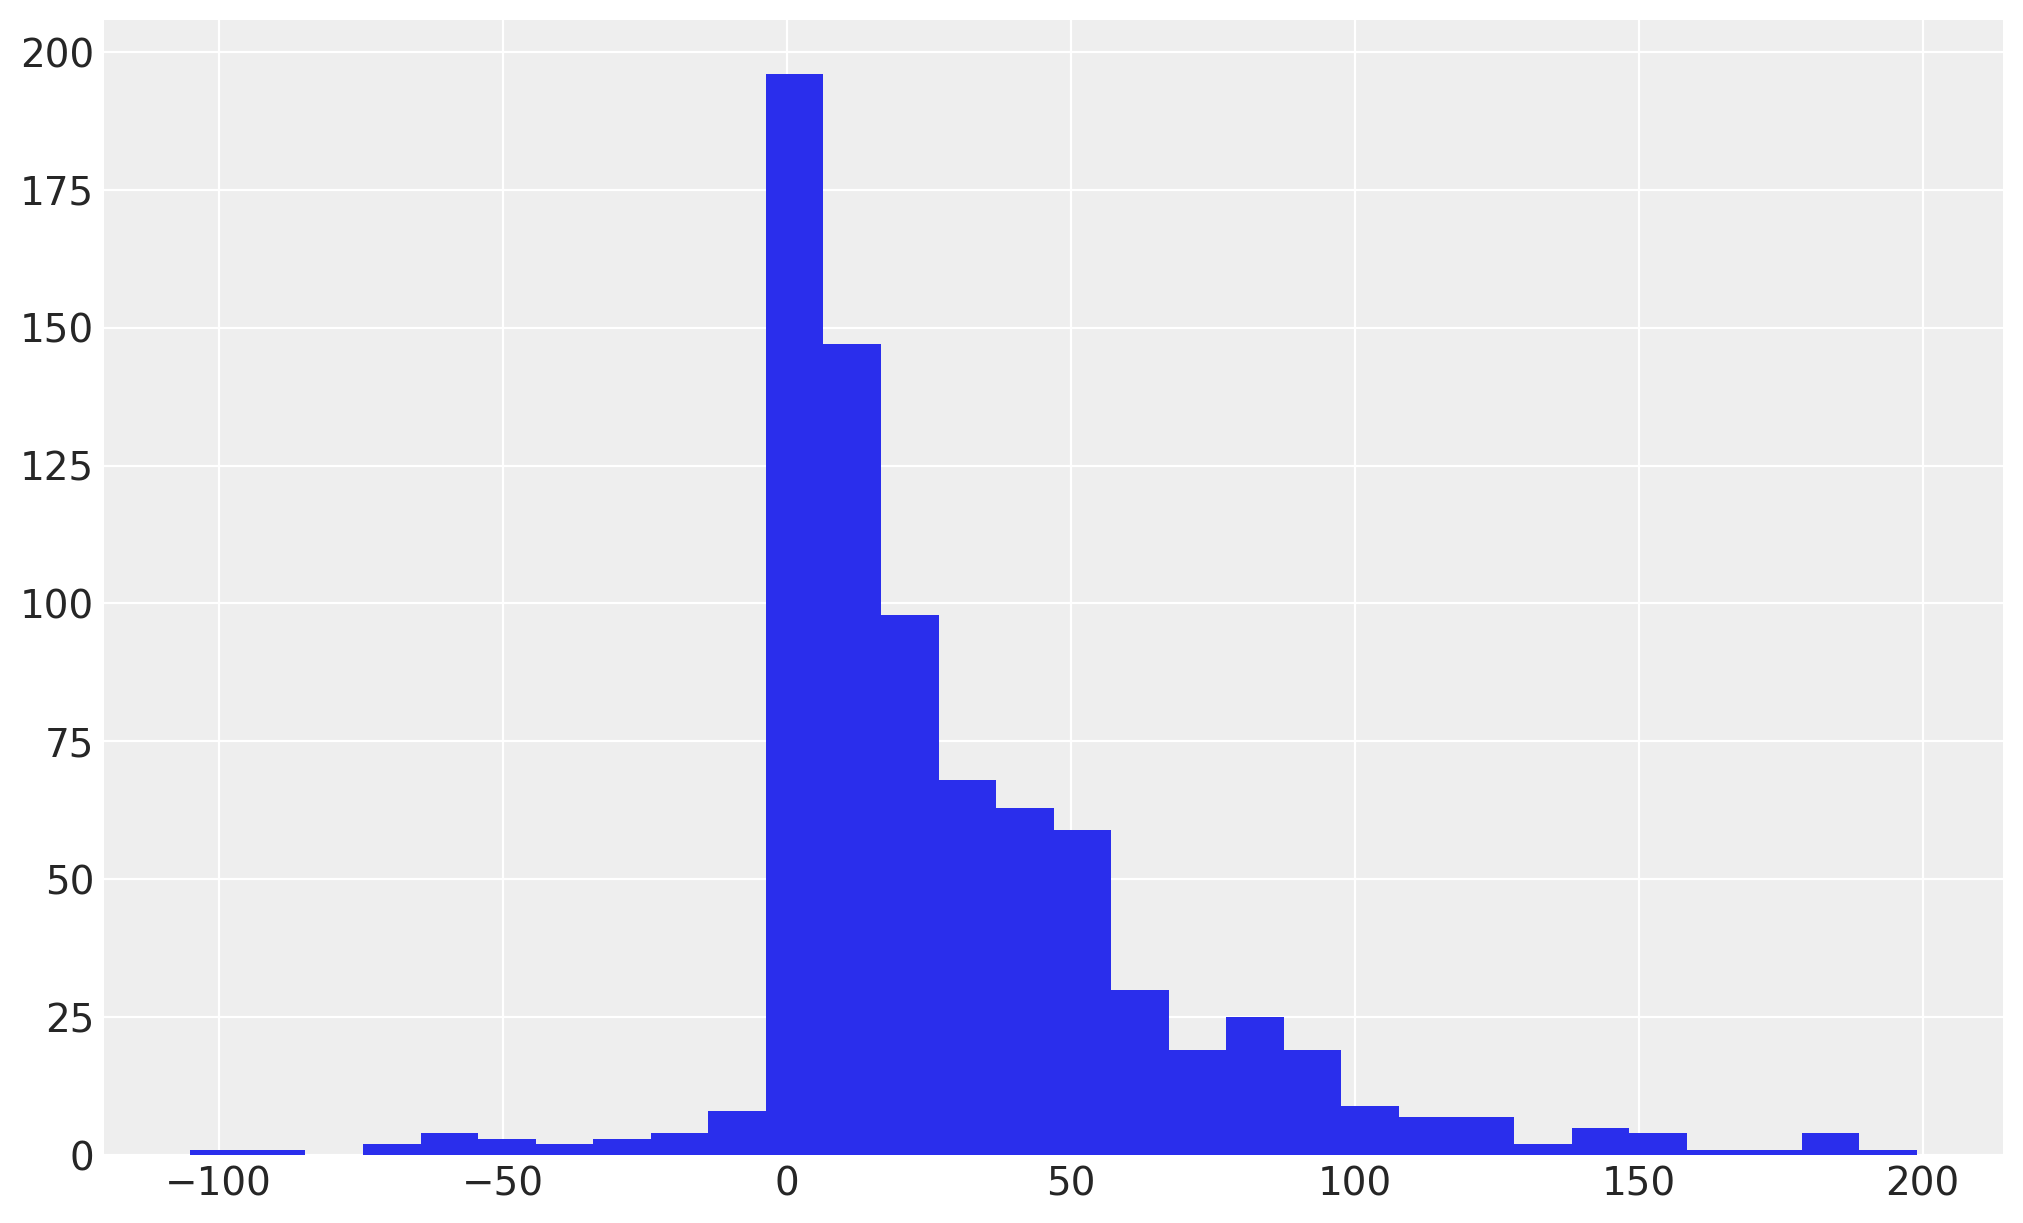



FIRST_JOB_CREATION_COMPLETED_AT
count                           681
mean     33 days 19:20:52.863436123
std      36 days 02:00:27.627468407
min              -94 days +00:00:00
25%                 7 days 00:00:00
50%                24 days 00:00:00
75%                51 days 00:00:00
max               185 days 00:00:00
Name: AGE_IN_DAYS, dtype: object
Percentage of customers who fired the event within 3*30 days:
91.77679882525698


Percentage of customers who fired the event within 4*30 days:
96.76945668135095




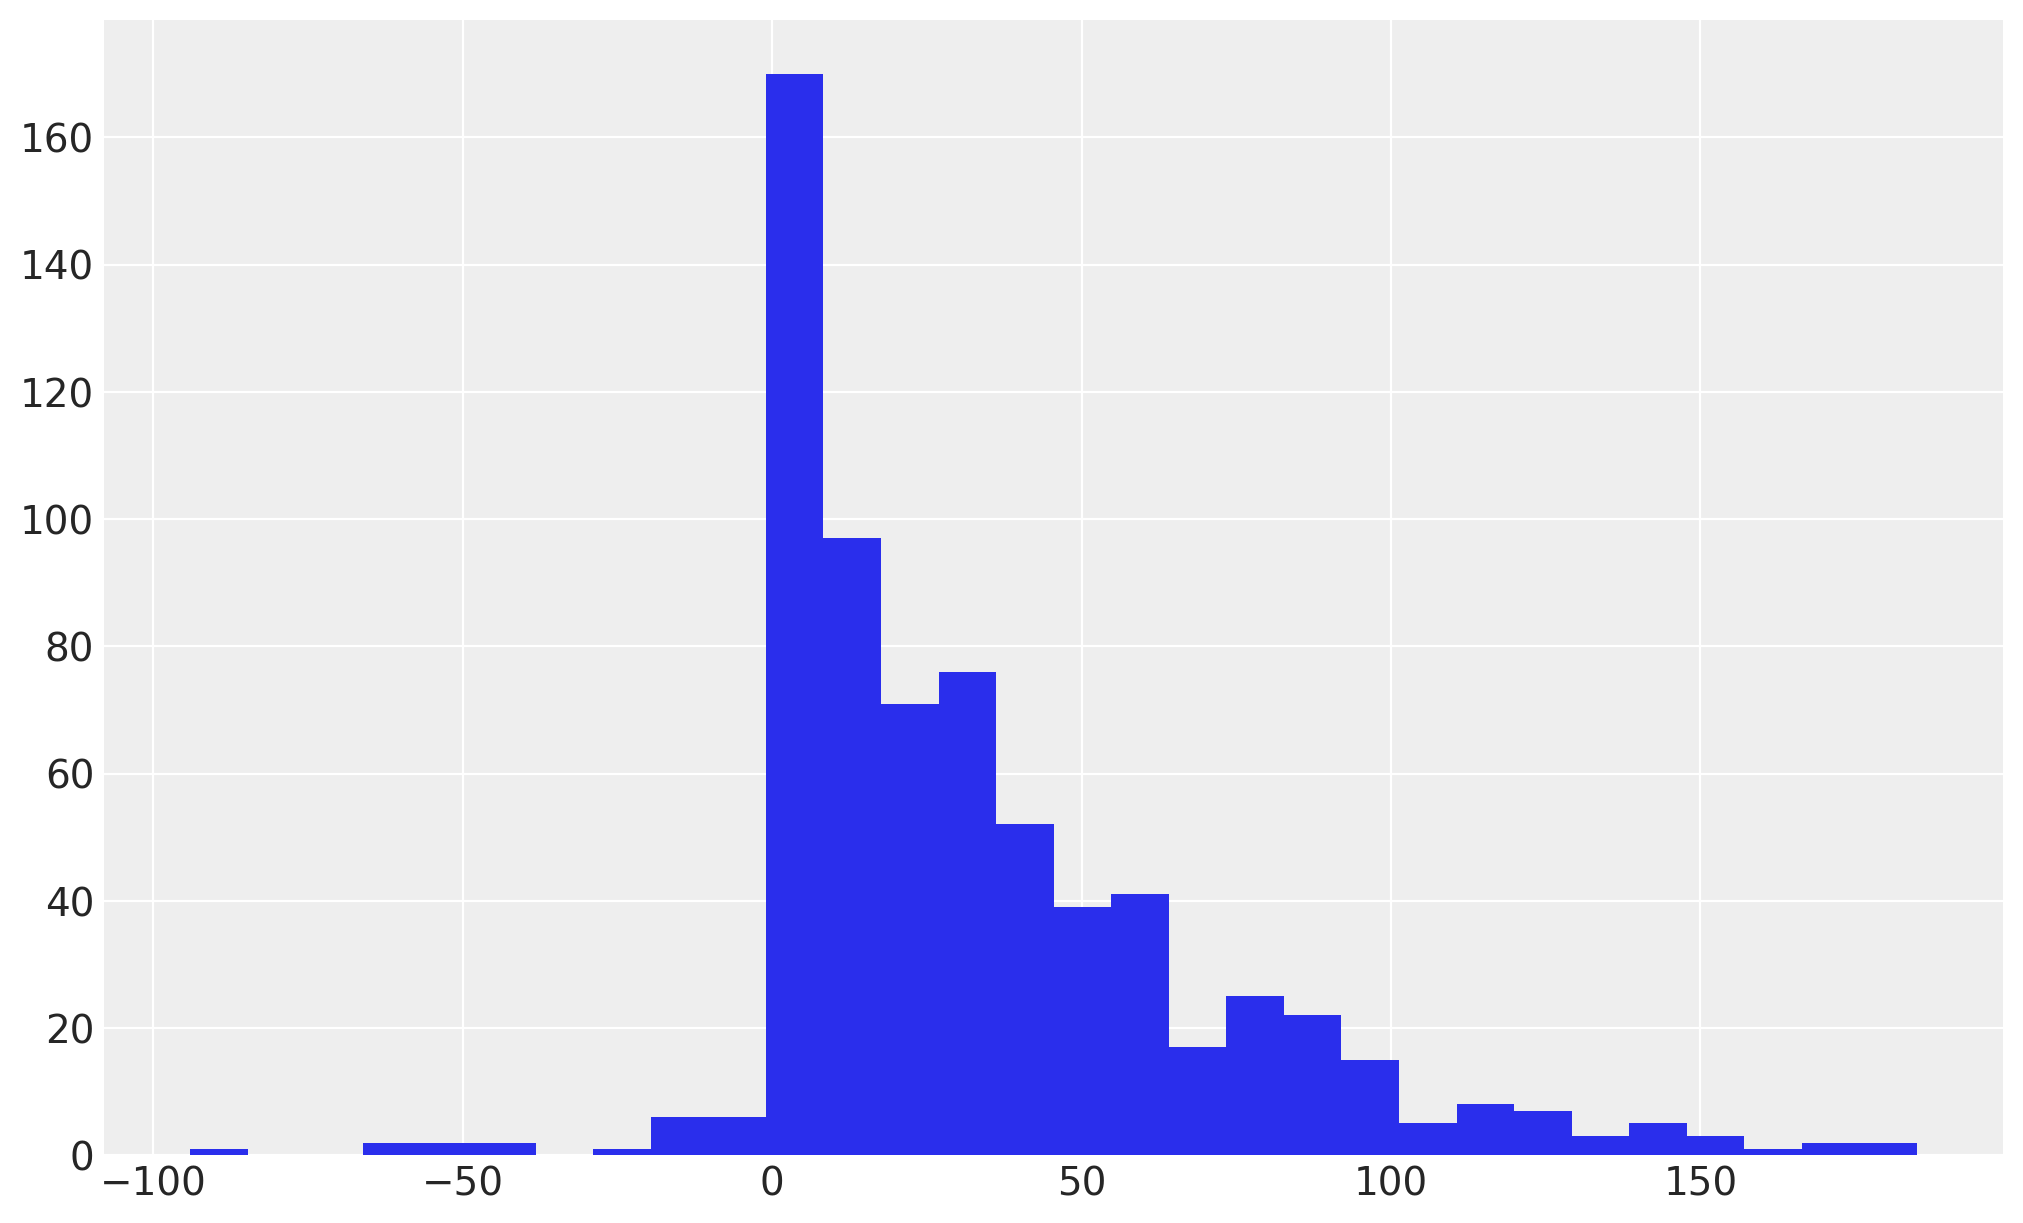



FIRST_JOB_PUBLISHED_AT
count                           227
mean     49 days 10:21:40.440528634
std      40 days 07:03:43.597810124
min              -89 days +00:00:00
25%                19 days 00:00:00
50%                40 days 00:00:00
75%                70 days 00:00:00
max               189 days 00:00:00
Name: AGE_IN_DAYS, dtype: object
Percentage of customers who fired the event within 3*30 days:
85.02202643171806


Percentage of customers who fired the event within 4*30 days:
94.7136563876652




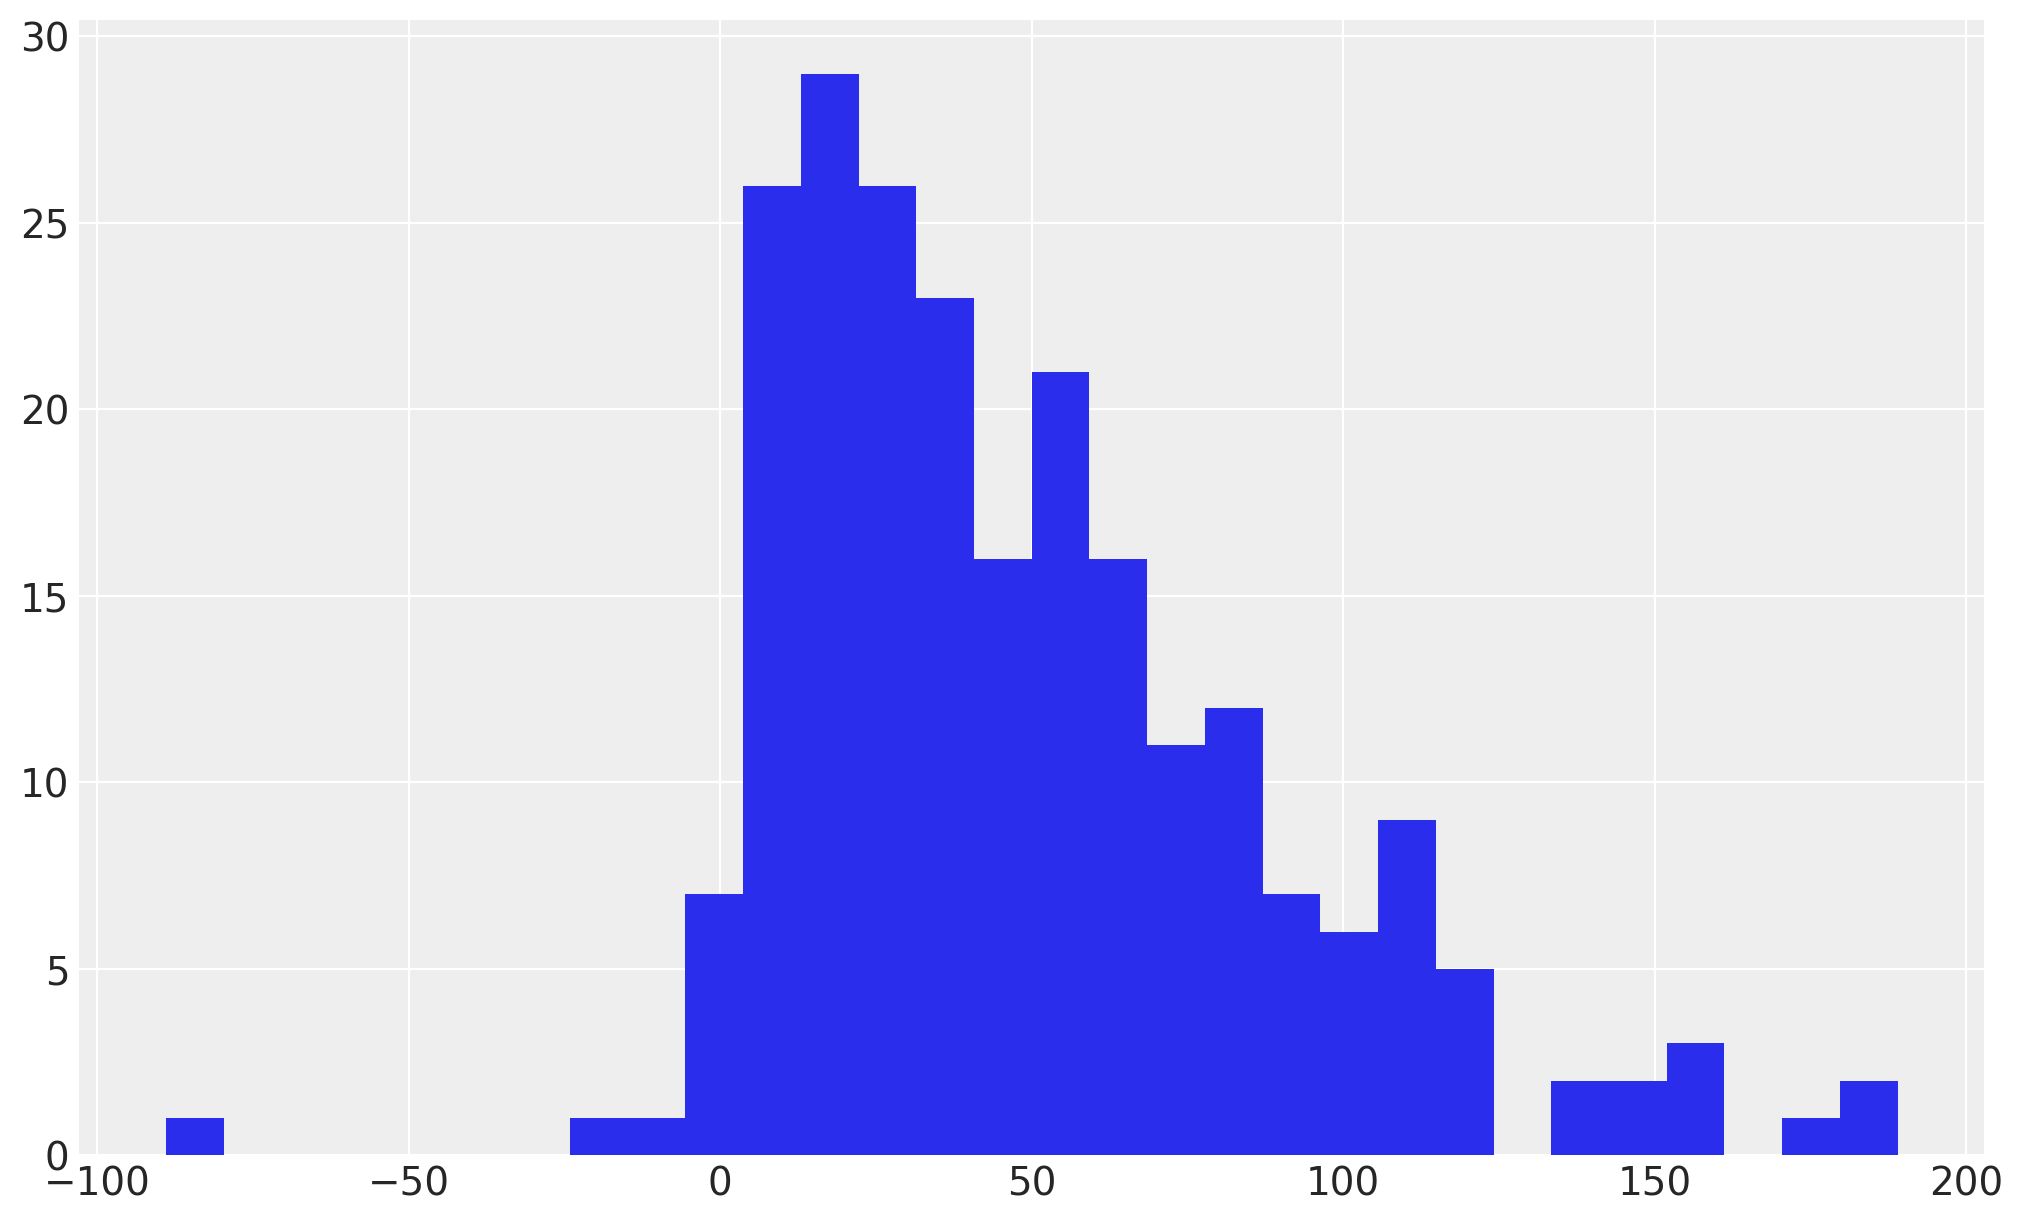



FIRST_OFFER_CREATED_AT
count                            93
mean     73 days 04:54:11.612903226
std      41 days 22:09:25.443716642
min              -38 days +00:00:00
25%                41 days 00:00:00
50%                66 days 00:00:00
75%                96 days 00:00:00
max               179 days 00:00:00
Name: AGE_IN_DAYS, dtype: object
Percentage of customers who fired the event within 3*30 days:
70.96774193548387


Percentage of customers who fired the event within 4*30 days:
84.94623655913979




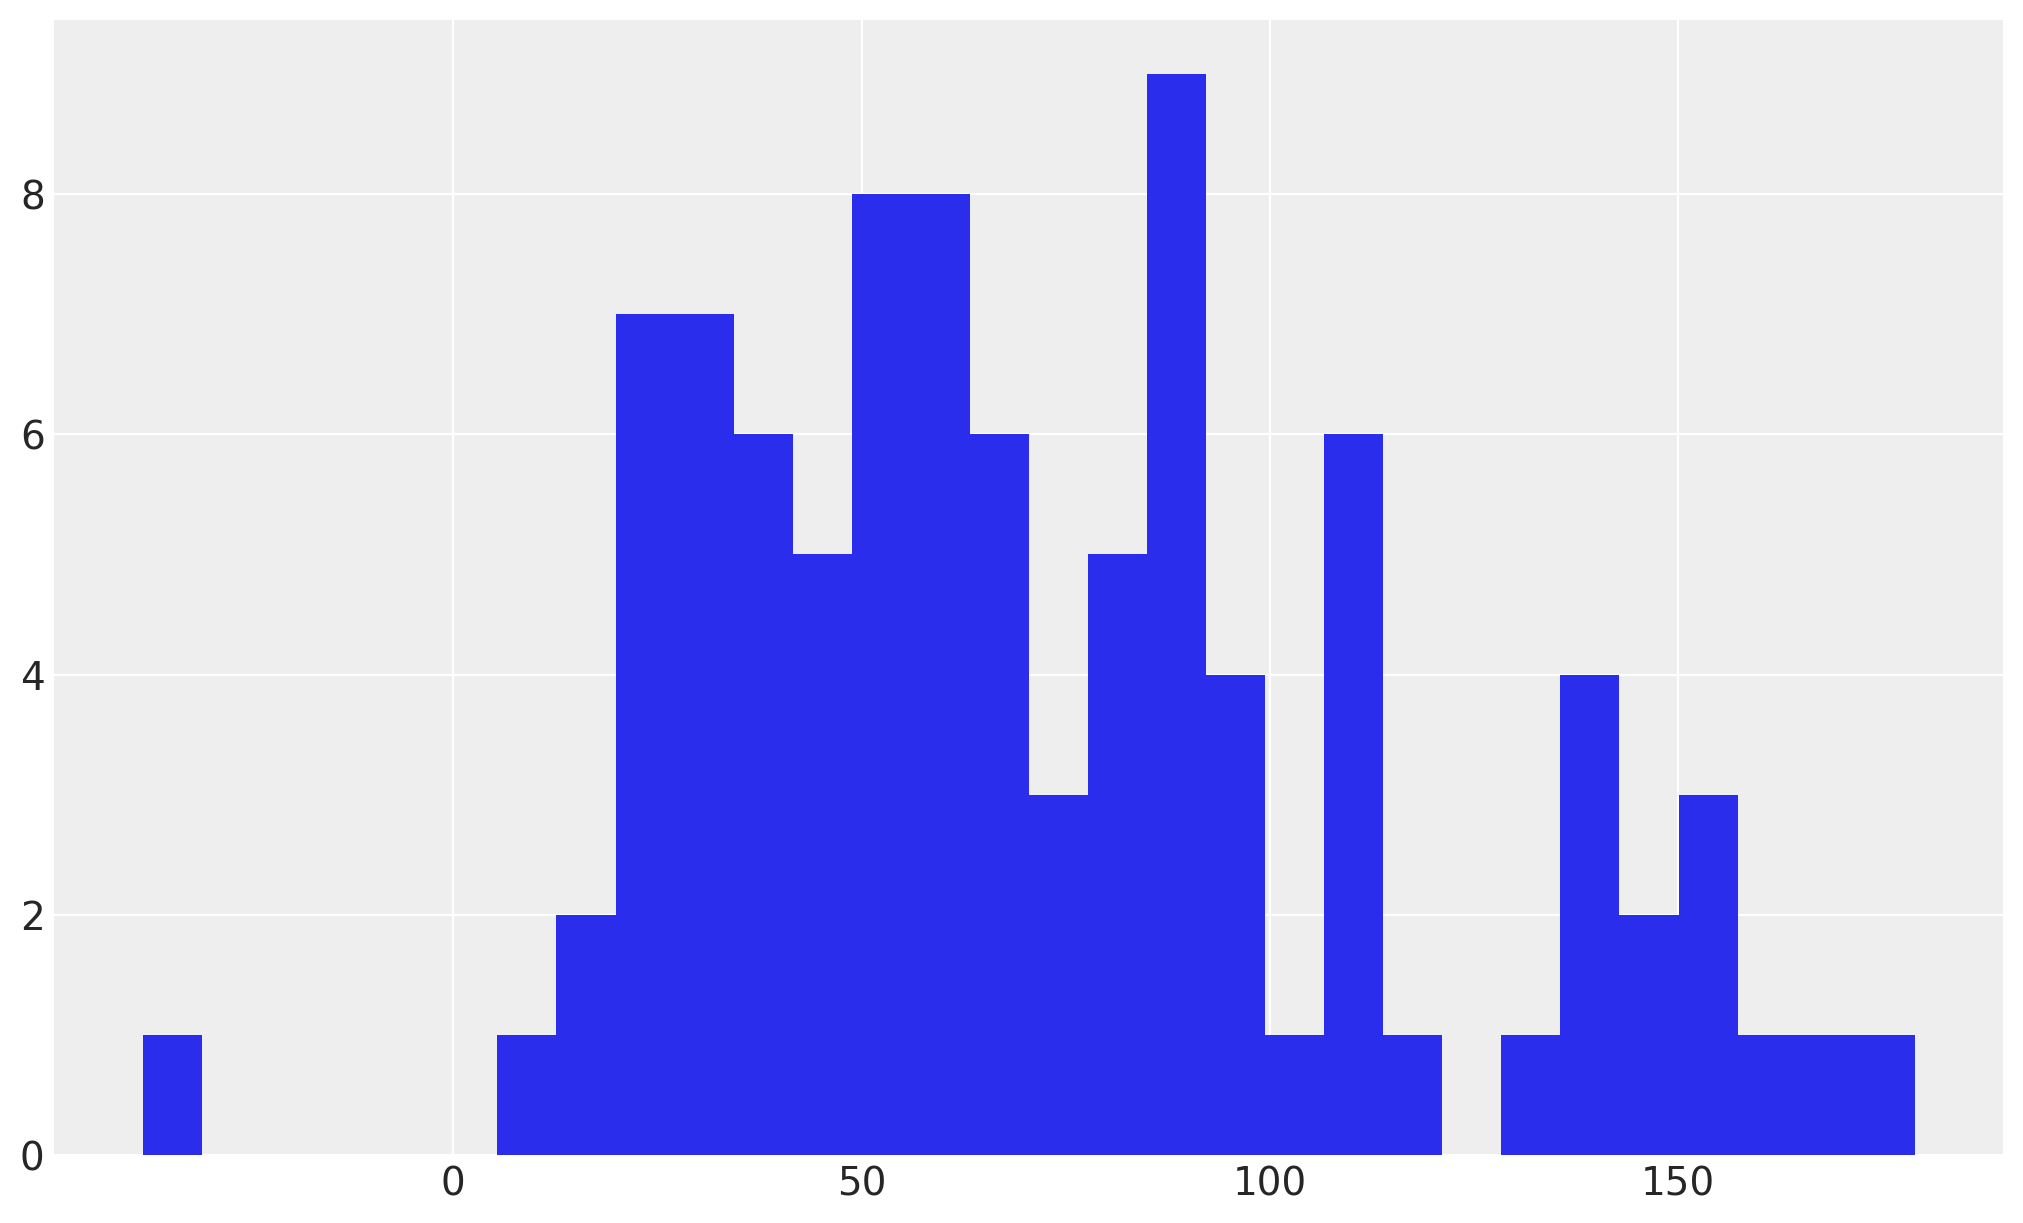

In [162]:
for col in [
    "FIRST_JOB_CREATION_STARTED_AT",
    "FIRST_JOB_CREATION_COMPLETED_AT",
    "FIRST_JOB_PUBLISHED_AT",
    "FIRST_OFFER_CREATED_AT",
]:
    cust_age_df_start = cust_job_events[["PURCHASE_DATE", col]].dropna()

    cust_age_df_start["AGE_IN_DAYS"] = (
        cust_age_df_start[col] - cust_age_df_start["PURCHASE_DATE"]
    )
    print(col)
    print(cust_age_df_start["AGE_IN_DAYS"].describe())
    print("Percentage of customers who fired the event within 3*30 days:")
    print(100.0 * (cust_age_df_start["AGE_IN_DAYS"].dt.days <= 90).mean())
    print("\n")
    print("Percentage of customers who fired the event within 4*30 days:")
    print(100.0 * (cust_age_df_start["AGE_IN_DAYS"].dt.days <= 120).mean())
    print("\n")
    cust_age_df_start["AGE_IN_DAYS"].dt.days.hist(bins=30)
    plt.show()
    print("\n")


# Cohort Analysis: Job Creation Started by Purchase Month


In [96]:
# Create a cohort analysis with PURCHASE_MONTH as cohort
# Calculate the proportion of customers in each cohort that have a non-null FIRST_JOB_CREATION_STARTED_AT

# First, let's create a dataset that identifies which customers have started job creation
job_creation_started = events[events["EVENT"] == "FIRST_JOB_CREATION_STARTED_AT"][
    ["CUSTOMER_ID"]
].drop_duplicates()
job_creation_started["HAS_STARTED_JOB_CREATION"] = True

# Merge with customers data to get purchase month information
cohort_data = pd.merge(
    customers[["CUSTOMER_ID", "PURCHASE_MONTH"]],
    job_creation_started,
    on="CUSTOMER_ID",
    how="left",
)

# Fill NaN values with False for customers who haven't started job creation
cohort_data["HAS_STARTED_JOB_CREATION"] = cohort_data[
    "HAS_STARTED_JOB_CREATION"
].fillna(False)

print("Cohort Data Sample:")
print(cohort_data.head())
print(f"\nTotal customers: {len(cohort_data)}")
print(
    f"Customers who started job creation: {cohort_data['HAS_STARTED_JOB_CREATION'].sum()}"
)
print(
    f"Overall job creation rate: {cohort_data['HAS_STARTED_JOB_CREATION'].mean():.3f}"
)


Cohort Data Sample:
                        CUSTOMER_ID PURCHASE_MONTH  HAS_STARTED_JOB_CREATION
0  019acc43b90db17385b4cc5e201635e4        2023-01                      True
1  0b50a0ea27a1076ea139fe271673d5a1        2023-01                      True
2  172f92934eae8bf32b31f4ad2609dc34        2023-01                     False
3  1e1430c902e49b2378830d0754303d4c        2023-01                      True
4  21a8ea62ecc6da2937e8c840e338c71d        2023-01                      True

Total customers: 1608
Customers who started job creation: 793
Overall job creation rate: 0.493


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/2398320588.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(False)


In [97]:
# Calculate cohort statistics
cohort_analysis = (
    cohort_data.groupby("PURCHASE_MONTH")
    .agg(
        {
            "CUSTOMER_ID": "count",  # Total customers in cohort
            "HAS_STARTED_JOB_CREATION": [
                "sum",
                "mean",
            ],  # Count and proportion who started job creation
        }
    )
    .round(3)
)

# Flatten column names
cohort_analysis.columns = [
    "Total_Customers",
    "Job_Creation_Started_Count",
    "Job_Creation_Started_Rate",
]

# Sort by purchase month
cohort_analysis = cohort_analysis.sort_index()

print("Cohort Analysis Results:")
print("=" * 60)
print(cohort_analysis)


Cohort Analysis Results:
                Total_Customers  Job_Creation_Started_Count  \
PURCHASE_MONTH                                                
2023-01                     259                         159   
2023-02                     188                         103   
2023-03                     224                         123   
2023-04                     305                         164   
2023-05                     215                         110   
2023-06                     219                          83   
2023-07                     198                          51   

                Job_Creation_Started_Rate  
PURCHASE_MONTH                             
2023-01                             0.614  
2023-02                             0.548  
2023-03                             0.549  
2023-04                             0.538  
2023-05                             0.512  
2023-06                             0.379  
2023-07                             0.258  


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/824375524.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


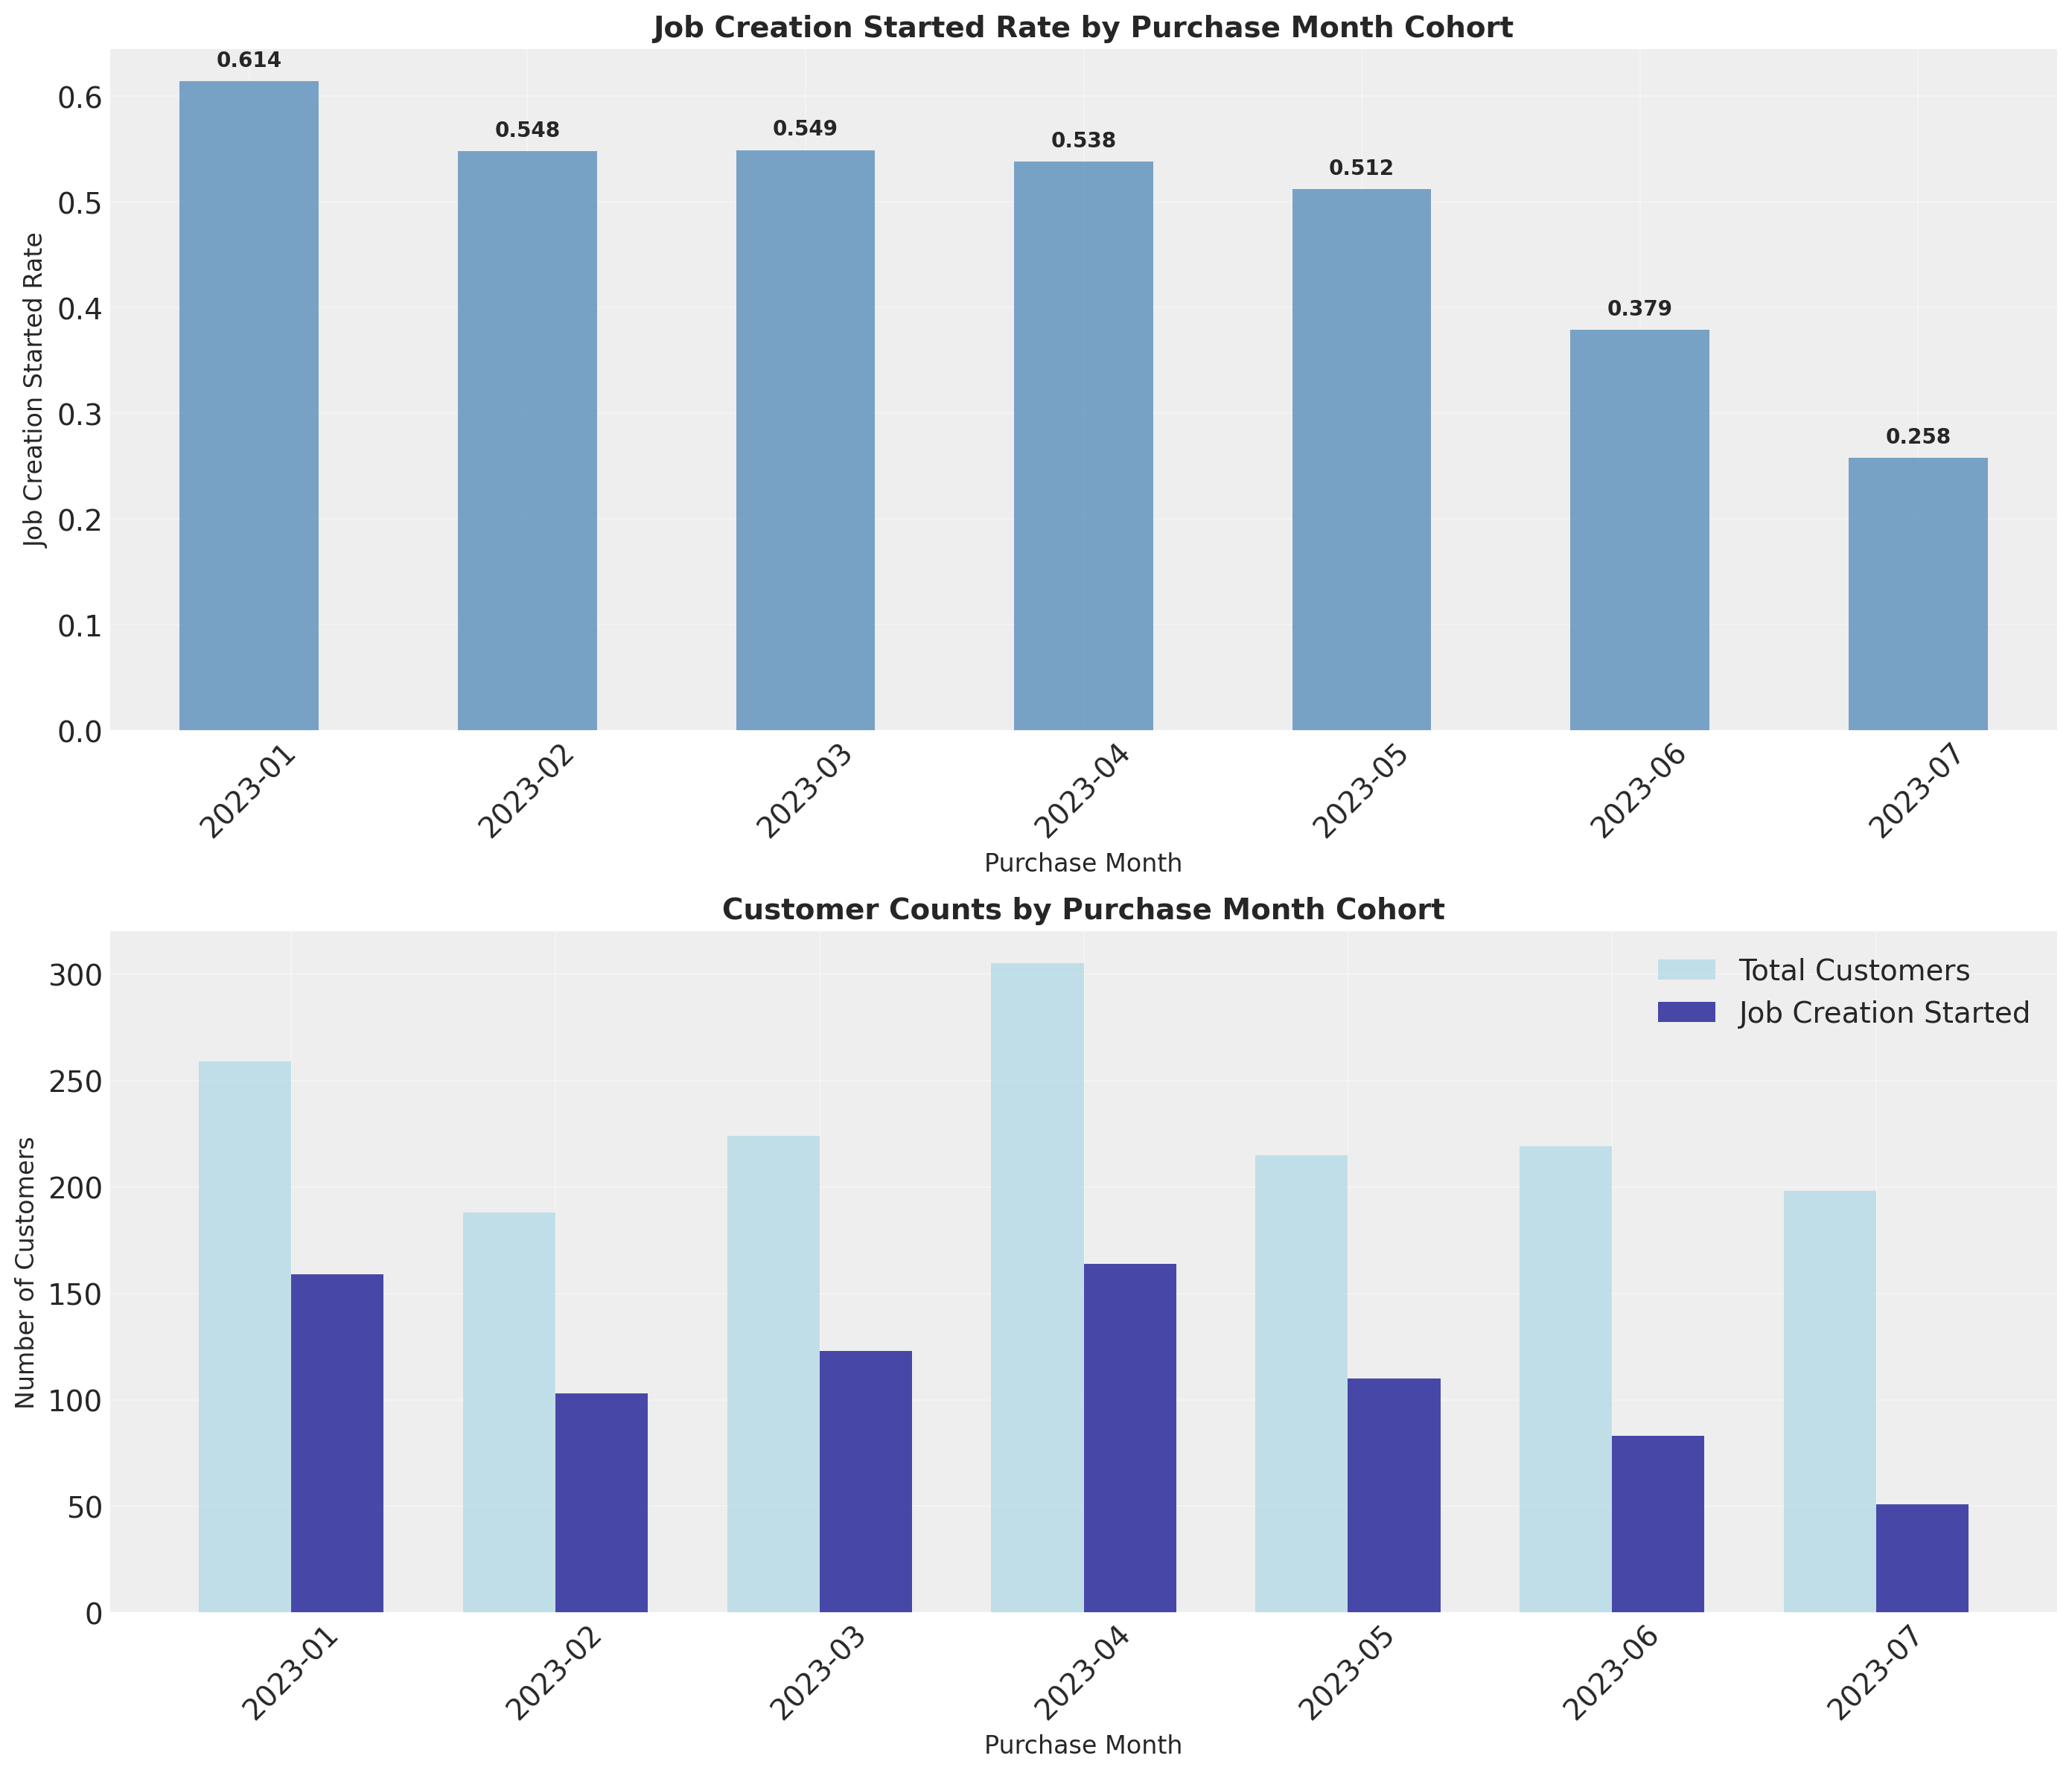

In [98]:
# Create visualizations for the cohort analysis

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Job Creation Rate by Cohort
cohort_analysis["Job_Creation_Started_Rate"].plot(
    kind="bar", ax=ax1, color="steelblue", alpha=0.7
)
ax1.set_title(
    "Job Creation Started Rate by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax1.set_xlabel("Purchase Month", fontsize=12)
ax1.set_ylabel("Job Creation Started Rate", fontsize=12)
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(cohort_analysis["Job_Creation_Started_Rate"]):
    ax1.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontweight="bold")

# Plot 2: Total Customers and Job Creation Started Count by Cohort
x = range(len(cohort_analysis))
width = 0.35

ax2.bar(
    [i - width / 2 for i in x],
    cohort_analysis["Total_Customers"],
    width,
    label="Total Customers",
    color="lightblue",
    alpha=0.7,
)
ax2.bar(
    [i + width / 2 for i in x],
    cohort_analysis["Job_Creation_Started_Count"],
    width,
    label="Job Creation Started",
    color="darkblue",
    alpha=0.7,
)

ax2.set_title(
    "Customer Counts by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax2.set_xlabel("Purchase Month", fontsize=12)
ax2.set_ylabel("Number of Customers", fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(cohort_analysis.index, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [99]:
# Additional analysis: Summary statistics and insights

print("Cohort Analysis Summary:")
print("=" * 50)
print(f"Number of cohorts (purchase months): {len(cohort_analysis)}")
print(
    f"Average job creation rate across all cohorts: {cohort_analysis['Job_Creation_Started_Rate'].mean():.3f}"
)
print(
    f"Standard deviation of job creation rates: {cohort_analysis['Job_Creation_Started_Rate'].std():.3f}"
)
print(
    f"Highest job creation rate: {cohort_analysis['Job_Creation_Started_Rate'].max():.3f} ({cohort_analysis['Job_Creation_Started_Rate'].idxmax()})"
)
print(
    f"Lowest job creation rate: {cohort_analysis['Job_Creation_Started_Rate'].min():.3f} ({cohort_analysis['Job_Creation_Started_Rate'].idxmin()})"
)


Cohort Analysis Summary:
Number of cohorts (purchase months): 7
Average job creation rate across all cohorts: 0.485
Standard deviation of job creation rates: 0.123
Highest job creation rate: 0.614 (2023-01)
Lowest job creation rate: 0.258 (2023-07)


# Comprehensive Cohort Analysis: Funnel Progression by Purchase Month

In [87]:
# Create comprehensive cohort analysis with all funnel steps
# Using the funnel_events and step_names from the existing analysis

# Define funnel events and step names (reusing from existing code)
funnel_events = [
    "FIRST_JOB_CREATION_STARTED_AT",
    "FIRST_JOB_CREATION_COMPLETED_AT",
    "FIRST_JOB_PUBLISHED_AT",
    "FIRST_OFFER_CREATED_AT",
]

step_names = [
    "TOTAL CUSTOMERS",
    "JOB CREATION START",
    "JOB CREATION COMPLETED",
    "JOB PUBLISHED",
    "OFFER CREATED",
]

# Create a comprehensive dataset for cohort analysis
# Start with all customers and their purchase months
cohort_funnel_data = customers[["CUSTOMER_ID", "PURCHASE_MONTH"]].copy()

# Add a column for total customers (always True)
cohort_funnel_data["TOTAL_CUSTOMERS"] = True

# For each funnel event, create a binary indicator
for event in funnel_events:
    # Get customers who have this event
    event_customers = events[events["EVENT"] == event][
        ["CUSTOMER_ID"]
    ].drop_duplicates()
    event_customers[event] = True

    # Merge with cohort data
    cohort_funnel_data = pd.merge(
        cohort_funnel_data, event_customers, on="CUSTOMER_ID", how="left"
    )

    # Fill NaN values with False
    cohort_funnel_data[event] = cohort_funnel_data[event].fillna(False)

print("Cohort Funnel Data Sample:")
print(cohort_funnel_data.head())
print(f"\nData shape: {cohort_funnel_data.shape}")
print(f"\nColumns: {list(cohort_funnel_data.columns)}")


Cohort Funnel Data Sample:
                        CUSTOMER_ID PURCHASE_MONTH  TOTAL_CUSTOMERS  \
0  019acc43b90db17385b4cc5e201635e4        2023-01             True   
1  0b50a0ea27a1076ea139fe271673d5a1        2023-01             True   
2  172f92934eae8bf32b31f4ad2609dc34        2023-01             True   
3  1e1430c902e49b2378830d0754303d4c        2023-01             True   
4  21a8ea62ecc6da2937e8c840e338c71d        2023-01             True   

   FIRST_JOB_CREATION_STARTED_AT  FIRST_JOB_CREATION_COMPLETED_AT  \
0                           True                            False   
1                           True                             True   
2                          False                            False   
3                           True                             True   
4                           True                             True   

   FIRST_JOB_PUBLISHED_AT  FIRST_OFFER_CREATED_AT  
0                   False                   False  
1                    True  

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/1611725404.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cohort_funnel_data[event] = cohort_funnel_data[event].fillna(False)
/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/1611725404.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cohort_funnel_data[event] = cohort_funnel_data[event].fillna(False)
/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/1611725404.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

In [93]:
# Calculate cohort statistics for each funnel step
cohort_columns = ["TOTAL_CUSTOMERS"] + funnel_events

# Group by purchase month and calculate counts and proportions for each step
cohort_stats = (
    cohort_funnel_data.groupby("PURCHASE_MONTH")[cohort_columns]
    .agg(["count", "sum", "mean"])
    .round(3)
)

# Flatten the multi-level columns
cohort_stats.columns = [f"{col[0]}_{col[1]}" for col in cohort_stats.columns]

# Rename columns to be more readable
column_mapping = {}
for i, step in enumerate(step_names):
    step_lower = step.lower().replace(" ", "_")
    column_mapping["TOTAL_CUSTOMERS_count"] = "Total_Customers"
    if i > 0:
        event = funnel_events[i - 1]
        column_mapping[f"{event}_count"] = f"{step}_Base_Count"
        column_mapping[f"{event}_sum"] = f"{step}_Reached_Count"
        column_mapping[f"{event}_mean"] = f"{step}_Rate"

# Apply the mapping
cohort_stats = cohort_stats.rename(columns=column_mapping)

# Sort by purchase month
cohort_stats = cohort_stats.sort_index()

print("Comprehensive Cohort Analysis Results:")
print("=" * 80)
print(cohort_stats)


Comprehensive Cohort Analysis Results:
                Total_Customers  TOTAL_CUSTOMERS_sum  TOTAL_CUSTOMERS_mean  \
PURCHASE_MONTH                                                               
2023-01                     259                  259                   1.0   
2023-02                     188                  188                   1.0   
2023-03                     224                  224                   1.0   
2023-04                     305                  305                   1.0   
2023-05                     215                  215                   1.0   
2023-06                     219                  219                   1.0   
2023-07                     198                  198                   1.0   

                JOB CREATION START_Base_Count  \
PURCHASE_MONTH                                  
2023-01                                   259   
2023-02                                   188   
2023-03                                   224   
2023-04      

In [95]:
cohort_print_cols = [
    "Total_Customers",
    "JOB CREATION START_Rate",
    "JOB CREATION COMPLETED_Rate",
    "JOB PUBLISHED_Rate",
    "OFFER CREATED_Rate",
]
cohort_stats[cohort_print_cols]

,Total_Customers,JOB CREATION START_Rate,JOB CREATION COMPLETED_Rate,JOB PUBLISHED_Rate,OFFER CREATED_Rate
PURCHASE_MONTH,,,,,
2023-01,259,0.614,0.548,0.208,0.104
2023-02,188,0.548,0.495,0.176,0.090
2023-03,224,0.549,0.500,0.152,0.080
2023-04,305,0.538,0.469,0.180,0.056
2023-05,215,0.512,0.428,0.135,0.042
2023-06,219,0.379,0.301,0.073,0.018
2023-07,198,0.258,0.167,0.030,0.005


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

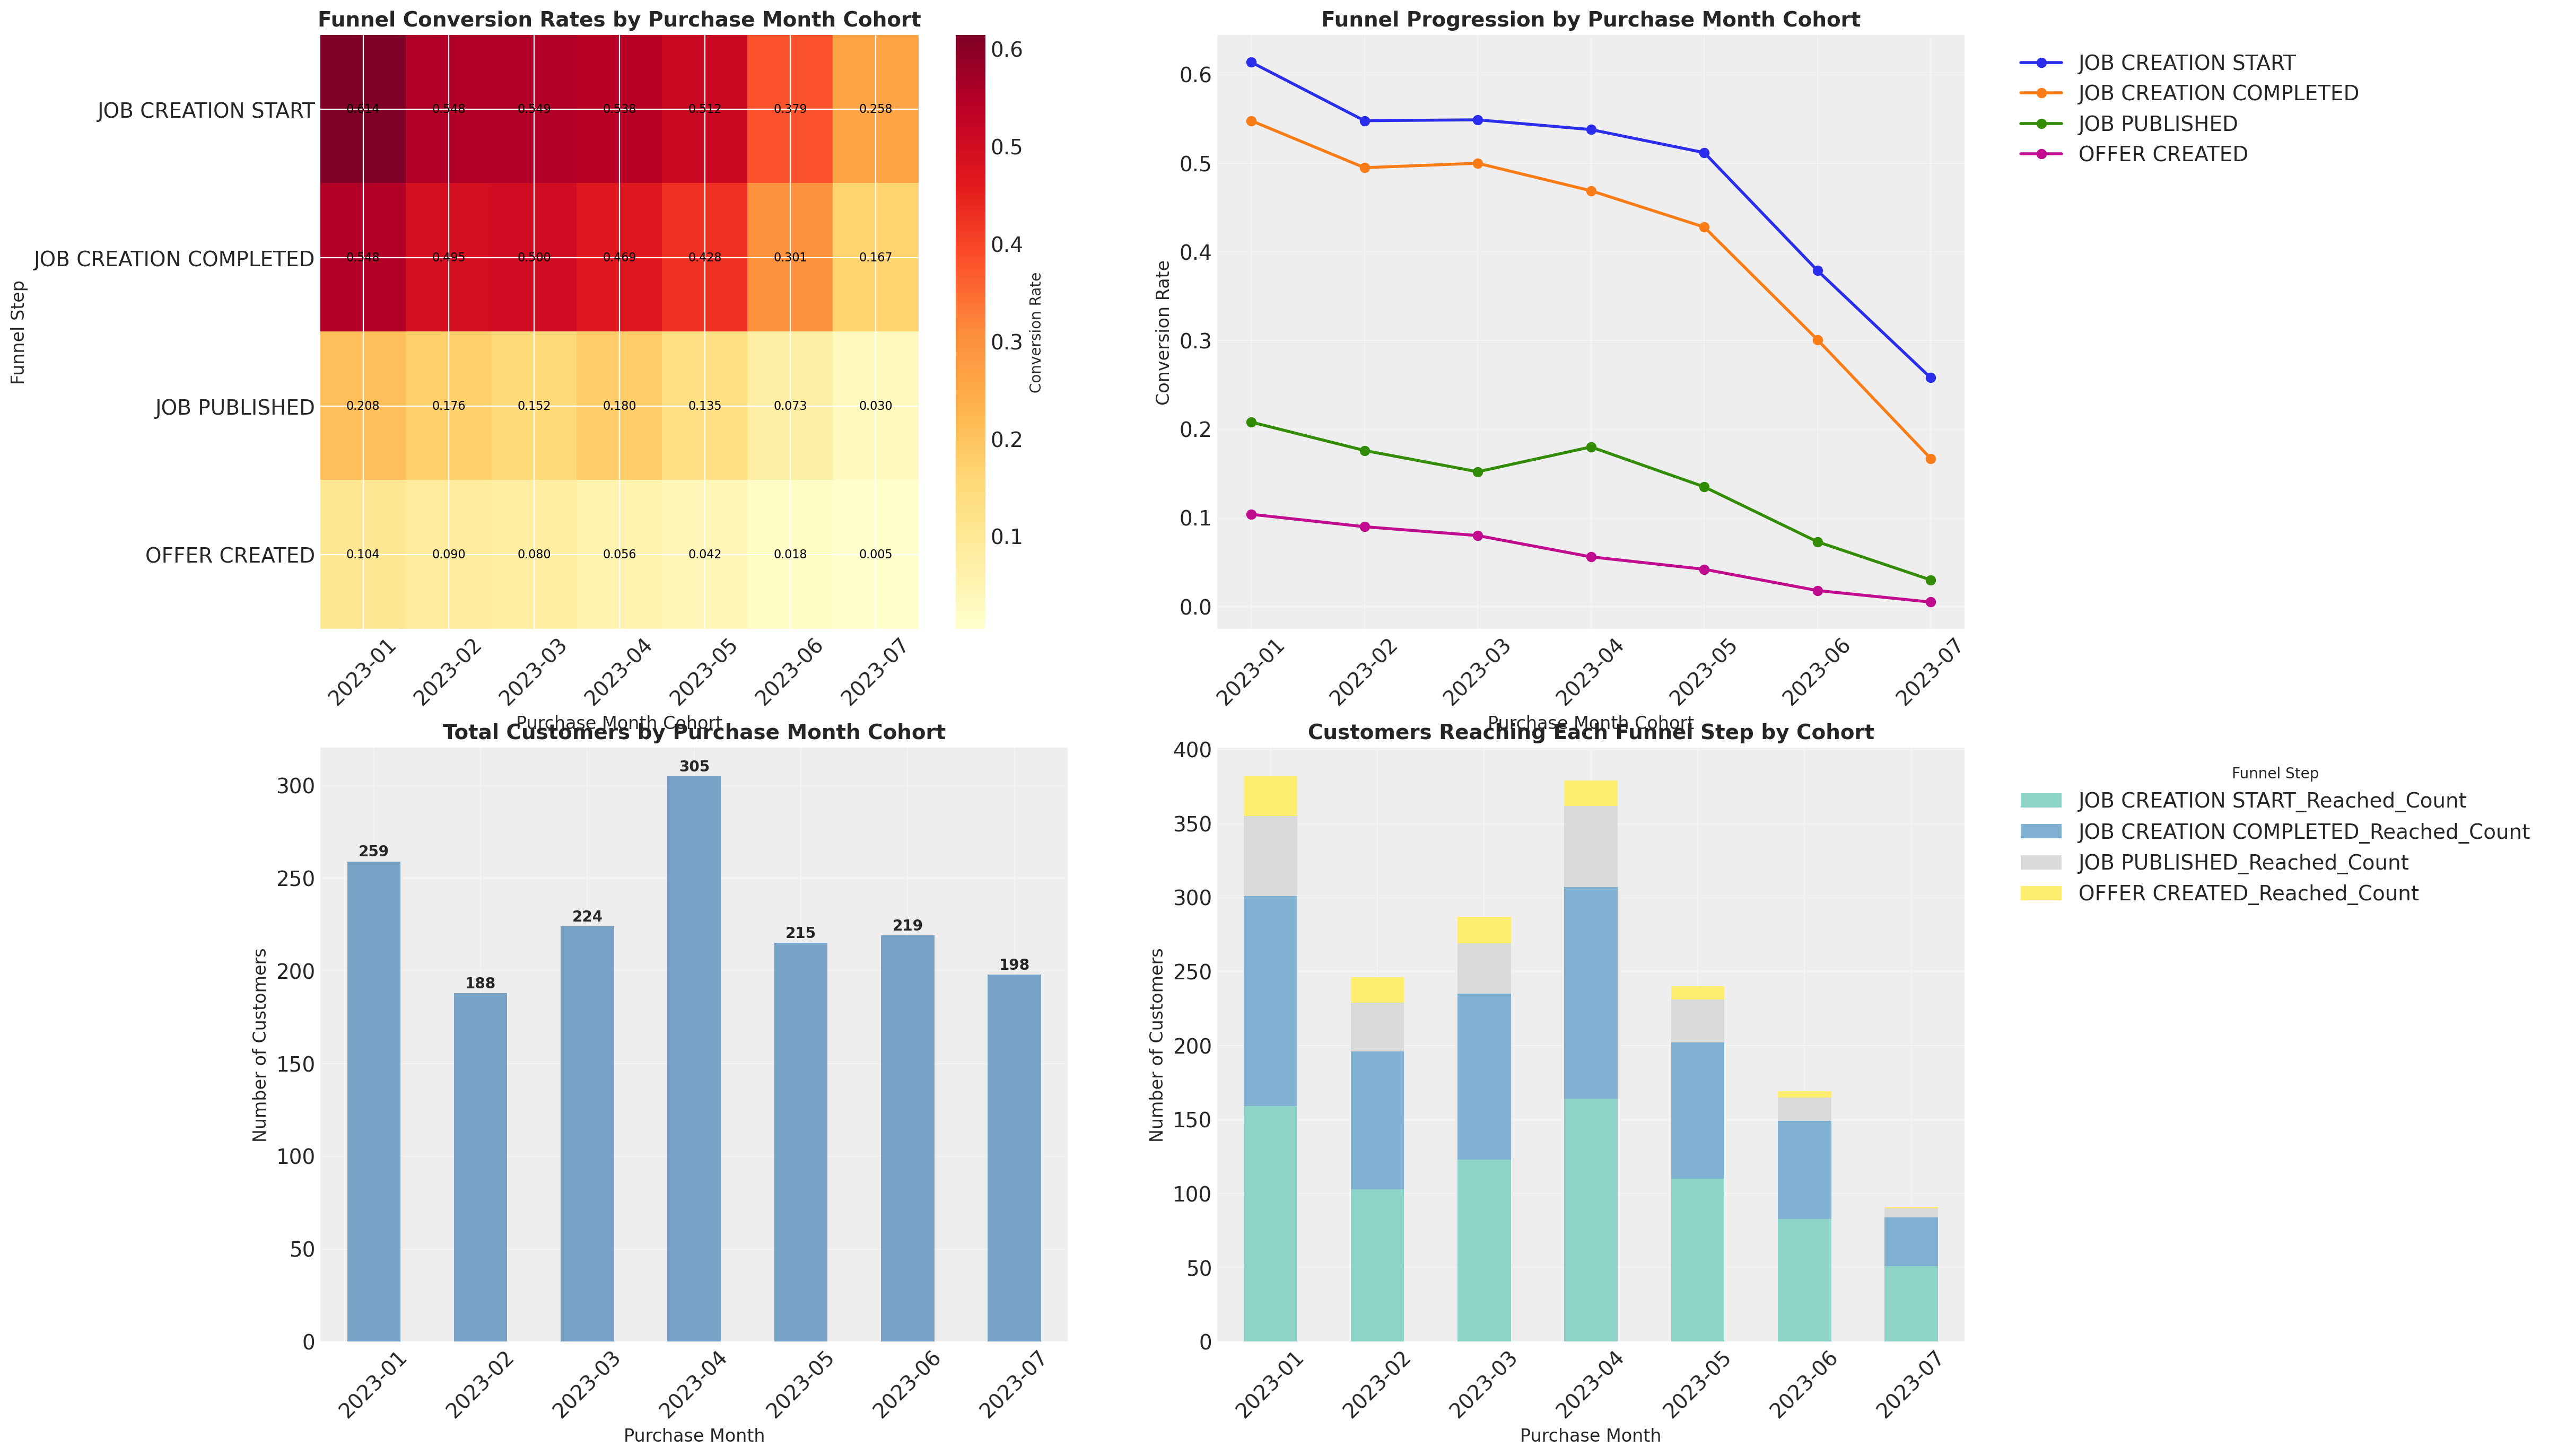

In [117]:
# Create visualizations for the comprehensive cohort analysis

# Extract rate columns for plotting
rate_columns = [col for col in cohort_stats.columns if col.endswith("_Rate")]
rate_data = cohort_stats[rate_columns]

# Create a comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Funnel rates by cohort (heatmap style)
im = ax1.imshow(rate_data.T.values, cmap="YlOrRd", aspect="auto")
ax1.set_title(
    "Funnel Conversion Rates by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax1.set_xlabel("Purchase Month Cohort", fontsize=12)
ax1.set_ylabel("Funnel Step", fontsize=12)
ax1.set_xticks(range(len(rate_data.index)))
ax1.set_xticklabels(rate_data.index, rotation=45)
ax1.set_yticks(range(len(rate_columns)))
ax1.set_yticklabels([col.replace("_Rate", "") for col in rate_columns])

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("Conversion Rate", fontsize=10)

# Add text annotations
for i in range(len(rate_columns)):
    for j in range(len(rate_data.index)):
        text = ax1.text(
            j,
            i,
            f"{rate_data.iloc[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Plot 2: Line plot showing progression by cohort
for i, col in enumerate(rate_columns):
    ax2.plot(
        range(len(rate_data.index)),
        rate_data[col],
        marker="o",
        linewidth=2,
        label=col.replace("_Rate", ""),
        markersize=6,
    )

ax2.set_title(
    "Funnel Progression by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax2.set_xlabel("Purchase Month Cohort", fontsize=12)
ax2.set_ylabel("Conversion Rate", fontsize=12)
ax2.set_xticks(range(len(rate_data.index)))
ax2.set_xticklabels(rate_data.index, rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.grid(True, alpha=0.3)

# Plot 3: Bar chart of total customers by cohort
cohort_stats["Total_Customers"].plot(kind="bar", ax=ax3, color="steelblue", alpha=0.7)
ax3.set_title(
    "Total Customers by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax3.set_xlabel("Purchase Month", fontsize=12)
ax3.set_ylabel("Number of Customers", fontsize=12)
ax3.tick_params(axis="x", rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(cohort_stats["Total_Customers"]):
    ax3.text(i, v + 1, f"{int(v)}", ha="center", va="bottom", fontweight="bold")

# Plot 4: Stacked bar chart showing absolute numbers reaching each step
step_columns = [col for col in cohort_stats.columns if col.endswith("_Reached_Count")]
step_data = cohort_stats[step_columns]

# Create stacked bar chart
step_data.plot(kind="bar", stacked=True, ax=ax4, colormap="Set3")
ax4.set_title(
    "Customers Reaching Each Funnel Step by Cohort", fontsize=14, fontweight="bold"
)
ax4.set_xlabel("Purchase Month", fontsize=12)
ax4.set_ylabel("Number of Customers", fontsize=12)
ax4.tick_params(axis="x", rotation=45)
ax4.legend(title="Funnel Step", bbox_to_anchor=(1.05, 1), loc="upper left")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [90]:
# Calculate conversion rates between steps for each cohort
print("Conversion Rates Between Steps by Cohort:")
print("=" * 80)

# Create a conversion rate analysis
conversion_analysis = pd.DataFrame(index=cohort_stats.index)

# Calculate step-to-step conversion rates
for i in range(1, len(step_names)):
    current_step = step_names[i]
    previous_step = step_names[i - 1]

    # Get the rate columns
    current_rate_col = f"{current_step}_Rate"
    previous_rate_col = f"{previous_step}_Rate" if i > 1 else None

    if previous_rate_col:
        # Calculate conversion rate from previous step to current step
        conversion_analysis[f"{previous_step}_to_{current_step}"] = (
            cohort_stats[current_rate_col] / cohort_stats[previous_rate_col]
        ).round(3)
    else:
        # For the first step, it's just the rate itself
        conversion_analysis[f"Total_to_{current_step}"] = cohort_stats[current_rate_col]

print(conversion_analysis)

# Calculate overall statistics
print("\nOverall Funnel Statistics by Cohort:")
print("=" * 50)
for month in cohort_stats.index:
    print(f"\n{month} Cohort:")
    print(f"  Total Customers: {cohort_stats.loc[month, 'Total_Customers']:.0f}")
    for i, step in enumerate(step_names[1:], 1):
        rate_col = f"{step}_Rate"
        count_col = f"{step}_Reached_Count"
        rate = cohort_stats.loc[month, rate_col]
        count = cohort_stats.loc[month, count_col]
        print(f"  {step}: {rate:.3f} ({count:.0f} customers)")


Conversion Rates Between Steps by Cohort:
                Total_to_JOB CREATION START  \
PURCHASE_MONTH                                
2023-01                               0.614   
2023-02                               0.548   
2023-03                               0.549   
2023-04                               0.538   
2023-05                               0.512   
2023-06                               0.379   
2023-07                               0.258   

                JOB CREATION START_to_JOB CREATION COMPLETED  \
PURCHASE_MONTH                                                 
2023-01                                                0.893   
2023-02                                                0.903   
2023-03                                                0.911   
2023-04                                                0.872   
2023-05                                                0.836   
2023-06                                                0.794   
2023-07               

In [91]:
# Summary insights and cohort performance analysis
print("Cohort Performance Summary:")
print("=" * 60)

# Find best and worst performing cohorts for each step
for i, step in enumerate(step_names[1:], 1):
    rate_col = f"{step}_Rate"
    print(f"\n{step}:")

    # Best performing cohort
    best_cohort = cohort_stats[rate_col].idxmax()
    best_rate = cohort_stats.loc[best_cohort, rate_col]
    best_count = cohort_stats.loc[best_cohort, f"{step}_Reached_Count"]
    best_total = cohort_stats.loc[best_cohort, "Total_Customers"]

    # Worst performing cohort
    worst_cohort = cohort_stats[rate_col].idxmin()
    worst_rate = cohort_stats.loc[worst_cohort, rate_col]
    worst_count = cohort_stats.loc[worst_cohort, f"{step}_Reached_Count"]
    worst_total = cohort_stats.loc[worst_cohort, "Total_Customers"]

    print(
        f"  Best: {best_cohort} - {best_rate:.3f} ({best_count:.0f}/{best_total:.0f})"
    )
    print(
        f"  Worst: {worst_cohort} - {worst_rate:.3f} ({worst_count:.0f}/{worst_total:.0f})"
    )
    print(f"  Average: {cohort_stats[rate_col].mean():.3f}")
    print(f"  Std Dev: {cohort_stats[rate_col].std():.3f}")

# Overall insights
print("\nOverall Insights:")
print(f"Number of cohorts analyzed: {len(cohort_stats)}")
print(
    f"Total customers across all cohorts: {cohort_stats['Total_Customers'].sum():.0f}"
)

# Calculate overall funnel rates
overall_rates = {}
for i, step in enumerate(step_names[1:], 1):
    total_reached = cohort_stats[f"{step}_Reached_Count"].sum()
    total_customers = cohort_stats["Total_Customers"].sum()
    overall_rates[step] = total_reached / total_customers

print("\nOverall Funnel Rates (across all cohorts):")
for step, rate in overall_rates.items():
    print(f"  {step}: {rate:.3f}")


Cohort Performance Summary:

JOB CREATION START:
  Best: 2023-01 - 0.614 (159/259)
  Worst: 2023-07 - 0.258 (51/198)
  Average: 0.485
  Std Dev: 0.123

JOB CREATION COMPLETED:
  Best: 2023-01 - 0.548 (142/259)
  Worst: 2023-07 - 0.167 (33/198)
  Average: 0.415
  Std Dev: 0.135

JOB PUBLISHED:
  Best: 2023-01 - 0.208 (54/259)
  Worst: 2023-07 - 0.030 (6/198)
  Average: 0.136
  Std Dev: 0.063

OFFER CREATED:
  Best: 2023-01 - 0.104 (27/259)
  Worst: 2023-07 - 0.005 (1/198)
  Average: 0.056
  Std Dev: 0.037

Overall Insights:
Number of cohorts analyzed: 7
Total customers across all cohorts: 1608

Overall Funnel Rates (across all cohorts):
  JOB CREATION START: 0.493
  JOB CREATION COMPLETED: 0.424
  JOB PUBLISHED: 0.141
  OFFER CREATED: 0.058


In [ ]:
# Fixed version: Calculate the share of customers per INDUSTRY_CLUSTER grouped by COUNTRY
# with proper handling of missing values

# First, create a copy of the data with filled missing values
customers_with_missing = customers_filtered.copy()
customers_with_missing["INDUSTRY_CLUSTER"] = customers_with_missing[
    "INDUSTRY_CLUSTER"
].fillna("MISSING")

# Calculate the share of customers per INDUSTRY_CLUSTER grouped by COUNTRY
industry_share = (
    customers_with_missing.groupby("COUNTRY")["INDUSTRY_CLUSTER"]
    .value_counts(normalize=True)
    .reset_index()
)
industry_share.columns = ["COUNTRY", "INDUSTRY_CLUSTER", "SHARE"]

# Calculate the total distribution from the full customers dataset
customers_total_with_missing = customers.copy()
customers_total_with_missing["INDUSTRY_CLUSTER"] = customers_total_with_missing[
    "INDUSTRY_CLUSTER"
].fillna("MISSING")

total_distribution = (
    customers_total_with_missing["INDUSTRY_CLUSTER"]
    .value_counts(normalize=True)
    .reset_index()
)
total_distribution.columns = ["INDUSTRY_CLUSTER", "SHARE"]
total_distribution["COUNTRY"] = "Total"

# Combine the country-specific and total distributions
combined_share = pd.concat([industry_share, total_distribution], ignore_index=True)

# Create a pivot table with countries as index and industry clusters as columns
industry_pivot = combined_share.pivot(
    index="COUNTRY", columns="INDUSTRY_CLUSTER", values="SHARE"
).fillna(0)

# Create a stacked bar chart showing countries on x-axis and industry clusters as colors
plt.figure(figsize=(14, 10))
industry_pivot.plot(kind="barh", stacked=True, figsize=(14, 10), colormap="Set3")
plt.title(
    "Share of Customers per Industry Cluster by Country (Including Missing)",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Share of Customers", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.legend(title="Industry Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display the data table
print("Share of Customers per Industry Cluster by Country (Including Missing):")
print("=" * 70)
print(industry_pivot.round(3))


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/942288217.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)


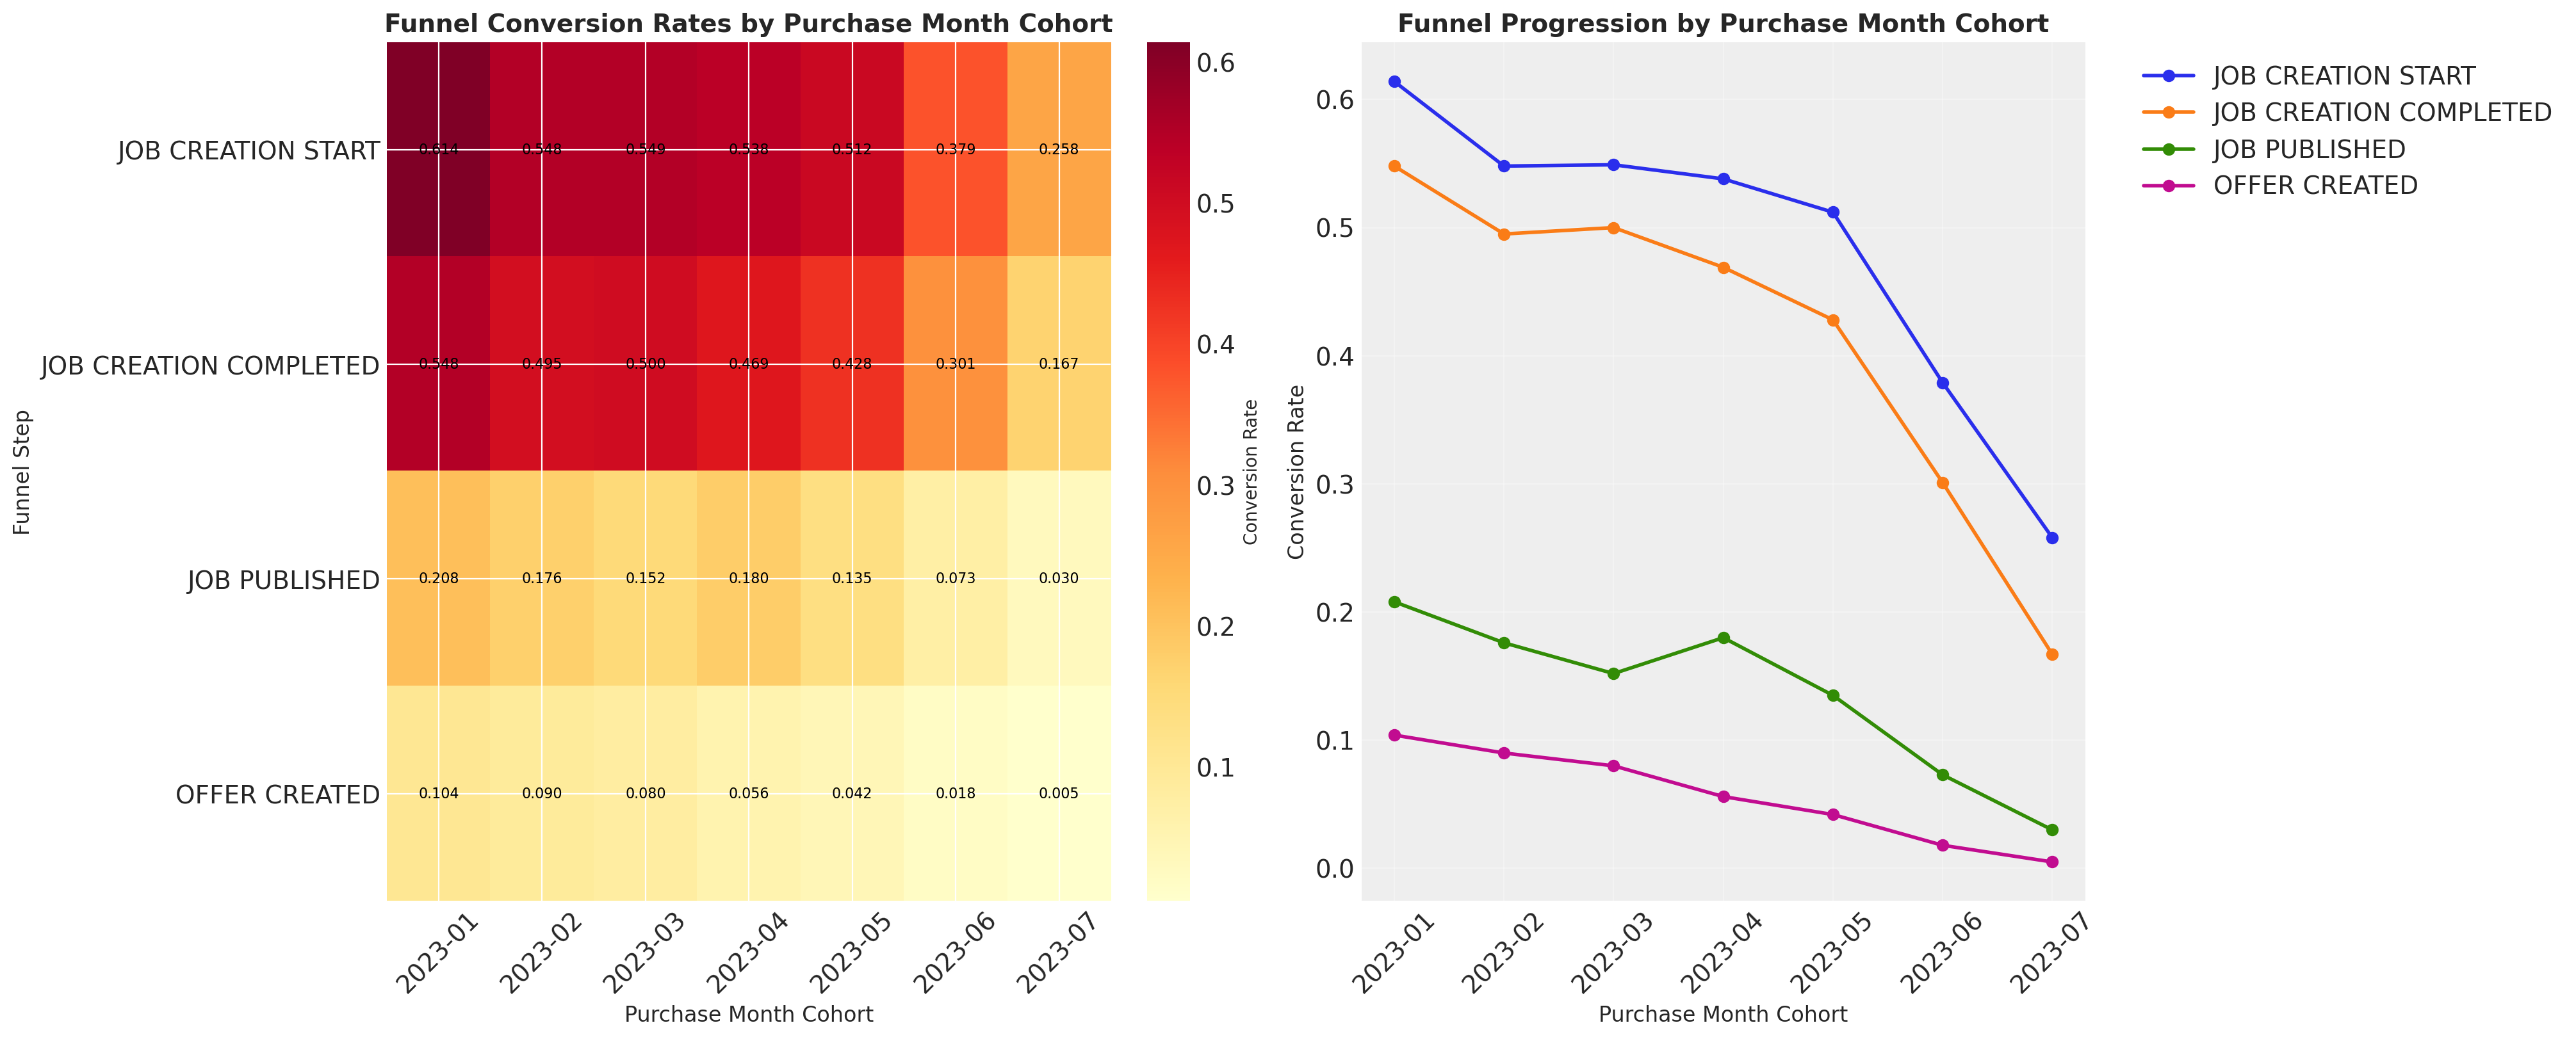

In [121]:
# Simplified visualization - only heatmap and line plot
# Extract rate columns for plotting
rate_columns = [col for col in cohort_stats.columns if col.endswith("_Rate")]
rate_data = cohort_stats[rate_columns]

# Create a 2-panel visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Funnel rates by cohort (heatmap style)
im = ax1.imshow(rate_data.T.values, cmap="YlOrRd", aspect="auto")
ax1.set_title(
    "Funnel Conversion Rates by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax1.set_xlabel("Purchase Month Cohort", fontsize=12)
ax1.set_ylabel("Funnel Step", fontsize=12)
ax1.set_xticks(range(len(rate_data.index)))
ax1.set_xticklabels(rate_data.index, rotation=45)
ax1.set_yticks(range(len(rate_columns)))
ax1.set_yticklabels([col.replace("_Rate", "") for col in rate_columns])

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("Conversion Rate", fontsize=10)

# Add text annotations
for i in range(len(rate_columns)):
    for j in range(len(rate_data.index)):
        text = ax1.text(
            j,
            i,
            f"{rate_data.iloc[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Plot 2: Line plot showing progression by cohort
for i, col in enumerate(rate_columns):
    ax2.plot(
        range(len(rate_data.index)),
        rate_data[col],
        marker="o",
        linewidth=2,
        label=col.replace("_Rate", ""),
        markersize=6,
    )

ax2.set_title(
    "Funnel Progression by Purchase Month Cohort", fontsize=14, fontweight="bold"
)
ax2.set_xlabel("Purchase Month Cohort", fontsize=12)
ax2.set_ylabel("Conversion Rate", fontsize=12)
ax2.set_xticks(range(len(rate_data.index)))
ax2.set_xticklabels(rate_data.index, rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.grid(True, alpha=0.3)

# Use subplots_adjust instead of tight_layout to avoid colorbar issues
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.show()


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_19127/3008981015.py:88: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)


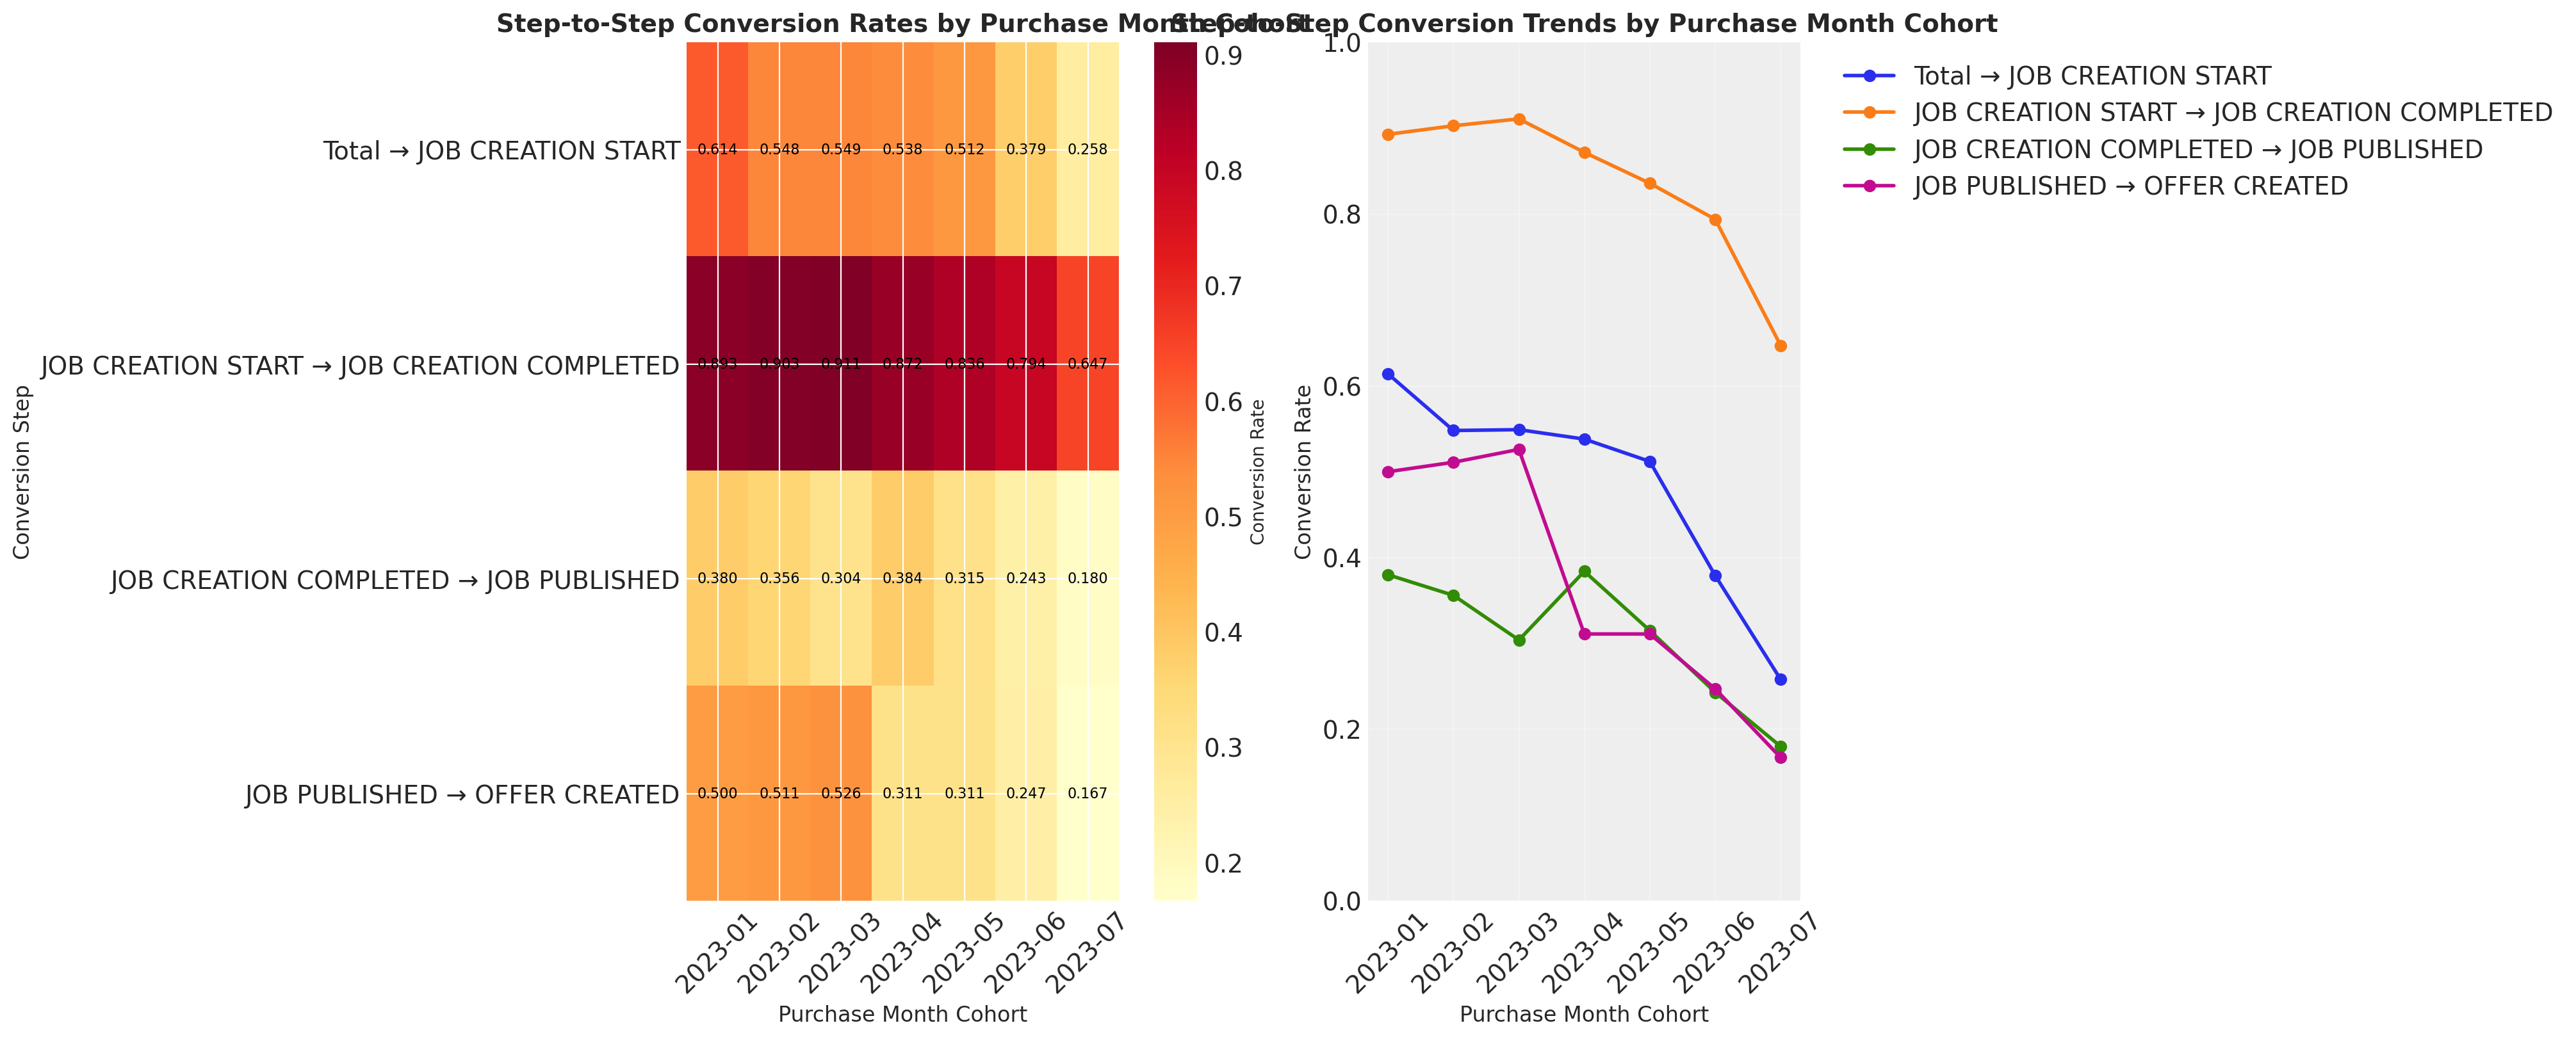

Step-to-Step Conversion Rates by Cohort:
                Total_to_JOB CREATION START  \
PURCHASE_MONTH                                
2023-01                               0.614   
2023-02                               0.548   
2023-03                               0.549   
2023-04                               0.538   
2023-05                               0.512   
2023-06                               0.379   
2023-07                               0.258   

                JOB CREATION START_to_JOB CREATION COMPLETED  \
PURCHASE_MONTH                                                 
2023-01                                                0.893   
2023-02                                                0.903   
2023-03                                                0.911   
2023-04                                                0.872   
2023-05                                                0.836   
2023-06                                                0.794   
2023-07                

In [120]:
# Step-to-step conversion rates visualization
# Calculate conversion rates between consecutive steps for each cohort

# Create conversion rate data
conversion_columns = []
conversion_data = pd.DataFrame(index=cohort_stats.index)

# Calculate step-to-step conversion rates
for i in range(1, len(step_names)):
    current_step = step_names[i]
    previous_step = step_names[i - 1]

    # Get the rate columns
    current_rate_col = f"{current_step}_Rate"
    previous_rate_col = f"{previous_step}_Rate" if i > 1 else None

    if previous_rate_col:
        # Calculate conversion rate from previous step to current step
        conversion_rate = (
            cohort_stats[current_rate_col] / cohort_stats[previous_rate_col]
        ).round(3)
        conversion_data[f"{previous_step}_to_{current_step}"] = conversion_rate
        conversion_columns.append(f"{previous_step}_to_{current_step}")
    else:
        # For the first step, it's just the rate itself
        conversion_data[f"Total_to_{current_step}"] = cohort_stats[current_rate_col]
        conversion_columns.append(f"Total_to_{current_step}")

# Create visualization for step-to-step conversion rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Step-to-step conversion rates heatmap
im = ax1.imshow(conversion_data.T.values, cmap="YlOrRd", aspect="auto")
ax1.set_title(
    "Step-to-Step Conversion Rates by Purchase Month Cohort",
    fontsize=14,
    fontweight="bold",
)
ax1.set_xlabel("Purchase Month Cohort", fontsize=12)
ax1.set_ylabel("Conversion Step", fontsize=12)
ax1.set_xticks(range(len(conversion_data.index)))
ax1.set_xticklabels(conversion_data.index, rotation=45)
ax1.set_yticks(range(len(conversion_columns)))
ax1.set_yticklabels([col.replace("_to_", " → ") for col in conversion_columns])

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("Conversion Rate", fontsize=10)

# Add text annotations
for i in range(len(conversion_columns)):
    for j in range(len(conversion_data.index)):
        text = ax1.text(
            j,
            i,
            f"{conversion_data.iloc[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Plot 2: Line plot showing step-to-step conversion trends by cohort
for i, col in enumerate(conversion_columns):
    ax2.plot(
        range(len(conversion_data.index)),
        conversion_data[col],
        marker="o",
        linewidth=2,
        label=col.replace("_to_", " → "),
        markersize=6,
    )

ax2.set_title(
    "Step-to-Step Conversion Trends by Purchase Month Cohort",
    fontsize=14,
    fontweight="bold",
)
ax2.set_xlabel("Purchase Month Cohort", fontsize=12)
ax2.set_ylabel("Conversion Rate", fontsize=12)
ax2.set_xticks(range(len(conversion_data.index)))
ax2.set_xticklabels(conversion_data.index, rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)  # Set y-axis from 0 to 1 for better comparison

# Use subplots_adjust instead of tight_layout to avoid colorbar issues
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.show()

# Display the conversion rates table
print("Step-to-Step Conversion Rates by Cohort:")
print("=" * 80)
print(conversion_data.round(3))
